XGBoost Classification - 'real-world' example: UCI Skin Segmentation dataset

GP EI versus GP dEI

https://archive.ics.uci.edu/ml/datasets/Skin+Segmentation

In [ ]:
pip install pyGPGO


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.8 MB 2.2 MB/s 
     |████████████████████████████████| 872 kB 32.4 MB/s 
  Created wheel for pyGPGO: filename=pyGPGO-0.5.1-py3-none-any.whl size=19879 sha256=8a439ab409193ed194dd7a400f891e7684f9d296f6ff362f032e36c22ae5d1c5
  Stored in directory: /root/.cache/pip/wheels/c8/5d/0b/2160114e2f1b87791c51b66cf07f89831dbb6f49167950316f
  Created wheel for Theano-PyMC: filename=Theano_PyMC-1.1.2-py3-none-any.whl size=1529963 sha256=b3684ead7b84391ca156fa2b00dbb8fb062f4d56dc0631106821e865d16064f7
  Stored in directory: /root/.cache/pip/wheels/f3/af/8c/5dd7553522d74c52a7813806fc7ee1a9caa20a3f7c8fd850d5
Successfully built pyGPGO Theano-PyMC


In [ ]:
# Load some default Python modules:

import numpy as np
import scipy as sp
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.pyplot import rc
rc('text', usetex=False)

from collections import OrderedDict
from numpy.linalg import slogdet
from scipy.linalg import inv
from scipy.optimize import minimize
from scipy.spatial.distance import cdist
from scipy.special import gamma
from scipy.stats import norm, t
from joblib import Parallel, delayed
import itertools

from pyGPGO.logger import EventLogger
from pyGPGO.GPGO import GPGO
from pyGPGO.surrogates.GaussianProcess import GaussianProcess
from pyGPGO.surrogates.tStudentProcess import tStudentProcess
from pyGPGO.surrogates.tStudentProcess import logpdf
from pyGPGO.acquisition import Acquisition
from pyGPGO.covfunc import squaredExponential, matern32, matern52
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error

import xgboost as xgb
from xgboost import XGBClassifier

import warnings
import random
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)
warnings.filterwarnings("ignore", category=UserWarning)


In [ ]:
def ReadData():
    #Data in format [B G R Label] from
    data = np.genfromtxt('/content/sample_data/Skin_NonSkin.txt', dtype=np.int32)

    labels = data[:,3]
    data = data[:,0:3]

    return data, labels

data, labels = ReadData()

X = data
y = labels


In [ ]:
### Bayesian Optimisation - inputs:

obj_func = 'XGBoost'
n_test = 500 # test points
df = 3 # nu

util_gp = 'CBM_gp'
util_stp = 'CBM_stp'
n_init = 5 # random initialisations

test_perc = 0.1
train_perc = 1 - test_perc
n_est = 3

obj_classifier = 'binary:logistic'
opt = True

eps = 1e-08
inverse = -1


In [ ]:
### Objective function:

if obj_func == 'XGBoost':
    
    # Constraints:
    param_lb_alpha = 0
    param_ub_alpha = 10
    
    param_lb_gamma = 0
    param_ub_gamma = 10
    
    param_lb_max_depth = 5
    param_ub_max_depth = 15
    
    param_lb_min_child_weight = 1
    param_ub_min_child_weight = 20
    
    param_lb_subsample = .5
    param_ub_subsample = 1
    
    param_lb_colsample = .1
    param_ub_colsample = 1
    
    # 6-D inputs' parameter bounds:
    param = { 'alpha':  ('cont', (param_lb_alpha, param_ub_alpha)),
         'gamma':  ('cont', (param_lb_gamma, param_ub_gamma)),     
         'max_depth':  ('int', (param_lb_max_depth, param_ub_max_depth)),
         'subsample':  ('cont', (param_lb_subsample, param_ub_subsample)),
          'min_child_weight':  ('int', (param_lb_min_child_weight, param_ub_min_child_weight)),
            'colsample': ('cont', (param_lb_colsample, param_ub_colsample))
        }
       
    # True y bounds:
    y_global_orig = 1
    dim = 6
    
    max_iter = 30 

In [ ]:
### Surrogate derivatives: 

cov_func = squaredExponential()

def kronDelta(X, Xstar):                     # Kronecker's Delta method
    return cdist(X, Xstar) < np.finfo(np.float32).eps

def se(X, Xstar, sigmaf, l, sigman):         # S.E. kernel method
    return sigmaf * np.exp(-0.5 * cdist(X, Xstar) ** 2 / l ** 2) + sigman * kronDelta(X, Xstar)

def delta(X, Xstar):                         # Distance between training X and test Xstar vectors
    return (X - Xstar)
   
def der_covmat(X, Xstar, sigmaf, l, sigman): # Covariance matrix derivative terms (i.e. exact, first-order)
    nx = len(X)
    ny = len(Xstar)
    return np.round(np.array([(delta(np.atleast_2d(i), np.atleast_2d(j))[0] * se(np.atleast_2d(i), np.atleast_2d(j), sigmaf, l, sigman)[0]).sum() for (i, j) in itertools.product(X, Xstar)]).reshape(nx, ny), 8)

class dGaussianProcess(GaussianProcess):    # Via inheritance, also optimises hyperparameters when opt = TRUE
    
    def AcqGrad(self, Xstar):               # Method returning exact, first-order derivatives of the GP's posterior mean and standard deviation
        Xstar = np.atleast_2d(Xstar)
        Kstar = self.covfunc.K(self.X, Xstar).T
        
        dKstar = der_covmat(self.X, Xstar, self.covfunc.sigmaf, self.covfunc.l, self.covfunc.sigman).T
        alpha_Kstar = np.dot(np.linalg.inv(self.K + (self.covfunc.sigman**2) * np.eye(len(self.X))), Kstar.T)
        
        dm = np.dot(dKstar, self.alpha)
        ds = -2 * np.dot(dKstar, alpha_Kstar)
        
        return dm, ds       

class dtStudentProcess(tStudentProcess):    # Via inheritance, also optimises hyperparameters when opt = TRUE
    
    def AcqGrad(self, Xstar):               # Method returning exact, first-order derivatives of the STP's posterior mean and standard deviation
        Xstar = np.atleast_2d(Xstar)
        Kstar = self.covfunc.K(self.X, Xstar).T
        dKstar = der_covmat(self.X, Xstar, self.covfunc.sigmaf, self.covfunc.l, self.covfunc.sigman).T
        
        smd_adj = (self.nu + self.beta1 - 2) / (self.nu + self.n1 - 2)

        alpha = np.dot(np.linalg.inv(self.K11 + (self.covfunc.sigman**2) * np.eye(len(self.X))), self.y)
        alpha_Kstar = np.dot(np.linalg.inv(self.K11 + (self.covfunc.sigman**2) * np.eye(len(self.X))), Kstar.T)      
        
        dm = np.dot(dKstar, alpha)
        ds = -2 * smd_adj * np.dot(dKstar, alpha_Kstar)
        
        return dm, ds           
        

In [ ]:
### Cumulative Regret Calculator:

def min_max_array(x):
    new_list = []
    for i, num in enumerate(x):
            new_list.append(np.min(x[0:i+1]))
    return new_list


In [ ]:
### Set-seeds:

run_num_1 = 1
run_num_2 = 2
run_num_3 = 3
run_num_4 = 4
run_num_5 = 5
run_num_6 = 6
run_num_7 = 7
run_num_8 = 8
run_num_9 = 9
run_num_10 = 10
run_num_11 = 11
run_num_12 = 12
run_num_13 = 13
run_num_14 = 14
run_num_15 = 15
run_num_16 = 16
run_num_17 = 17
run_num_18 = 18
run_num_19 = 19
run_num_20 = 20


In [ ]:
### Add exact acquisition function gradient as attribute:

Beta_CBM = dim

class Acquisition_grad(Acquisition):    
    def __init__(self, mode, eps=eps, **params):
        
        self.params = params
        self.eps = eps

        mode_dict = {
            'CBM_stp': self.CBM_stp,
            'CBM_gp': self.CBM_gp,
        }

        self.f = mode_dict[mode]
    
    def CBM_stp(self, y_global_orig, mean, std, ds, dm, nu=3.0):
        gamma = (mean - y_global_orig - self.eps) / (std + self.eps)
        gamma_h = (mean - y_global_orig) / (std + self.eps)
        dsdx = ds / (2 * (std + self.eps))
        dmdx = (dm - gamma * dsdx) / (std + self.eps)

        f = (std + self.eps) * (gamma + np.sqrt(Beta_CBM))
        df = dsdx * (gamma + np.sqrt(Beta_CBM)) + (std + self.eps) * dmdx
        df_arr = []

        for j in range(0, dim):
          df_arr.append(df)
        return f, np.asarray(df_arr).transpose()
        
    def d_eval_stp(self, tau, mean, std, ds, dm, nu=3.0):
    
        return self.f(tau, mean, std, ds, dm, nu=3.0, **self.params)

    def CBM_gp(self, tau, mean, std, ds, dm):
        gamma = (mean - y_global_orig - self.eps) / (std + self.eps)
        gamma_h = (mean - y_global_orig) / (std + self.eps)
        dsdx = ds / (2 * (std + self.eps))
        dmdx = (dm - gamma * dsdx) / (std + self.eps)

        f = (std + self.eps) * (gamma + np.sqrt(Beta_CBM))
        df = dsdx * (gamma + np.sqrt(Beta_CBM)) + (std + self.eps) * dmdx
        df_arr = []

        for j in range(0, dim):
          df_arr.append(df)
        return f, np.asarray(df_arr).transpose()
        
    def d_eval_gp(self, tau, mean, std, ds, dm):
    
        return self.f(tau, mean, std, ds, dm, **self.params)
        

In [ ]:
n_start_AcqFunc = max_iter

In [ ]:
## dGPGO - Gaussian:

class dGPGO_gp(GPGO):
    n_start = n_start_AcqFunc

    def __init__(self, surrogate, acquisition, f, parameter_dict, n_jobs=1):
        self.GP = surrogate
        self.A = acquisition
        self.f = f
        self.parameters = parameter_dict
        self.n_jobs = n_jobs

        self.parameter_key = list(parameter_dict.keys())
        self.parameter_value = list(parameter_dict.values())
        self.parameter_type = [p[0] for p in self.parameter_value]
        self.parameter_range = [p[1] for p in self.parameter_value]

        self.history = []
        self.header =   'Evaluation \t Proposed point \t  Current eval. \t  Best eval. \t         Max. ExactAcqFunc \t Max. ApproxAcqFunc '
        self.template = '{:3}\t {}\t {:3}\t {:3}\t {:3}\t {:3}'

    def acqfuncExact(self, xnew, n_start=n_start_AcqFunc):
        new_mean, new_var = self.GP.predict(xnew, return_std=True)
        new_std = np.sqrt(new_var + eps)
        dm, ds = self.GP.AcqGrad(xnew)
        f, df = self.A.d_eval_gp(self.tau, new_mean, new_std, ds=ds, dm=dm)

        return -f, -df
   
    def acqfuncApprox(self, xnew, n_start=n_start_AcqFunc):
        new_mean, new_var = self.GP.predict(xnew, return_std=True)
        new_std = np.sqrt(new_var + eps)
        dm, ds = self.GP.AcqGrad(xnew)
        f, df = self.A.d_eval_gp(self.tau, new_mean, new_std, ds=ds, dm=dm)

        return -f

    def d_optimizeAcq(self, method='L-BFGS-B', n_start=n_start_AcqFunc):
        start_points_dict = [self._sampleParam() for i in range(n_start)]
        start_points_arr = np.array([list(s.values())
                                     for s in start_points_dict])
        x_best = np.empty((n_start, len(self.parameter_key)))
        f_best = np.empty((n_start,))
        opt = Parallel(n_jobs=self.n_jobs)(delayed(minimize)(self.acqfuncExact,
                                                                 x0=start_point,
                                                                 method=method,
                                                                 jac = True,
                                                                 bounds=self.parameter_range) for start_point in
                                               start_points_arr)
        x_best = np.array([res.x for res in opt])
        f_best = np.array([np.atleast_1d(res.fun)[0] for res in opt])
        f_best_min = min(f_best)

        self.x_best = x_best
        self.f_best = f_best
        self.f_best_min = f_best_min
        self.x_best_std = np.std(x_best)
        self.best = x_best[np.argmin(f_best)]
        self.start_points_arr = start_points_arr
        self.history.append(self.x_best_std)

        x_best_gp = np.empty((n_start, len(self.parameter_key)))
        f_best_gp = np.empty((n_start,))
        opt_gp = Parallel(n_jobs=self.n_jobs)(delayed(minimize)(self.acqfuncApprox,
                                                                 x0=start_point,
                                                                 method=method,
                                                                 jac = False,
                                                                 bounds=self.parameter_range) for start_point in
                                               start_points_arr)
        x_best_gp = np.array([res.x for res in opt_gp])
        f_best_gp = np.array([np.atleast_1d(res.fun)[0] for res in opt_gp])
        f_best_min_gp = min(f_best_gp)

        self.x_best_gp = x_best_gp
        self.f_best_gp = f_best_gp
        self.f_best_min_gp = f_best_min_gp
        self.x_best_std_gp = np.std(x_best_gp)
        self.best_gp = x_best_gp[np.argmin(f_best_gp)]
        self.start_points_arr = start_points_arr
        self.history.append(self.x_best_std_gp)
    
    def _printInit(self):
        print(self.header)
        for init_eval in range(self.init_evals):
            print(self.template.format('init', self.GP.X[init_eval], inverse * self.GP.y[init_eval], inverse * self.tau, '', ''))
      
    def _printCurrent(self):
        OKGREEN = '\033[92m'
        ENDC = '\033[0m'
        BOLD = '\033[1m'
        eval = str(len(self.GP.y) - self.init_evals)
        proposed = str(self.best)
        curr_eval = str(inverse * self.GP.y[-1])
        curr_best = str(inverse * self.tau)
        min_acqfunc = str(self.f_best_min)
        min_acqfunc_gp = str(self.f_best_min_gp)
        x_best_std = str(self.x_best_std)
        x_best_std_gp = str(self.x_best_std_gp)
        if float(curr_eval) <= float(curr_best):
            eval = BOLD + OKGREEN + eval + ENDC
            proposed = BOLD + OKGREEN + proposed + ENDC
            curr_eval = BOLD + OKGREEN + curr_eval + ENDC
            curr_best = BOLD + OKGREEN + curr_best + ENDC
            x_best_std = BOLD + OKGREEN + x_best_std + ENDC
            x_best_std_gp = BOLD + OKGREEN + x_best_std_gp + ENDC
        print(self.template.format(eval, proposed, curr_eval, curr_best, x_best_std, x_best_std_gp))

    def run(self, max_iter=10, init_evals=3, resume=False):
        
        if not resume:
            self.init_evals = init_evals
            self._firstRun(self.init_evals)
            self._printInit()
        for iteration in range(max_iter):
            self.d_optimizeAcq()
            self.updateGP()
            self._printCurrent()


In [ ]:
## dGPGO - Student's-t:

class dGPGO_stp(GPGO):
    n_start = n_start_AcqFunc

    def __init__(self, surrogate, acquisition, f, parameter_dict, n_jobs=1):
        self.GP = surrogate
        self.A = acquisition
        self.f = f
        self.parameters = parameter_dict
        self.n_jobs = n_jobs

        self.parameter_key = list(parameter_dict.keys())
        self.parameter_value = list(parameter_dict.values())
        self.parameter_type = [p[0] for p in self.parameter_value]
        self.parameter_range = [p[1] for p in self.parameter_value]

        self.history = []
        self.header =   'Evaluation \t Proposed point \t  Current eval. \t  Best eval. \t        Exact CBM: StdDev. x \t Approx CBM: StdDev. x '
        self.template = '{:3}\t {}\t {:3}\t {:3}\t {:3}\t {:3}'

    def acqfuncExact(self, xnew, n_start=n_start_AcqFunc):
        new_mean, new_var = self.GP.predict(xnew, return_std=True)
        new_std = np.sqrt(new_var + eps)
        dm, ds = self.GP.AcqGrad(xnew)
        f, df = self.A.d_eval_stp(self.tau, new_mean, new_std, ds=ds, dm=dm, nu=3.0)

        return -f, -df
   
    def acqfuncApprox(self, xnew, n_start=n_start_AcqFunc):
        new_mean, new_var = self.GP.predict(xnew, return_std=True)
        new_std = np.sqrt(new_var + eps)
        dm, ds = self.GP.AcqGrad(xnew)
        f, df = self.A.d_eval_stp(self.tau, new_mean, new_std, ds=ds, dm=dm, nu=3.0)

        return -f

    def d_optimizeAcq(self, method='L-BFGS-B', n_start=n_start_AcqFunc):
        start_points_dict = [self._sampleParam() for i in range(n_start)]
        start_points_arr = np.array([list(s.values())
                                     for s in start_points_dict])
        x_best = np.empty((n_start, len(self.parameter_key)))
        f_best = np.empty((n_start,))
        opt = Parallel(n_jobs=self.n_jobs)(delayed(minimize)(self.acqfuncExact,
                                                                 x0=start_point,
                                                                 method=method,
                                                                 jac = True,
                                                                 bounds=self.parameter_range) for start_point in
                                               start_points_arr)
        x_best = np.array([res.x for res in opt])
        f_best = np.array([np.atleast_1d(res.fun)[0] for res in opt])
        f_best_min = min(f_best)

        self.x_best = x_best
        self.f_best = f_best
        self.f_best_min = f_best_min
        self.x_best_std = np.std(x_best)
        self.best = x_best[np.argmin(f_best)]
        self.start_points_arr = start_points_arr
        self.history.append(self.x_best_std)

        x_best_gp = np.empty((n_start, len(self.parameter_key)))
        f_best_gp = np.empty((n_start,))
        opt_gp = Parallel(n_jobs=self.n_jobs)(delayed(minimize)(self.acqfuncApprox,
                                                                 x0=start_point,
                                                                 method=method,
                                                                 jac = False,
                                                                 bounds=self.parameter_range) for start_point in
                                               start_points_arr)
        x_best_gp = np.array([res.x for res in opt_gp])
        f_best_gp = np.array([np.atleast_1d(res.fun)[0] for res in opt_gp])
        f_best_min_gp = min(f_best_gp)

        self.x_best_gp = x_best_gp
        self.f_best_gp = f_best_gp
        self.f_best_min_gp = f_best_min_gp
        self.x_best_std_gp = np.std(x_best_gp)
        self.best_gp = x_best_gp[np.argmin(f_best_gp)]
        self.start_points_arr = start_points_arr
        self.history.append(self.x_best_std_gp)
    
    def _printInit(self):
        print(self.header)
        for init_eval in range(self.init_evals):
            print(self.template.format('init', self.GP.X[init_eval], inverse * self.GP.y[init_eval], inverse * self.tau, '', ''))
      
    def _printCurrent(self):
        OKGREEN = '\033[92m'
        ENDC = '\033[0m'
        BOLD = '\033[1m'
        eval = str(len(self.GP.y) - self.init_evals)
        proposed = str(self.best)
        curr_eval = str(inverse * self.GP.y[-1])
        curr_best = str(inverse * self.tau)
        min_acqfunc = str(self.f_best_min)
        min_acqfunc_gp = str(self.f_best_min_gp)
        x_best_std = str(self.x_best_std)
        x_best_std_gp = str(self.x_best_std_gp)
        if float(curr_eval) <= float(curr_best):
            eval = BOLD + OKGREEN + eval + ENDC
            proposed = BOLD + OKGREEN + proposed + ENDC
            curr_eval = BOLD + OKGREEN + curr_eval + ENDC
            curr_best = BOLD + OKGREEN + curr_best + ENDC
            x_best_std = BOLD + OKGREEN + x_best_std + ENDC
            x_best_std_gp = BOLD + OKGREEN + x_best_std_gp + ENDC
        print(self.template.format(eval, proposed, curr_eval, curr_best, x_best_std, x_best_std_gp))

    def run(self, max_iter=10, init_evals=3, resume=False):
        
        if not resume:
            self.init_evals = init_evals
            self._firstRun(self.init_evals)
            self._printInit()
        for iteration in range(max_iter):
            self.d_optimizeAcq()
            self.updateGP()
            self._printCurrent()


In [ ]:
### Bayesian optimisation runs (x20): 'Exact GP CBM' Acquisition Function run number = 1

np.random.seed(run_num_1)
surrogate_gp_1 = dGaussianProcess(cov_func, optimize=opt)

X_train1, X_test1, y_train1, y_test1 = train_test_split(X, y, test_size=test_perc, random_state=run_num_1)

def f_syn_polarity1(alpha, gamma, max_depth, subsample, min_child_weight, colsample):
    reg = XGBClassifier(reg_alpha=alpha, gamma=gamma, max_depth=int(max_depth), subsample=subsample, 
                       min_child_weight=min_child_weight,colsample_bytree=colsample, n_estimators = n_est, random_state=run_num_1, objective = obj_classifier, booster='gbtree', silent=None)
    score = np.array(cross_val_score(reg, X=X_train1, y=y_train1).mean())
    return  score

gp_1 = dGPGO_gp(surrogate_gp_1, Acquisition_grad(util_gp), f_syn_polarity1, param, n_jobs = -1) # define BayesOpt
gp_1.run(max_iter = max_iter, init_evals = n_init) # run

### Return optimal parameters' set:
params_gp_1 = gp_1.getResult()[0]
params_gp_1['max_depth'] = int(params_gp_1['max_depth'])
params_gp_1['min_child_weight'] = int(params_gp_1['min_child_weight'])

### Re-train with optimal parameters, run predictons:
dX_gp_train1 = xgb.DMatrix(X_train1, y_train1)
dX_gp_test1 = xgb.DMatrix(X_test1, y_test1)
model_gp_1 = xgb.train(params_gp_1, dX_gp_train1)
pred_gp_1 = model_gp_1.predict(dX_gp_test1)

rmse_gp_1 = np.sqrt(mean_squared_error(pred_gp_1, y_test1))
rmse_gp_1

Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         Max. ExactAcqFunc 	 Max. ApproxAcqFunc 
init	 [ 4.17022005  7.20324493 14.          0.65116629 16.          0.31248008]	 -0.8046299919555899	 -0.9918296241194998	    	    
init	 [ 3.96580727  3.87910741 11.          0.96776954  6.          0.71669755]	 -0.9918296241194998	 -0.9918296241194998	    	    
init	 [ 2.0445225   8.78117436  7.          0.95698101 10.          0.48762871]	 -0.8056864272469906	 -0.9918296241194998	    	    
init	 [ 9.39127789  7.78389236 14.          0.98413079  2.          0.87851823]	 -0.9912809996993375	 -0.9918296241194998	    	    
init	 [8.29146907 8.29603359 8.         0.58491521 9.         0.18851215]	 -0.8048022933180651	 -0.9918296241194998	    	    
1	 [ 3.64237662  5.88272598 14.9195931   0.98640879 15.9195931   0.98640879]	 -0.9921832779172053	 -0.9921832779172053	 5.055962295003747	 5.060458163501534
2  	 [ 2.83866525  5.00727946 11.13985232  0.75254756  6.13985232  0.65113012]	 

0.05487254743054103

In [ ]:
### Bayesian optimisation runs (x20): 'Exact GP CBM' Acquisition Function run number = 2

np.random.seed(run_num_2)
surrogate_gp_2 = dGaussianProcess(cov_func, optimize=opt)

X_train2, X_test2, y_train2, y_test2 = train_test_split(X, y, test_size=test_perc, random_state=run_num_2)

def f_syn_polarity2(alpha, gamma, max_depth, subsample, min_child_weight, colsample):
    reg = XGBClassifier(reg_alpha=alpha, gamma=gamma, max_depth=int(max_depth), subsample=subsample, min_child_weight=min_child_weight,
          colsample_bytree=colsample, n_estimators = n_est, random_state=run_num_2, objective = obj_classifier, booster='gbtree', silent=None)
    score = np.array(cross_val_score(reg, X=X_train2, y=y_train2).mean())
    return  score

gp_2 = dGPGO_gp(surrogate_gp_2, Acquisition_grad(util_gp), f_syn_polarity2, param, n_jobs = -1) # define BayesOpt
gp_2.run(max_iter = max_iter, init_evals = n_init) # run

### Return optimal parameters' set:
params_gp_2 = gp_2.getResult()[0]
params_gp_2['max_depth'] = int(params_gp_2['max_depth'])
params_gp_2['min_child_weight'] = int(params_gp_2['min_child_weight'])

### Re-train with optimal parameters, run predictons:
dX_gp_train2 = xgb.DMatrix(X_train2, y_train2)
dX_gp_test2 = xgb.DMatrix(X_test2, y_test2)
model_gp_2 = xgb.train(params_gp_2, dX_gp_train2)
pred_gp_2 = model_gp_2.predict(dX_gp_test2)

rmse_gp_2 = np.sqrt(mean_squared_error(pred_gp_2, y_test2))
rmse_gp_2

Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         Max. ExactAcqFunc 	 Max. ApproxAcqFunc 
init	 [ 4.35994902  0.25926232 11.          0.97386531 12.          0.47833102]	 -0.8594066752758843	 -0.9809431387412995	    	    
init	 [ 3.30334821  2.04648634 10.          0.55997527  6.          0.71472339]	 -0.9809431387412995	 -0.9809431387412995	    	    
init	 [ 4.9856117   5.86796978  8.          0.89266757 11.          0.59158659]	 -0.8587265533800185	 -0.9809431387412995	    	    
init	 [ 4.07307832  1.76984624 13.          0.75262305  7.          0.35908193]	 -0.8588625827136147	 -0.9809431387412995	    	    
init	 [ 1.16193318  1.81727038  9.          0.79837265 19.          0.29965165]	 -0.859538164220113	 -0.9809431387412995	    	    
1  	 [ 4.38719738  2.37671949 10.36455497  0.51133043  6.36455497  0.11354162]	 -0.858119001855858	 -0.9809431387412995	 4.255052626917872	 4.220170606054832
2	 [ 3.28461245  1.43136209 12.20419625  1.          6.20419625  1.       

0.05590322021358612

In [ ]:
### Bayesian optimisation runs (x20): 'Exact GP CBM' Acquisition Function run number = 3

np.random.seed(run_num_3)
surrogate_gp_3 = dGaussianProcess(cov_func, optimize=opt)

X_train3, X_test3, y_train3, y_test3 = train_test_split(X, y, test_size=test_perc, random_state=run_num_3)

def f_syn_polarity3(alpha, gamma, max_depth, subsample, min_child_weight, colsample):
    reg = XGBClassifier(reg_alpha=alpha, gamma=gamma, max_depth=int(max_depth), subsample=subsample, min_child_weight=min_child_weight,
          colsample_bytree=colsample, n_estimators = n_est, random_state=run_num_3, objective = obj_classifier, booster='gbtree', silent=None)
    score = np.array(cross_val_score(reg, X=X_train3, y=y_train3).mean())
    return  score

gp_3 = dGPGO_gp(surrogate_gp_3, Acquisition_grad(util_gp), f_syn_polarity3, param, n_jobs = -1) # define BayesOpt
gp_3.run(max_iter = max_iter, init_evals = n_init) # run

### Return optimal parameters' set:
params_gp_3 = gp_3.getResult()[0]
params_gp_3['max_depth'] = int(params_gp_3['max_depth'])
params_gp_3['min_child_weight'] = int(params_gp_3['min_child_weight'])

### Re-train with optimal parameters, run predictons:
dX_gp_train3 = xgb.DMatrix(X_train3, y_train3)
dX_gp_test3 = xgb.DMatrix(X_test3, y_test3)
model_gp_3 = xgb.train(params_gp_3, dX_gp_train3)
pred_gp_3 = model_gp_3.predict(dX_gp_test3)

rmse_gp_3 = np.sqrt(mean_squared_error(pred_gp_3, y_test3))
rmse_gp_3

Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         Max. ExactAcqFunc 	 Max. ApproxAcqFunc 
init	 [ 5.50797903  7.08147823 13.          0.56066429 11.          0.11687321]	 -0.8998871626077205	 -0.9002181533127761	    	    
init	 [ 0.40630737  2.47888297 11.          0.72040492 13.          0.23083313]	 -0.8977561265614726	 -0.9002181533127761	    	    
init	 [ 4.53172301  2.15577008 11.          0.74631796  2.          0.60296868]	 -0.8977107853689992	 -0.9002181533127761	    	    
init	 [ 2.59252447  4.15101197 13.          0.79330998  8.          0.24118096]	 -0.8979420254506134	 -0.9002181533127761	    	    
init	 [ 5.44649018  7.80314765 10.          0.62879264 18.          0.44917413]	 -0.9002181533127761	 -0.9002181533127761	    	    
1	 [ 6.86678164  7.45945243 11.6100854   0.62059114 10.6100854   0.1       ]	 -0.9004357910366483	 -0.9004357910366483	 4.669218769131143	 4.748329401604511
2	 [ 6.89642598  6.80589979 12.45664644  0.80479594  9.45664644  0.8465385

0.05338833465863341

In [ ]:
### Bayesian optimisation runs (x20): 'Exact GP CBM' Acquisition Function run number = 4

np.random.seed(run_num_4)
surrogate_gp_4 = dGaussianProcess(cov_func, optimize=opt)

X_train4, X_test4, y_train4, y_test4 = train_test_split(X, y, test_size=test_perc, random_state=run_num_4)

def f_syn_polarity4(alpha, gamma, max_depth, subsample, min_child_weight, colsample):
    reg = XGBClassifier(reg_alpha=alpha, gamma=gamma, max_depth=int(max_depth), subsample=subsample, min_child_weight=min_child_weight,
          colsample_bytree=colsample, n_estimators = n_est, random_state=run_num_4, objective = obj_classifier, booster='gbtree', silent=None)
    score = np.array(cross_val_score(reg, X=X_train4, y=y_train4).mean())
    return  score

gp_4 = dGPGO_gp(surrogate_gp_4, Acquisition_grad(util_gp), f_syn_polarity4, param, n_jobs = -1) # define BayesOpt
gp_4.run(max_iter = max_iter, init_evals = n_init) # run

### Return optimal parameters' set:
params_gp_4 = gp_4.getResult()[0]
params_gp_4['max_depth'] = int(params_gp_4['max_depth'])
params_gp_4['min_child_weight'] = int(params_gp_4['min_child_weight'])

### Re-train with optimal parameters, run predictons:
dX_gp_train4 = xgb.DMatrix(X_train4, y_train4)
dX_gp_test4 = xgb.DMatrix(X_test4, y_test4)
model_gp_4 = xgb.train(params_gp_4, dX_gp_train4)
pred_gp_4 = model_gp_4.predict(dX_gp_test4)

rmse_gp_4 = np.sqrt(mean_squared_error(pred_gp_4, y_test4))
rmse_gp_4

Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         Max. ExactAcqFunc 	 Max. ApproxAcqFunc 
init	 [9.67029839 5.47232249 6.         0.92781047 9.         0.72795594]	 -0.9613376112273718	 -0.9748855382611191	    	    
init	 [ 2.16089496  9.76274455 12.          0.62649118  9.          0.66966679]	 -0.9748855382611191	 -0.9748855382611191	    	    
init	 [ 0.05159149  5.72356491  9.          0.99170034 10.          0.10808749]	 -0.8067383329418535	 -0.9748855382611191	    	    
init	 [ 3.86571283  0.44160058 10.          0.90553105 18.          0.95407958]	 -0.9736069149887487	 -0.9748855382611191	    	    
init	 [ 7.86305986  8.66289299  6.          0.53285477 14.          0.25117497]	 -0.7989305913158701	 -0.9748855382611191	    	    
1	 [ 2.54711218  6.83713149 13.91839499  1.          8.91839499  1.        ]	 -0.9969530855367079	 -0.9969530855367079	 4.856890074212338	 4.880247068644458
2  	 [ 3.06718076  7.17285869 13.87292881  0.5         9.87292881  0.48757103]	 

0.06183329664032081

In [ ]:
### Bayesian optimisation runs (x20): 'Exact GP CBM' Acquisition Function run number = 5

np.random.seed(run_num_5)
surrogate_gp_5 = dGaussianProcess(cov_func, optimize=opt)

X_train5, X_test5, y_train5, y_test5 = train_test_split(X, y, test_size=test_perc, random_state=run_num_5)

def f_syn_polarity5(alpha, gamma, max_depth, subsample, min_child_weight, colsample):
    reg = XGBClassifier(reg_alpha=alpha, gamma=gamma, max_depth=int(max_depth), subsample=subsample, min_child_weight=min_child_weight,
          colsample_bytree=colsample, n_estimators = n_est, random_state=run_num_5, objective = obj_classifier, booster='gbtree', silent=None)
    score = np.array(cross_val_score(reg, X=X_train5, y=y_train5).mean())
    return  score

gp_5 = dGPGO_gp(surrogate_gp_5, Acquisition_grad(util_gp), f_syn_polarity5, param, n_jobs = -1) # define BayesOpt
gp_5.run(max_iter = max_iter, init_evals = n_init) # run

### Return optimal parameters' set:
params_gp_5 = gp_5.getResult()[0]
params_gp_5['max_depth'] = int(params_gp_5['max_depth'])
params_gp_5['min_child_weight'] = int(params_gp_5['min_child_weight'])

### Re-train with optimal parameters, run predictons:
dX_gp_train5 = xgb.DMatrix(X_train5, y_train5)
dX_gp_test5 = xgb.DMatrix(X_test5, y_test5)
model_gp_5 = xgb.train(params_gp_5, dX_gp_train5)
pred_gp_5 = model_gp_5.predict(dX_gp_test5)

rmse_gp_5 = np.sqrt(mean_squared_error(pred_gp_5, y_test5))
rmse_gp_5

Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         Max. ExactAcqFunc 	 Max. ApproxAcqFunc 
init	 [ 2.21993171  8.70732306 11.          0.68186845 10.          0.53957007]	 -0.8806447808256598	 -0.9800681239313525	    	    
init	 [ 6.11743863  7.65907856  5.          0.64840025 16.          0.82745351]	 -0.9800681239313525	 -0.9800681239313525	    	    
init	 [ 6.49458883  8.19472793  6.          0.93996852 19.          0.36647194]	 -0.8770628817150913	 -0.9800681239313525	    	    
init	 [ 6.28787909  5.7983781   6.          0.63290956 17.          0.18402673]	 -0.8788493082523248	 -0.9800681239313525	    	    
init	 [8.26554249 8.33492742 9.         0.97900675 3.         0.26957319]	 -0.8801278867087537	 -0.9800681239313525	    	    
1  	 [ 6.43642317  6.85548785  6.52954054  0.57002471 15.52954054  0.19231731]	 -0.879275500762768	 -0.9800681239313525	 4.73370298153545	 4.867155458303197
2	 [7.72962752 9.99904756 7.11847061 0.88438305 3.11847061 0.99904756]	 -0.98603

0.06947032692848194

In [ ]:
### Bayesian optimisation runs (x20): 'Exact GP CBM' Acquisition Function run number = 6

np.random.seed(run_num_6)
surrogate_gp_6 = dGaussianProcess(cov_func, optimize=opt)

X_train6, X_test6, y_train6, y_test6 = train_test_split(X, y, test_size=test_perc, random_state=run_num_6)

def f_syn_polarity6(alpha, gamma, max_depth, subsample, min_child_weight, colsample):
    reg = XGBClassifier(reg_alpha=alpha, gamma=gamma, max_depth=int(max_depth), subsample=subsample, min_child_weight=min_child_weight,
          colsample_bytree=colsample, n_estimators = n_est, random_state=run_num_6, objective = obj_classifier, booster='gbtree', silent=None)
    score = np.array(cross_val_score(reg, X=X_train6, y=y_train6).mean())
    return  score

gp_6 = dGPGO_gp(surrogate_gp_6, Acquisition_grad(util_gp), f_syn_polarity6, param, n_jobs = -1) # define BayesOpt
gp_6.run(max_iter = max_iter, init_evals = n_init) # run

### Return optimal parameters' set:
params_gp_6 = gp_6.getResult()[0]
params_gp_6['max_depth'] = int(params_gp_6['max_depth'])
params_gp_6['min_child_weight'] = int(params_gp_6['min_child_weight'])

### Re-train with optimal parameters, run predictons:
dX_gp_train6 = xgb.DMatrix(X_train6, y_train6)
dX_gp_test6 = xgb.DMatrix(X_test6, y_test6)
model_gp_6 = xgb.train(params_gp_6, dX_gp_train6)
pred_gp_6 = model_gp_6.predict(dX_gp_test6)

rmse_gp_6 = np.sqrt(mean_squared_error(pred_gp_6, y_test6))
rmse_gp_6

Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         Max. ExactAcqFunc 	 Max. ApproxAcqFunc 
init	 [8.92860151 3.31979805 5.         0.99251441 2.         0.57683563]	 -0.8354260826548527	 -0.9885650003912915	    	    
init	 [4.18807429 3.35407849 9.         0.87750649 3.         0.56623277]	 -0.8462172253041433	 -0.9885650003912915	    	    
init	 [ 5.788586    6.45355096 14.          0.70660047 12.          0.82154882]	 -0.9885650003912915	 -0.9885650003912915	    	    
init	 [4.58184578 6.73834679 5.         0.90108528 3.         0.65482895]	 -0.8347051576945261	 -0.9885650003912915	    	    
init	 [ 4.42510505  5.75952352 14.          0.97882365 15.          0.29525604]	 -0.8457003419800673	 -0.9885650003912915	    	    
1  	 [5.34199039 6.29011878 6.32206898 0.5        2.32206898 0.1       ]	 -0.8453466203417165	 -0.9885650003912915	 4.406987283919769	 4.350849355556387
2	 [ 5.55530473  4.86059071 14.71722819  1.         12.71722819  1.        ]	 -0.995783289041015

0.058319899577314774

In [ ]:
### Bayesian optimisation runs (x20): 'Exact GP CBM' Acquisition Function run number = 7

np.random.seed(run_num_7)
surrogate_gp_7 = dGaussianProcess(cov_func, optimize=opt)

X_train7, X_test7, y_train7, y_test7 = train_test_split(X, y, test_size=test_perc, random_state=run_num_7)

def f_syn_polarity7(alpha, gamma, max_depth, subsample, min_child_weight, colsample):
    reg = XGBClassifier(reg_alpha=alpha, gamma=gamma, max_depth=int(max_depth), subsample=subsample, min_child_weight=min_child_weight,
          colsample_bytree=colsample, n_estimators = n_est, random_state=run_num_7, objective = obj_classifier, booster='gbtree', silent=None)
    score = np.array(cross_val_score(reg, X=X_train7, y=y_train7).mean())
    return  score

gp_7 = dGPGO_gp(surrogate_gp_7, Acquisition_grad(util_gp), f_syn_polarity7, param, n_jobs = -1) # define BayesOpt
gp_7.run(max_iter = max_iter, init_evals = n_init) # run

### Return optimal parameters' set:
params_gp_7 = gp_7.getResult()[0]
params_gp_7['max_depth'] = int(params_gp_7['max_depth'])
params_gp_7['min_child_weight'] = int(params_gp_7['min_child_weight'])

### Re-train with optimal parameters, run predictons:
dX_gp_train7 = xgb.DMatrix(X_train7, y_train7)
dX_gp_test7 = xgb.DMatrix(X_test7, y_test7)
model_gp_7 = xgb.train(params_gp_7, dX_gp_train7)
pred_gp_7 = model_gp_7.predict(dX_gp_test7)

rmse_gp_7 = np.sqrt(mean_squared_error(pred_gp_7, y_test7))
rmse_gp_7

Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         Max. ExactAcqFunc 	 Max. ApproxAcqFunc 
init	 [0.76308289 7.79918792 8.         0.98911145 8.         0.98019056]	 -0.987091424690092	 -0.9899932419924486	    	    
init	 [ 5.3849587   5.01120464 13.          0.74994125  5.          0.88192131]	 -0.988950407003013	 -0.9899932419924486	    	    
init	 [ 3.30839249  3.9294231  12.          0.6440728  13.          0.41137564]	 -0.8929863671499438	 -0.9899932419924486	    	    
init	 [9.29528191 2.6258377  5.         0.80027446 1.         0.86616513]	 -0.973765720482737	 -0.9899932419924486	    	    
init	 [ 1.74052764  7.90763512 14.          0.7244129   4.          0.77536887]	 -0.9899932419924486	 -0.9899932419924486	    	    
1  	 [ 5.76955695  4.62316918 14.00980601  0.82150303  4.30284561  0.50103165]	 -0.892904731931776	 -0.9899932419924486	 4.896308875477785	 4.888315983079676
2  	 [ 4.83210958  6.32819755 11.93763054  0.99492648  4.93763054  0.99492648]	 -0.98938

0.0606333389683461

In [ ]:
### Bayesian optimisation runs (x20): 'Exact GP CBM' Acquisition Function run number = 8

np.random.seed(run_num_8)
surrogate_gp_8 = dGaussianProcess(cov_func, optimize=opt)

X_train8, X_test8, y_train8, y_test8 = train_test_split(X, y, test_size=test_perc, random_state=run_num_8)

def f_syn_polarity8(alpha, gamma, max_depth, subsample, min_child_weight, colsample):
    reg = XGBClassifier(reg_alpha=alpha, gamma=gamma, max_depth=int(max_depth), subsample=subsample, min_child_weight=min_child_weight,
          colsample_bytree=colsample, n_estimators = n_est, random_state=run_num_8, objective = obj_classifier, booster='gbtree', silent=None)
    score = np.array(cross_val_score(reg, X=X_train8, y=y_train8).mean())
    return  score

gp_8 = dGPGO_gp(surrogate_gp_8, Acquisition_grad(util_gp), f_syn_polarity8, param, n_jobs = -1) # define BayesOpt
gp_8.run(max_iter = max_iter, init_evals = n_init) # run

### Return optimal parameters' set:
params_gp_8 = gp_8.getResult()[0]
params_gp_8['max_depth'] = int(params_gp_8['max_depth'])
params_gp_8['min_child_weight'] = int(params_gp_8['min_child_weight'])

### Re-train with optimal parameters, run predictons:
dX_gp_train8 = xgb.DMatrix(X_train8, y_train8)
dX_gp_test8 = xgb.DMatrix(X_test8, y_test8)
model_gp_8 = xgb.train(params_gp_8, dX_gp_train8)
pred_gp_8 = model_gp_8.predict(dX_gp_test8)

rmse_gp_8 = np.sqrt(mean_squared_error(pred_gp_8, y_test8))
rmse_gp_8

Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         Max. ExactAcqFunc 	 Max. ApproxAcqFunc 
init	 [ 8.73429403  9.68540663 10.          0.68875849  9.          0.48011572]	 -0.8808850845202703	 -0.9921152686982166	    	    
init	 [ 6.12033333  7.66062926  8.          0.76133734 13.          0.93379456]	 -0.98917265727403	 -0.9921152686982166	    	    
init	 [ 1.46524679  7.01527914  7.          0.90913299 10.          0.36016753]	 -0.8789989138352932	 -0.9921152686982166	    	    
init	 [ 9.73855241  3.33774046 14.          0.53290419  7.          0.7088681 ]	 -0.9905646096805691	 -0.9921152686982166	    	    
init	 [ 3.00618018  1.82702795 11.          0.75681389 14.          0.98627449]	 -0.9921152686982166	 -0.9921152686982166	    	    
1  	 [ 5.35766803  8.79058783  6.67660738  0.98726679 13.67660738  0.98726679]	 -0.9844663003933098	 -0.9921152686982166	 4.981771748020443	 4.932923456572066
2  	 [ 7.42293435  9.8121763  10.94657039  0.9097716   8.94657039  0.55054

0.05527221413832475

In [ ]:
### Bayesian optimisation runs (x20): 'Exact GP CBM' Acquisition Function run number = 9

np.random.seed(run_num_9)
surrogate_gp_9 = dGaussianProcess(cov_func, optimize=opt)

X_train9, X_test9, y_train9, y_test9 = train_test_split(X, y, test_size=test_perc, random_state=run_num_9)

def f_syn_polarity9(alpha, gamma, max_depth, subsample, min_child_weight, colsample):
    reg = XGBClassifier(reg_alpha=alpha, gamma=gamma, max_depth=int(max_depth), subsample=subsample, min_child_weight=min_child_weight,
          colsample_bytree=colsample, n_estimators = n_est, random_state=run_num_9, objective = obj_classifier, booster='gbtree', silent=None)
    score = np.array(cross_val_score(reg, X=X_train9, y=y_train9).mean())
    return  score

gp_9 = dGPGO_gp(surrogate_gp_9, Acquisition_grad(util_gp), f_syn_polarity9, param, n_jobs = -1) # define BayesOpt
gp_9.run(max_iter = max_iter, init_evals = n_init) # run

### Return optimal parameters' set:
params_gp_9 = gp_9.getResult()[0]
params_gp_9['max_depth'] = int(params_gp_9['max_depth'])
params_gp_9['min_child_weight'] = int(params_gp_9['min_child_weight'])

### Re-train with optimal parameters, run predictons:
dX_gp_train9 = xgb.DMatrix(X_train9, y_train9)
dX_gp_test9 = xgb.DMatrix(X_test9, y_test9)
model_gp_9 = xgb.train(params_gp_9, dX_gp_train9)
pred_gp_9 = model_gp_9.predict(dX_gp_test9)

rmse_gp_9 = np.sqrt(mean_squared_error(pred_gp_9, y_test9))
rmse_gp_9

Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         Max. ExactAcqFunc 	 Max. ApproxAcqFunc 
init	 [ 0.10374154  5.01874592 11.          0.50377155  2.          0.29670281]	 -0.9025350227716634	 -0.9897937523607068	    	    
init	 [ 4.18508181  2.48101168 13.          0.69794293  2.          0.25009871]	 -0.9023083221543171	 -0.9897937523607068	    	    
init	 [ 8.78559086  9.50964032 13.          0.98395204 11.          0.90820641]	 -0.9897937523607068	 -0.9897937523607068	    	    
init	 [ 6.66898973  5.47837783  6.          0.97165345 12.          0.72499481]	 -0.983940234323953	 -0.9897937523607068	    	    
init	 [ 8.24870465  4.65668475 13.          0.68760467  9.          0.98502332]	 -0.9897121365696329	 -0.9897937523607068	    	    
1  	 [ 4.17869027  3.85954331 11.44301147  0.5         2.44301147  0.14247989]	 -0.9031380602204037	 -0.9897937523607068	 5.055035782383088	 5.099218633021949
2  	 [ 5.98423383  4.75668401  7.25134607  0.5000411  13.25134607  0.1000

0.062007408961614364

In [ ]:
### Bayesian optimisation runs (x20): 'Exact GP CBM' Acquisition Function run number = 10

np.random.seed(run_num_10)
surrogate_gp_10 = dGaussianProcess(cov_func, optimize=opt)

X_train10, X_test10, y_train10, y_test10 = train_test_split(X, y, test_size=test_perc, random_state=run_num_10)

def f_syn_polarity10(alpha, gamma, max_depth, subsample, min_child_weight, colsample):
    reg = XGBClassifier(reg_alpha=alpha, gamma=gamma, max_depth=int(max_depth), subsample=subsample, min_child_weight=min_child_weight,
          colsample_bytree=colsample, n_estimators = n_est, random_state=run_num_10, objective = obj_classifier, booster='gbtree', silent=None)
    score = np.array(cross_val_score(reg, X=X_train10, y=y_train10).mean())
    return  score

gp_10 = dGPGO_gp(surrogate_gp_10, Acquisition_grad(util_gp), f_syn_polarity10, param, n_jobs = -1) # define BayesOpt
gp_10.run(max_iter = max_iter, init_evals = n_init) # run

### Return optimal parameters' set:
params_gp_10 = gp_10.getResult()[0]
params_gp_10['max_depth'] = int(params_gp_10['max_depth'])
params_gp_10['min_child_weight'] = int(params_gp_10['min_child_weight'])

### Re-train with optimal parameters, run predictons:
dX_gp_train10 = xgb.DMatrix(X_train10, y_train10)
dX_gp_test10 = xgb.DMatrix(X_test10, y_test10)
model_gp_10 = xgb.train(params_gp_10, dX_gp_train10)
pred_gp_10 = model_gp_10.predict(dX_gp_test10)

rmse_gp_10 = np.sqrt(mean_squared_error(pred_gp_10, y_test10))
rmse_gp_10

Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         Max. ExactAcqFunc 	 Max. ApproxAcqFunc 
init	 [ 7.71320643  0.20751949  5.          0.72150747 17.          0.12265456]	 -0.8120342445598009	 -0.9709182099252807	    	    
init	 [ 7.0920801   2.65566127 13.          0.57518893 17.          0.83494165]	 -0.9709182099252807	 -0.9709182099252807	    	    
init	 [ 3.36071584  8.90816531  6.          0.86087766 15.          0.75469196]	 -0.9606937826376782	 -0.9709182099252807	    	    
init	 [ 5.40880931  1.31458152  8.          0.57108502 14.          0.62551123]	 -0.8074592609858454	 -0.9709182099252807	    	    
init	 [1.82631436 8.26082248 6.         0.80888349 5.         0.15900694]	 -0.7976927819007902	 -0.9709182099252807	    	    
1  	 [ 6.14085523  0.22577539  9.41636413  0.50949398 13.41636413  0.21116199]	 -0.8084114274668301	 -0.9709182099252807	 4.615614398498218	 4.705978040012513
2	 [ 6.74821446  3.65895797 12.80133977  0.92350058 16.10233826  0.92350058]	 

0.061908840777463975

In [ ]:
### Bayesian optimisation runs (x20): 'Exact GP CBM' Acquisition Function run number = 11

np.random.seed(run_num_11)
surrogate_gp_11 = dGaussianProcess(cov_func, optimize=opt)

X_train11, X_test11, y_train11, y_test11 = train_test_split(X, y, test_size=test_perc, random_state=run_num_11)

def f_syn_polarity11(alpha, gamma, max_depth, subsample, min_child_weight, colsample):
    reg = XGBClassifier(reg_alpha=alpha, gamma=gamma, max_depth=int(max_depth), subsample=subsample, min_child_weight=min_child_weight,
          colsample_bytree=colsample, n_estimators = n_est, random_state=run_num_11, objective = obj_classifier, booster='gbtree', silent=None)
    score = np.array(cross_val_score(reg, X=X_train11, y=y_train11).mean())
    return  score

gp_11 = dGPGO_gp(surrogate_gp_11, Acquisition_grad(util_gp), f_syn_polarity11, param, n_jobs = -1) # define BayesOpt
gp_11.run(max_iter = max_iter, init_evals = n_init) # run

### Return optimal parameters' set:
params_gp_11 = gp_11.getResult()[0]
params_gp_11['max_depth'] = int(params_gp_11['max_depth'])
params_gp_11['min_child_weight'] = int(params_gp_11['min_child_weight'])

### Re-train with optimal parameters, run predictons:
dX_gp_train11 = xgb.DMatrix(X_train11, y_train11)
dX_gp_test11 = xgb.DMatrix(X_test11, y_test11)
model_gp_11 = xgb.train(params_gp_11, dX_gp_train11)
pred_gp_11 = model_gp_11.predict(dX_gp_test11)

rmse_gp_11 = np.sqrt(mean_squared_error(pred_gp_11, y_test11))
rmse_gp_11

Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         Max. ExactAcqFunc 	 Max. ApproxAcqFunc 
init	 [ 1.80269689  0.19475241  6.          0.59705781 13.          0.47818324]	 -0.8791258977495208	 -0.9897483803315763	    	    
init	 [ 4.85427098  0.12780815  5.          0.91309068 14.          0.86571558]	 -0.9808842272612072	 -0.9897483803315763	    	    
init	 [ 7.2996447   1.08736072 10.          0.92857712 18.          0.66910061]	 -0.9897483803315763	 -0.9897483803315763	    	    
init	 [ 0.20483613  1.16737269  7.          0.57895615 16.          0.83644782]	 -0.9881705132064125	 -0.9897483803315763	    	    
init	 [ 3.44624491  3.18798797 14.          0.54197657 15.          0.63958906]	 -0.8834332302424489	 -0.9897483803315763	    	    
1  	 [ 2.87172998  0.38187886  5.          0.63997783 14.67805291  0.59291319]	 -0.8781374827783053	 -0.9897483803315763	 4.169364940222087	 4.190790607055514
2  	 [ 3.95310984  3.29087642 13.14440522  1.         14.14440522  0.402

0.05773351718937271

In [ ]:
### Bayesian optimisation runs (x20): 'Exact GP CBM' Acquisition Function run number = 12

np.random.seed(run_num_12)
surrogate_gp_12 = dGaussianProcess(cov_func, optimize=opt)

X_train12, X_test12, y_train12, y_test12 = train_test_split(X, y, test_size=test_perc, random_state=run_num_12)

def f_syn_polarity12(alpha, gamma, max_depth, subsample, min_child_weight, colsample):
    reg = XGBClassifier(reg_alpha=alpha, gamma=gamma, max_depth=int(max_depth), subsample=subsample, min_child_weight=min_child_weight,
          colsample_bytree=colsample, n_estimators = n_est, random_state=run_num_12, objective = obj_classifier, booster='gbtree', silent=None)
    score = np.array(cross_val_score(reg, X=X_train12, y=y_train12).mean())
    return  score

gp_12 = dGPGO_gp(surrogate_gp_12, Acquisition_grad(util_gp), f_syn_polarity12, param, n_jobs = -1) # define BayesOpt
gp_12.run(max_iter = max_iter, init_evals = n_init) # run

### Return optimal parameters' set:
params_gp_12 = gp_12.getResult()[0]
params_gp_12['max_depth'] = int(params_gp_12['max_depth'])
params_gp_12['min_child_weight'] = int(params_gp_12['min_child_weight'])

### Re-train with optimal parameters, run predictons:
dX_gp_train12 = xgb.DMatrix(X_train12, y_train12)
dX_gp_test12 = xgb.DMatrix(X_test12, y_test12)
model_gp_12 = xgb.train(params_gp_12, dX_gp_train12)
pred_gp_12 = model_gp_12.predict(dX_gp_test12)

rmse_gp_12 = np.sqrt(mean_squared_error(pred_gp_12, y_test12))
rmse_gp_12

Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         Max. ExactAcqFunc 	 Max. ApproxAcqFunc 
init	 [1.54162842 7.40049697 6.         0.54321714 4.         0.11311747]	 -0.8024037488617226	 -0.9891408161643863	    	    
init	 [ 9.18747008  9.00714854 14.          0.97847467 11.          0.35544552]	 -0.8052692931073118	 -0.9891408161643863	    	    
init	 [ 6.06083184  9.44225136 14.          0.95626942  5.          0.56910342]	 -0.8052103507905628	 -0.9891408161643863	    	    
init	 [ 5.52037633  4.85377414  7.          0.97886436 17.          0.78810441]	 -0.9891408161643863	 -0.9891408161643863	    	    
init	 [ 0.20809798  1.35210178  5.          0.65494879 16.          0.36062811]	 -0.7946957227053918	 -0.9891408161643863	    	    
1  	 [1.96288444e-28 9.88146649e-01 5.98916607e+00 5.00000000e-01
 1.59891661e+01 1.00000000e-01]	 -0.7943647357007351	 -0.9891408161643863	 4.675450015213386	 4.678963667427899
2  	 [ 4.79997807  4.32697459  7.19262345  0.5        17.19

0.06378044537456512

In [ ]:
### Bayesian optimisation runs (x20): 'Exact GP CBM' Acquisition Function run number = 13

np.random.seed(run_num_13)
surrogate_gp_13 = dGaussianProcess(cov_func, optimize=opt)

X_train13, X_test13, y_train13, y_test13 = train_test_split(X, y, test_size=test_perc, random_state=run_num_13)

def f_syn_polarity13(alpha, gamma, max_depth, subsample, min_child_weight, colsample):
    reg = XGBClassifier(reg_alpha=alpha, gamma=gamma, max_depth=int(max_depth), subsample=subsample, min_child_weight=min_child_weight,
          colsample_bytree=colsample, n_estimators = n_est, random_state=run_num_13, objective = obj_classifier, booster='gbtree', silent=None)
    score = np.array(cross_val_score(reg, X=X_train13, y=y_train13).mean())
    return  score

gp_13 = dGPGO_gp(surrogate_gp_13, Acquisition_grad(util_gp), f_syn_polarity13, param, n_jobs = -1) # define BayesOpt
gp_13.run(max_iter = max_iter, init_evals = n_init) # run

### Return optimal parameters' set:
params_gp_13 = gp_13.getResult()[0]
params_gp_13['max_depth'] = int(params_gp_13['max_depth'])
params_gp_13['min_child_weight'] = int(params_gp_13['min_child_weight'])

### Re-train with optimal parameters, run predictons:
dX_gp_train13 = xgb.DMatrix(X_train13, y_train13)
dX_gp_test13 = xgb.DMatrix(X_test13, y_test13)
model_gp_13 = xgb.train(params_gp_13, dX_gp_train13)
pred_gp_13 = model_gp_13.predict(dX_gp_test13)

rmse_gp_13 = np.sqrt(mean_squared_error(pred_gp_13, y_test13))
rmse_gp_13

Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         Max. ExactAcqFunc 	 Max. ApproxAcqFunc 
init	 [ 7.77702411  2.3754122  11.          0.94649135 13.          0.7827256 ]	 -0.9762730101014052	 -0.9762730101014052	    	    
init	 [ 7.51661514  6.07343344 11.          0.69402149 11.          0.13153287]	 -0.8672187632258742	 -0.9762730101014052	    	    
init	 [ 2.98449471  0.58512492 10.          0.73579614 12.          0.33065195]	 -0.8686470217871929	 -0.9762730101014052	    	    
init	 [ 3.47581215  0.0941277  11.          0.86143432  8.          0.58454932]	 -0.8695266383514546	 -0.9762730101014052	    	    
init	 [ 4.70137857  6.24432527 10.          0.8149145  18.          0.10784416]	 -0.869862159269781	 -0.9762730101014052	    	    
1  	 [ 5.84583991  6.19422873  9.11289306  0.5        18.11289306  0.1       ]	 -0.8687014245368851	 -0.9762730101014052	 4.8956589338673515	 4.911242312984765
2	 [ 7.59194864  1.65037226 12.35854919  0.94440655 12.39194769  0.94440

0.06851285603992907

In [ ]:
### Bayesian optimisation runs (x20): 'Exact GP CBM' Acquisition Function run number = 14

np.random.seed(run_num_14)
surrogate_gp_14 = dGaussianProcess(cov_func, optimize=opt)

X_train14, X_test14, y_train14, y_test14 = train_test_split(X, y, test_size=test_perc, random_state=run_num_14)

def f_syn_polarity14(alpha, gamma, max_depth, subsample, min_child_weight, colsample):
    reg = XGBClassifier(reg_alpha=alpha, gamma=gamma, max_depth=int(max_depth), subsample=subsample, min_child_weight=min_child_weight,
          colsample_bytree=colsample, n_estimators = n_est, random_state=run_num_14, objective = obj_classifier, booster='gbtree', silent=None)
    score = np.array(cross_val_score(reg, X=X_train14, y=y_train14).mean())
    return  score

gp_14 = dGPGO_gp(surrogate_gp_14, Acquisition_grad(util_gp), f_syn_polarity14, param, n_jobs = -1) # define BayesOpt
gp_14.run(max_iter = max_iter, init_evals = n_init) # run

### Return optimal parameters' set:
params_gp_14 = gp_14.getResult()[0]
params_gp_14['max_depth'] = int(params_gp_14['max_depth'])
params_gp_14['min_child_weight'] = int(params_gp_14['min_child_weight'])

### Re-train with optimal parameters, run predictons:
dX_gp_train14 = xgb.DMatrix(X_train14, y_train14)
dX_gp_test14 = xgb.DMatrix(X_test14, y_test14)
model_gp_14 = xgb.train(params_gp_14, dX_gp_train14)
pred_gp_14 = model_gp_14.predict(dX_gp_test14)

rmse_gp_14 = np.sqrt(mean_squared_error(pred_gp_14, y_test14))
rmse_gp_14

Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         Max. ExactAcqFunc 	 Max. ApproxAcqFunc 
init	 [ 5.13943344  7.73165052 12.          0.6831412  11.          0.37876233]	 -0.8001505270850666	 -0.9882249139003279	    	    
init	 [ 9.57603739  5.13116712 14.          0.76959997 12.          0.71328228]	 -0.9882249139003279	 -0.9882249139003279	    	    
init	 [5.34950319 2.47493539 5.         0.50293689 6.         0.29706373]	 -0.7930093848641486	 -0.9882249139003279	    	    
init	 [ 2.94506579  3.45329697  8.          0.87620946 14.          0.9783044 ]	 -0.986411269285059	 -0.9882249139003279	    	    
init	 [ 1.11811929  1.73004086  5.          0.73745288 12.          0.20586008]	 -0.7926511968444068	 -0.9882249139003279	    	    
1  	 [ 4.28449469  7.54809421 12.94251808  0.80206609 10.94251808  0.41329688]	 -0.8002004029107317	 -0.9882249139003279	 4.79186103612103	 4.70155507771991
2	 [ 6.20696627  6.81975865  9.96906453  0.98399844 11.96906453  0.98399844]	 -0.

0.0608864175429

In [ ]:
### Bayesian optimisation runs (x20): 'Exact GP CBM' Acquisition Function run number = 15

np.random.seed(run_num_15)
surrogate_gp_15 = dGaussianProcess(cov_func, optimize=opt)

X_train15, X_test15, y_train15, y_test15 = train_test_split(X, y, test_size=test_perc, random_state=run_num_15)

def f_syn_polarity15(alpha, gamma, max_depth, subsample, min_child_weight, colsample):
    reg = XGBClassifier(reg_alpha=alpha, gamma=gamma, max_depth=int(max_depth), subsample=subsample, min_child_weight=min_child_weight,
          colsample_bytree=colsample, n_estimators = n_est, random_state=run_num_15, objective = obj_classifier, booster='gbtree', silent=None)
    score = np.array(cross_val_score(reg, X=X_train15, y=y_train15).mean())
    return  score

gp_15 = dGPGO_gp(surrogate_gp_15, Acquisition_grad(util_gp), f_syn_polarity15, param, n_jobs = -1) # define BayesOpt
gp_15.run(max_iter = max_iter, init_evals = n_init) # run

### Return optimal parameters' set:
params_gp_15 = gp_15.getResult()[0]
params_gp_15['max_depth'] = int(params_gp_15['max_depth'])
params_gp_15['min_child_weight'] = int(params_gp_15['min_child_weight'])

### Re-train with optimal parameters, run predictons:
dX_gp_train15 = xgb.DMatrix(X_train15, y_train15)
dX_gp_test15 = xgb.DMatrix(X_test15, y_test15)
model_gp_15 = xgb.train(params_gp_15, dX_gp_train15)
pred_gp_15 = model_gp_15.predict(dX_gp_test15)

rmse_gp_15 = np.sqrt(mean_squared_error(pred_gp_15, y_test15))
rmse_gp_15

Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         Max. ExactAcqFunc 	 Max. ApproxAcqFunc 
init	 [ 8.48817697  1.78895925 12.          0.55549316  8.          0.93397854]	 -0.9902064187827394	 -0.9902064187827394	    	    
init	 [ 0.24953032  8.22298097 12.          0.62494951 11.          0.12924598]	 -0.8603361547144152	 -0.9902064187827394	    	    
init	 [ 5.02017228  5.50882771 11.          0.85295832 19.          0.13548008]	 -0.859819275913049	 -0.9902064187827394	    	    
init	 [2.0023081  9.98543403 7.         0.6295772  2.         0.526127  ]	 -0.8568902399159237	 -0.9902064187827394	    	    
init	 [ 5.09715306  9.45038417 11.          0.7388277  16.          0.22739973]	 -0.8586358765456701	 -0.9902064187827394	    	    
1	 [ 2.97966521  5.45679056  9.00001653  0.86653189 18.00001653  0.90649802]	 -0.9908956040860236	 -0.9908956040860236	 4.927018816054833	 4.927018882396442
2	 [ 4.22934539  9.46281946 11.98607184  0.92472509 14.98607184  0.92472509]	 -0.

0.05781384233947001

In [ ]:
### Bayesian optimisation runs (x20): 'Exact GP CBM' Acquisition Function run number = 16

np.random.seed(run_num_16)
surrogate_gp_16 = dGaussianProcess(cov_func, optimize=opt)

X_train16, X_test16, y_train16, y_test16 = train_test_split(X, y, test_size=test_perc, random_state=run_num_16)

def f_syn_polarity16(alpha, gamma, max_depth, subsample, min_child_weight, colsample):
    reg = XGBClassifier(reg_alpha=alpha, gamma=gamma, max_depth=int(max_depth), subsample=subsample, min_child_weight=min_child_weight,
          colsample_bytree=colsample, n_estimators = n_est, random_state=run_num_16, objective = obj_classifier, booster='gbtree', silent=None)
    score = np.array(cross_val_score(reg, X=X_train16, y=y_train16).mean())
    return  score

gp_16 = dGPGO_gp(surrogate_gp_16, Acquisition_grad(util_gp), f_syn_polarity16, param, n_jobs = -1) # define BayesOpt
gp_16.run(max_iter = max_iter, init_evals = n_init) # run

### Return optimal parameters' set:
params_gp_16 = gp_16.getResult()[0]
params_gp_16['max_depth'] = int(params_gp_16['max_depth'])
params_gp_16['min_child_weight'] = int(params_gp_16['min_child_weight'])

### Re-train with optimal parameters, run predictons:
dX_gp_train16 = xgb.DMatrix(X_train16, y_train16)
dX_gp_test16 = xgb.DMatrix(X_test16, y_test16)
model_gp_16 = xgb.train(params_gp_16, dX_gp_train16)
pred_gp_16 = model_gp_16.predict(dX_gp_test16)

rmse_gp_16 = np.sqrt(mean_squared_error(pred_gp_16, y_test16))
rmse_gp_16

Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         Max. ExactAcqFunc 	 Max. ApproxAcqFunc 
init	 [2.23291079 5.23163341 6.         0.65430839 5.         0.30077285]	 -0.8420095803222987	 -0.8477769435148662	    	    
init	 [6.88726162 1.63731425 7.         0.97050543 2.         0.25392012]	 -0.8440589899902207	 -0.8477769435148662	    	    
init	 [ 5.94328983  5.6393473   5.          0.67602695 19.          0.42538144]	 -0.8366593588757851	 -0.8477769435148662	    	    
init	 [ 0.88741148  3.08148142 14.          0.56043938  9.          0.27515386]	 -0.8477769435148662	 -0.8477769435148662	    	    
init	 [ 2.74631586  1.30996118 11.          0.52160786  8.          0.27956463]	 -0.84751396737382	 -0.8477769435148662	    	    
1	 [0.34804403 5.18608626 6.76510797 0.61821659 5.76510797 0.73701572]	 -0.9846021970264921	 -0.9846021970264921	 4.910588351918863	 4.904095576021525
2	 [3.10450138 4.38189528 6.59586154 0.79434117 3.59586154 0.9483906 ]	 -0.9855997025413841	 -

0.05159198298090472

In [ ]:
### Bayesian optimisation runs (x20): 'Exact GP CBM' Acquisition Function run number = 17

np.random.seed(run_num_17)
surrogate_gp_17 = dGaussianProcess(cov_func, optimize=opt)

X_train17, X_test17, y_train17, y_test17 = train_test_split(X, y, test_size=test_perc, random_state=run_num_17)

def f_syn_polarity17(alpha, gamma, max_depth, subsample, min_child_weight, colsample):
    reg = XGBClassifier(reg_alpha=alpha, gamma=gamma, max_depth=int(max_depth), subsample=subsample, min_child_weight=min_child_weight,
          colsample_bytree=colsample, n_estimators = n_est, random_state=run_num_17, objective = obj_classifier, booster='gbtree', silent=None)
    score = np.array(cross_val_score(reg, X=X_train17, y=y_train17).mean())
    return  score

gp_17 = dGPGO_gp(surrogate_gp_17, Acquisition_grad(util_gp), f_syn_polarity17, param, n_jobs = -1) # define BayesOpt
gp_17.run(max_iter = max_iter, init_evals = n_init) # run

### Return optimal parameters' set:
params_gp_17 = gp_17.getResult()[0]
params_gp_17['max_depth'] = int(params_gp_17['max_depth'])
params_gp_17['min_child_weight'] = int(params_gp_17['min_child_weight'])

### Re-train with optimal parameters, run predictons:
dX_gp_train17 = xgb.DMatrix(X_train17, y_train17)
dX_gp_test17 = xgb.DMatrix(X_test17, y_test17)
model_gp_17 = xgb.train(params_gp_17, dX_gp_train17)
pred_gp_17 = model_gp_17.predict(dX_gp_test17)

rmse_gp_17 = np.sqrt(mean_squared_error(pred_gp_17, y_test17))
rmse_gp_17

Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         Max. ExactAcqFunc 	 Max. ApproxAcqFunc 
init	 [ 2.94665003  5.30586756 11.          0.94443241 14.          0.80828691]	 -0.9917751233092382	 -0.9917751233092382	    	    
init	 [ 6.56333522  6.37520896 12.          0.81487881 18.          0.42203224]	 -0.8585678624956052	 -0.9917751233092382	    	    
init	 [ 9.45683187  0.6004468  11.          0.5171566  10.          0.53881211]	 -0.855697782383358	 -0.9917751233092382	    	    
init	 [2.72705857 1.19063434 6.         0.74176431 6.         0.10101151]	 -0.8549904484739995	 -0.9917751233092382	    	    
init	 [ 4.77631812  5.24671297 13.          0.66254476 19.          0.36708086]	 -0.8579285604187836	 -0.9917751233092382	    	    
1  	 [ 7.99408333  0.71087199 12.40417624  0.5        10.40417624  0.1       ]	 -0.8563098858092382	 -0.9917751233092382	 4.586997402549032	 4.692683055637539
2  	 [3.35365356 0.86771614 6.96955191 0.5        4.96955191 0.1       ]	 -0.85

0.06159257729315412

In [ ]:
### Bayesian optimisation runs (x20): 'Exact GP CBM' Acquisition Function run number = 18

np.random.seed(run_num_18)
surrogate_gp_18 = dGaussianProcess(cov_func, optimize=opt)

X_train18, X_test18, y_train18, y_test18 = train_test_split(X, y, test_size=test_perc, random_state=run_num_18)

def f_syn_polarity18(alpha, gamma, max_depth, subsample, min_child_weight, colsample):
    reg = XGBClassifier(reg_alpha=alpha, gamma=gamma, max_depth=int(max_depth), subsample=subsample, min_child_weight=min_child_weight,
          colsample_bytree=colsample, n_estimators = n_est, random_state=run_num_11, objective = obj_classifier, booster='gbtree', silent=None)
    score = np.array(cross_val_score(reg, X=X_train18, y=y_train18).mean())
    return  score

gp_18 = dGPGO_gp(surrogate_gp_18, Acquisition_grad(util_gp), f_syn_polarity18, param, n_jobs = -1) # define BayesOpt
gp_18.run(max_iter = max_iter, init_evals = n_init) # run

### Return optimal parameters' set:
params_gp_18 = gp_18.getResult()[0]
params_gp_18['max_depth'] = int(params_gp_18['max_depth'])
params_gp_18['min_child_weight'] = int(params_gp_18['min_child_weight'])

### Re-train with optimal parameters, run predictons:
dX_gp_train18 = xgb.DMatrix(X_train18, y_train18)
dX_gp_test18 = xgb.DMatrix(X_test18, y_test18)
model_gp_18 = xgb.train(params_gp_18, dX_gp_train18)
pred_gp_18 = model_gp_18.predict(dX_gp_test18)

rmse_gp_18 = np.sqrt(mean_squared_error(pred_gp_18, y_test18))
rmse_gp_18

Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         Max. ExactAcqFunc 	 Max. ApproxAcqFunc 
init	 [6.50374242 5.05453374 6.         0.59092011 3.         0.28357516]	 -0.8777883088273308	 -0.9899252100571229	    	    
init	 [0.11506734 4.26891483 9.         0.81785956 5.         0.63489043]	 -0.879375234323259	 -0.9899252100571229	    	    
init	 [ 2.8861259   6.35547834 11.          0.64267955 14.          0.27877092]	 -0.8803591131194499	 -0.9899252100571229	    	    
init	 [6.57189031 6.99655629 8.         0.63235896 4.         0.52894035]	 -0.8802865543628856	 -0.9899252100571229	    	    
init	 [ 6.66600348  2.11312037 14.          0.74363461  4.          0.73174558]	 -0.9899252100571229	 -0.9899252100571229	    	    
1	 [ 5.32948485  2.29200156 13.81695061  1.          4.81695061  1.        ]	 -0.9967354503825572	 -0.9967354503825572	 4.530695137041142	 4.47315546664863
2  	 [1.77610589 4.22902369 8.61579761 0.5        4.61579761 0.1       ]	 -0.8824266498077866	

0.05559575628015984

In [ ]:
### Bayesian optimisation runs (x20): 'Exact GP CBM' Acquisition Function run number = 19

np.random.seed(run_num_19)
surrogate_gp_19 = dGaussianProcess(cov_func, optimize=opt)

X_train19, X_test19, y_train19, y_test19 = train_test_split(X, y, test_size=test_perc, random_state=run_num_19)

def f_syn_polarity19(alpha, gamma, max_depth, subsample, min_child_weight, colsample):
    reg = XGBClassifier(reg_alpha=alpha, gamma=gamma, max_depth=int(max_depth), subsample=subsample, min_child_weight=min_child_weight,
          colsample_bytree=colsample, n_estimators = n_est, random_state=run_num_19, objective = obj_classifier, booster='gbtree', silent=None)
    score = np.array(cross_val_score(reg, X=X_train19, y=y_train19).mean())
    return  score

gp_19 = dGPGO_gp(surrogate_gp_19, Acquisition_grad(util_gp), f_syn_polarity19, param, n_jobs = -1) # define BayesOpt
gp_19.run(max_iter = max_iter, init_evals = n_init) # run

### Return optimal parameters' set:
params_gp_19 = gp_19.getResult()[0]
params_gp_19['max_depth'] = int(params_gp_19['max_depth'])
params_gp_19['min_child_weight'] = int(params_gp_19['min_child_weight'])

### Re-train with optimal parameters, run predictons:
dX_gp_train19 = xgb.DMatrix(X_train19, y_train19)
dX_gp_test19 = xgb.DMatrix(X_test19, y_test19)
model_gp_19 = xgb.train(params_gp_19, dX_gp_train19)
pred_gp_19 = model_gp_19.predict(dX_gp_test19)

rmse_gp_19 = np.sqrt(mean_squared_error(pred_gp_19, y_test19))
rmse_gp_19

Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         Max. ExactAcqFunc 	 Max. ApproxAcqFunc 
init	 [ 0.97533602  7.61249717 13.          0.85765469 11.          0.39830191]	 -0.8584953111398385	 -0.990836589097553	    	    
init	 [ 0.82999565  6.71977081  6.          0.50407413 19.          0.67209466]	 -0.9905418768970744	 -0.990836589097553	    	    
init	 [ 2.15923256  5.49027432 12.          0.52588686 10.          0.20235326]	 -0.8574660760412123	 -0.990836589097553	    	    
init	 [4.99659267 1.52108422 6.         0.73481085 4.         0.71949465]	 -0.990836589097553	 -0.990836589097553	    	    
init	 [ 3.72927156  9.46160045  5.          0.80554614 18.          0.97708466]	 -0.9874904335567667	 -0.990836589097553	    	    
1  	 [ 1.79627586  8.02157179 12.3546917   0.5        11.3546917   0.1       ]	 -0.8590122116296536	 -0.990836589097553	 4.804252670981149	 4.816475104043356
2  	 [4.19636145 1.83255016 8.1715348  0.5        3.1715348  0.1       ]	 -0.85650484

0.056928368568793276

In [ ]:
### Bayesian optimisation runs (x20): 'Exact GP CBM' Acquisition Function run number = 20

np.random.seed(run_num_20)
surrogate_gp_20 = dGaussianProcess(cov_func, optimize=opt)

X_train20, X_test20, y_train20, y_test20 = train_test_split(X, y, test_size=test_perc, random_state=run_num_20)

def f_syn_polarity20(alpha, gamma, max_depth, subsample, min_child_weight, colsample):
    reg = XGBClassifier(reg_alpha=alpha, gamma=gamma, max_depth=int(max_depth), subsample=subsample, min_child_weight=min_child_weight,
          colsample_bytree=colsample, n_estimators = n_est, random_state=run_num_20, objective = obj_classifier, booster='gbtree', silent=None)
    score = np.array(cross_val_score(reg, X=X_train20, y=y_train20).mean())
    return  score

gp_20 = dGPGO_gp(surrogate_gp_20, Acquisition_grad(util_gp), f_syn_polarity20, param, n_jobs = -1) # define BayesOpt
gp_20.run(max_iter = max_iter, init_evals = n_init) # run

### Return optimal parameters' set:
params_gp_20 = gp_20.getResult()[0]
params_gp_20['max_depth'] = int(params_gp_20['max_depth'])
params_gp_20['min_child_weight'] = int(params_gp_20['min_child_weight'])

### Re-train with optimal parameters, run predictons:
dX_gp_train20 = xgb.DMatrix(X_train20, y_train20)
dX_gp_test20 = xgb.DMatrix(X_test20, y_test20)
model_gp_20 = xgb.train(params_gp_20, dX_gp_train20)
pred_gp_20 = model_gp_20.predict(dX_gp_test20)

rmse_gp_20 = np.sqrt(mean_squared_error(pred_gp_20, y_test20))
rmse_gp_20

Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         Max. ExactAcqFunc 	 Max. ApproxAcqFunc 
init	 [ 5.88130801  8.97713728 14.          0.81074445  8.          0.95540649]	 -0.9744502595241314	 -0.9744502595241314	    	    
init	 [6.72865655 0.41173329 8.         0.6361582  7.         0.76174061]	 -0.9690274582493379	 -0.9744502595241314	    	    
init	 [ 4.77387703  8.66202323 10.          0.51833215  7.          0.10123387]	 -0.8057181312362995	 -0.9744502595241314	    	    
init	 [ 5.75489985  4.74524381  8.          0.78084343 15.          0.26643049]	 -0.8072325218226781	 -0.9744502595241314	    	    
init	 [ 4.53444     4.47342833  8.          0.91974896 18.          0.35997552]	 -0.8085746198864234	 -0.9744502595241314	    	    
1  	 [ 5.41926693  6.303722    9.          0.53019233 18.          0.55318571]	 -0.8059765782947526	 -0.9744502595241314	 4.876693171082517	 4.876693171082517
2  	 [6.37466597 2.10305337 7.68681697 0.53533872 6.68681697 0.15158906]	 -0.8

0.06262167179308346

In [ ]:
### Bayesian optimisation runs (x20): 'Exact STP CBM' Acquisition Function run number = 1 

np.random.seed(run_num_1)
surrogate_stp_1 = dtStudentProcess(cov_func, optimize=opt, nu = df)

X_train1, X_test1, y_train1, y_test1 = train_test_split(X, y, test_size=test_perc, random_state=run_num_1)

def f_syn_polarity1(alpha, gamma, max_depth, subsample, min_child_weight, colsample):
    reg = XGBClassifier(reg_alpha=alpha, gamma=gamma, max_depth=int(max_depth), subsample=subsample, min_child_weight=min_child_weight,
          colsample_bytree=colsample, n_estimators = n_est, random_state=run_num_1, objective = obj_classifier, booster='gbtree', silent=None)
    score = np.array(cross_val_score(reg, X=X_train1, y=y_train1).mean())
    return  score

stp_1 = dGPGO_stp(surrogate_stp_1, Acquisition_grad(util_stp), f_syn_polarity1, param, n_jobs = -1) # Define BayesOpt
stp_1.run(max_iter = max_iter, init_evals = n_init) # run

### Return optimal parameters' set:
params_stp_1 = stp_1.getResult()[0]
params_stp_1['max_depth'] = int(params_stp_1['max_depth'])
params_stp_1['min_child_weight'] = int(params_stp_1['min_child_weight'])

### Re-train with optimal parameters, run predictons:
dX_stp_train1 = xgb.DMatrix(X_train1, y_train1)
dX_stp_test1 = xgb.DMatrix(X_test1, y_test1)
model_stp_1 = xgb.train(params_stp_1, dX_stp_train1)
pred_stp_1 = model_stp_1.predict(dX_stp_test1)

rmse_stp_1 = np.sqrt(mean_squared_error(pred_stp_1, y_test1))
rmse_stp_1

Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        Exact CBM: StdDev. x 	 Approx CBM: StdDev. x 
init	 [ 4.17022005  7.20324493 14.          0.65116629 16.          0.31248008]	 -0.8046299919555899	 -0.9918296241194998	    	    
init	 [ 3.96580727  3.87910741 11.          0.96776954  6.          0.71669755]	 -0.9918296241194998	 -0.9918296241194998	    	    
init	 [ 2.0445225   8.78117436  7.          0.95698101 10.          0.48762871]	 -0.8056864272469906	 -0.9918296241194998	    	    
init	 [ 9.39127789  7.78389236 14.          0.98413079  2.          0.87851823]	 -0.9912809996993375	 -0.9918296241194998	    	    
init	 [8.29146907 8.29603359 8.         0.58491521 9.         0.18851215]	 -0.8048022933180651	 -0.9918296241194998	    	    
1	 [ 3.64050407  5.88085342 14.91772054  0.99015453 15.91772054  0.99015453]	 -0.9921470045520714	 -0.9921470045520714	 5.056803543681326	 5.089830393554544
2  	 [ 2.83866522  5.00727943 11.13985229  0.75254753  6.13985229  0.651130

0.05403079862987836

In [ ]:
### Bayesian optimisation runs (x20): 'Exact STP CBM' Acquisition Function run number = 2 

np.random.seed(run_num_2)
surrogate_stp_2 = dtStudentProcess(cov_func, optimize=opt, nu = df)

X_train2, X_test2, y_train2, y_test2 = train_test_split(X, y, test_size=test_perc, random_state=run_num_2)

def f_syn_polarity2(alpha, gamma, max_depth, subsample, min_child_weight, colsample):
    reg = XGBClassifier(reg_alpha=alpha, gamma=gamma, max_depth=int(max_depth), subsample=subsample, min_child_weight=min_child_weight,
          colsample_bytree=colsample, n_estimators = n_est, random_state=run_num_2, objective = obj_classifier, booster='gbtree', silent=None)
    score = np.array(cross_val_score(reg, X=X_train2, y=y_train2).mean())
    return  score

stp_2 = dGPGO_stp(surrogate_stp_2, Acquisition_grad(util_stp), f_syn_polarity2, param, n_jobs = -1) # Define BayesOpt
stp_2.run(max_iter = max_iter, init_evals = n_init) # run

### Return optimal parameters' set:
params_stp_2 = stp_2.getResult()[0]
params_stp_2['max_depth'] = int(params_stp_2['max_depth'])
params_stp_2['min_child_weight'] = int(params_stp_2['min_child_weight'])

### Re-train with optimal parameters, run predictons:
dX_stp_train2 = xgb.DMatrix(X_train2, y_train2)
dX_stp_test2 = xgb.DMatrix(X_test2, y_test2)
model_stp_2 = xgb.train(params_stp_2, dX_stp_train2)
pred_stp_2 = model_stp_2.predict(dX_stp_test2)

rmse_stp_2 = np.sqrt(mean_squared_error(pred_stp_2, y_test2))
rmse_stp_2

Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        Exact CBM: StdDev. x 	 Approx CBM: StdDev. x 
init	 [ 4.35994902  0.25926232 11.          0.97386531 12.          0.47833102]	 -0.8594066752758843	 -0.9809431387412995	    	    
init	 [ 3.30334821  2.04648634 10.          0.55997527  6.          0.71472339]	 -0.9809431387412995	 -0.9809431387412995	    	    
init	 [ 4.9856117   5.86796978  8.          0.89266757 11.          0.59158659]	 -0.8587265533800185	 -0.9809431387412995	    	    
init	 [ 4.07307832  1.76984624 13.          0.75262305  7.          0.35908193]	 -0.8588625827136147	 -0.9809431387412995	    	    
init	 [ 1.16193318  1.81727038  9.          0.79837265 19.          0.29965165]	 -0.859538164220113	 -0.9809431387412995	    	    
1  	 [ 4.38719739  2.3767195  10.36455498  0.51133046  6.36455498  0.11354167]	 -0.858119001855858	 -0.9809431387412995	 4.255054987605421	 4.220171892875619
2	 [ 3.28461247  1.43136211 12.20419627  1.          6.20419627  1.  

0.05566781689157711

In [ ]:
### Bayesian optimisation runs (x20): 'Exact STP CBM' Acquisition Function run number = 3 

np.random.seed(run_num_3)
surrogate_stp_3 = dtStudentProcess(cov_func, optimize=opt, nu = df)

X_train3, X_test3, y_train3, y_test3 = train_test_split(X, y, test_size=test_perc, random_state=run_num_3)

def f_syn_polarity3(alpha, gamma, max_depth, subsample, min_child_weight, colsample):
    reg = XGBClassifier(reg_alpha=alpha, gamma=gamma, max_depth=int(max_depth), subsample=subsample, min_child_weight=min_child_weight,
          colsample_bytree=colsample, n_estimators = n_est, random_state=run_num_3, objective = obj_classifier, booster='gbtree', silent=None)
    score = np.array(cross_val_score(reg, X=X_train3, y=y_train3).mean())
    return  score

stp_3 = dGPGO_stp(surrogate_stp_3, Acquisition_grad(util_stp), f_syn_polarity3, param, n_jobs = -1) # Define BayesOpt
stp_3.run(max_iter = max_iter, init_evals = n_init) # run

### Return optimal parameters' set:
params_stp_3 = stp_3.getResult()[0]
params_stp_3['max_depth'] = int(params_stp_3['max_depth'])
params_stp_3['min_child_weight'] = int(params_stp_3['min_child_weight'])

### Re-train with optimal parameters, run predictons:
dX_stp_train3 = xgb.DMatrix(X_train3, y_train3)
dX_stp_test3 = xgb.DMatrix(X_test3, y_test3)
model_stp_3 = xgb.train(params_stp_3, dX_stp_train3)
pred_stp_3 = model_stp_3.predict(dX_stp_test3)

rmse_stp_3 = np.sqrt(mean_squared_error(pred_stp_3, y_test3))
rmse_stp_3

Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        Exact CBM: StdDev. x 	 Approx CBM: StdDev. x 
init	 [ 5.50797903  7.08147823 13.          0.56066429 11.          0.11687321]	 -0.8998871626077205	 -0.9002181533127761	    	    
init	 [ 0.40630737  2.47888297 11.          0.72040492 13.          0.23083313]	 -0.8977561265614726	 -0.9002181533127761	    	    
init	 [ 4.53172301  2.15577008 11.          0.74631796  2.          0.60296868]	 -0.8977107853689992	 -0.9002181533127761	    	    
init	 [ 2.59252447  4.15101197 13.          0.79330998  8.          0.24118096]	 -0.8979420254506134	 -0.9002181533127761	    	    
init	 [ 5.44649018  7.80314765 10.          0.62879264 18.          0.44917413]	 -0.9002181533127761	 -0.9002181533127761	    	    
1	 [ 6.86432495  7.45699574 11.60762871  0.63025826 10.60762871  0.10016026]	 -0.9006443605220257	 -0.9006443605220257	 4.668346338767786	 4.744246195602961
2	 [ 6.89573376  6.80520757 12.45595423  0.80620677  9.45595423  0.84

0.05338833759443926

In [ ]:
### Bayesian optimisation runs (x20): 'Exact STP CBM' Acquisition Function run number = 4 

np.random.seed(run_num_4)
surrogate_stp_4 = dtStudentProcess(cov_func, optimize=opt, nu = df)

X_train4, X_test4, y_train4, y_test4 = train_test_split(X, y, test_size=test_perc, random_state=run_num_4)

def f_syn_polarity4(alpha, gamma, max_depth, subsample, min_child_weight, colsample):
    reg = XGBClassifier(reg_alpha=alpha, gamma=gamma, max_depth=int(max_depth), subsample=subsample, min_child_weight=min_child_weight,
          colsample_bytree=colsample, n_estimators = n_est, random_state=run_num_4, objective = obj_classifier, booster='gbtree', silent=None)
    score = np.array(cross_val_score(reg, X=X_train4, y=y_train4).mean())
    return  score

stp_4 = dGPGO_stp(surrogate_stp_4, Acquisition_grad(util_stp), f_syn_polarity4, param, n_jobs = -1) # Define BayesOpt
stp_4.run(max_iter = max_iter, init_evals = n_init) # run

### Return optimal parameters' set:
params_stp_4 = stp_4.getResult()[0]
params_stp_4['max_depth'] = int(params_stp_4['max_depth'])
params_stp_4['min_child_weight'] = int(params_stp_4['min_child_weight'])

### Re-train with optimal parameters, run predictons:
dX_stp_train4 = xgb.DMatrix(X_train4, y_train4)
dX_stp_test4 = xgb.DMatrix(X_test4, y_test4)
model_stp_4 = xgb.train(params_stp_4, dX_stp_train4)
pred_stp_4 = model_stp_4.predict(dX_stp_test4)

rmse_stp_4 = np.sqrt(mean_squared_error(pred_stp_4, y_test4))
rmse_stp_4

Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        Exact CBM: StdDev. x 	 Approx CBM: StdDev. x 
init	 [9.67029839 5.47232249 6.         0.92781047 9.         0.72795594]	 -0.9613376112273718	 -0.9748855382611191	    	    
init	 [ 2.16089496  9.76274455 12.          0.62649118  9.          0.66966679]	 -0.9748855382611191	 -0.9748855382611191	    	    
init	 [ 0.05159149  5.72356491  9.          0.99170034 10.          0.10808749]	 -0.8067383329418535	 -0.9748855382611191	    	    
init	 [ 3.86571283  0.44160058 10.          0.90553105 18.          0.95407958]	 -0.9736069149887487	 -0.9748855382611191	    	    
init	 [ 7.86305986  8.66289299  6.          0.53285477 14.          0.25117497]	 -0.7989305913158701	 -0.9748855382611191	    	    
1	 [ 2.54710985  6.83712916 13.91839266  1.          8.91839266  1.        ]	 -0.9969530855367079	 -0.9969530855367079	 4.856632880628955	 4.878988490644351
2  	 [ 3.06717729  7.17285522 13.87292534  0.5         9.87292534  0.487567

0.06012422743938169

In [ ]:
### Bayesian optimisation runs (x20): 'Exact STP CBM' Acquisition Function run number = 5 

np.random.seed(run_num_5)
surrogate_stp_5 = dtStudentProcess(cov_func, optimize=opt, nu = df)

X_train5, X_test5, y_train5, y_test5 = train_test_split(X, y, test_size=test_perc, random_state=run_num_5)

def f_syn_polarity5(alpha, gamma, max_depth, subsample, min_child_weight, colsample):
    reg = XGBClassifier(reg_alpha=alpha, gamma=gamma, max_depth=int(max_depth), subsample=subsample, min_child_weight=min_child_weight,
          colsample_bytree=colsample, n_estimators = n_est, random_state=run_num_5, objective = obj_classifier, booster='gbtree', silent=None)
    score = np.array(cross_val_score(reg, X=X_train5, y=y_train5).mean())
    return  score

stp_5 = dGPGO_stp(surrogate_stp_5, Acquisition_grad(util_stp), f_syn_polarity5, param, n_jobs = -1) # Define BayesOpt
stp_5.run(max_iter = max_iter, init_evals = n_init) # run

### Return optimal parameters' set:
params_stp_5 = stp_5.getResult()[0]
params_stp_5['max_depth'] = int(params_stp_5['max_depth'])
params_stp_5['min_child_weight'] = int(params_stp_5['min_child_weight'])

### Re-train with optimal parameters, run predictons:
dX_stp_train5 = xgb.DMatrix(X_train5, y_train5)
dX_stp_test5 = xgb.DMatrix(X_test5, y_test5)
model_stp_5 = xgb.train(params_stp_5, dX_stp_train5)
pred_stp_5 = model_stp_5.predict(dX_stp_test5)

rmse_stp_5 = np.sqrt(mean_squared_error(pred_stp_5, y_test5))
rmse_stp_5

Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        Exact CBM: StdDev. x 	 Approx CBM: StdDev. x 
init	 [ 2.21993171  8.70732306 11.          0.68186845 10.          0.53957007]	 -0.8806447808256598	 -0.9800681239313525	    	    
init	 [ 6.11743863  7.65907856  5.          0.64840025 16.          0.82745351]	 -0.9800681239313525	 -0.9800681239313525	    	    
init	 [ 6.49458883  8.19472793  6.          0.93996852 19.          0.36647194]	 -0.8770628817150913	 -0.9800681239313525	    	    
init	 [ 6.28787909  5.7983781   6.          0.63290956 17.          0.18402673]	 -0.8788493082523248	 -0.9800681239313525	    	    
init	 [8.26554249 8.33492742 9.         0.97900675 3.         0.26957319]	 -0.8801278867087537	 -0.9800681239313525	    	    
1  	 [ 6.44384505  6.86290974  6.53696243  0.54744378 15.53696243  0.18539881]	 -0.8790397355045367	 -0.9800681239313525	 4.733969133949111	 4.867156136162962
2	 [7.72962825 9.99904839 7.11847134 0.88438377 3.11847134 0.99904839]	 -

0.06947031713348743

In [ ]:
### Bayesian optimisation runs (x20): 'Exact STP CBM' Acquisition Function run number = 6 

np.random.seed(run_num_6)
surrogate_stp_6 = dtStudentProcess(cov_func, optimize=opt, nu = df)

X_train6, X_test6, y_train6, y_test6 = train_test_split(X, y, test_size=test_perc, random_state=run_num_6)

def f_syn_polarity6(alpha, gamma, max_depth, subsample, min_child_weight, colsample):
    reg = XGBClassifier(reg_alpha=alpha, gamma=gamma, max_depth=int(max_depth), subsample=subsample, min_child_weight=int(min_child_weight),
          colsample_bytree=colsample, n_estimators = n_est, random_state=run_num_6, objective = obj_classifier, booster='gbtree', silent=None, eval_metric = 'rmse')
    score = np.array(cross_val_score(reg, X=X_train6, y=y_train6).mean())
    return  score

stp_6 = dGPGO_stp(surrogate_stp_6, Acquisition_grad(util_stp), f_syn_polarity6, param, n_jobs = -1) # Define BayesOpt
stp_6.run(max_iter = max_iter, init_evals = n_init) # run

### Return optimal parameters' set:
params_stp_6 = stp_6.getResult()[0]
params_stp_6['max_depth'] = int(params_stp_6['max_depth'])
params_stp_6['min_child_weight'] = int(params_stp_6['min_child_weight'])

### Re-train with optimal parameters, run predictons:
dX_stp_train6 = xgb.DMatrix(X_train6, y_train6)
dX_stp_test6 = xgb.DMatrix(X_test6, y_test6)
model_stp_6 = xgb.train(params_stp_6, dX_stp_train6)
pred_stp_6 = model_stp_6.predict(dX_stp_test6)

rmse_stp_6 = np.sqrt(mean_squared_error(pred_stp_6, y_test6))
rmse_stp_6

Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        Exact CBM: StdDev. x 	 Approx CBM: StdDev. x 
init	 [8.92860151 3.31979805 5.         0.99251441 2.         0.57683563]	 -0.8354260826548527	 -0.9885650003912915	    	    
init	 [4.18807429 3.35407849 9.         0.87750649 3.         0.56623277]	 -0.8462172253041433	 -0.9885650003912915	    	    
init	 [ 5.788586    6.45355096 14.          0.70660047 12.          0.82154882]	 -0.9885650003912915	 -0.9885650003912915	    	    
init	 [4.58184578 6.73834679 5.         0.90108528 3.         0.65482895]	 -0.8347051576945261	 -0.9885650003912915	    	    
init	 [ 4.42510505  5.75952352 14.          0.97882365 15.          0.29525604]	 -0.8457003419800673	 -0.9885650003912915	    	    
1  	 [5.34199121 6.2901196  6.3220698  0.5        2.3220698  0.1       ]	 -0.8453466203417165	 -0.9885650003912915	 4.406987104554338	 4.35085053723276
2	 [ 5.55530474  4.86059072 14.7172282   1.         12.7172282   1.        ]	 -0.99581049262

0.058319899577314774

In [ ]:
### Bayesian optimisation runs (x20): 'Exact STP CBM' Acquisition Function run number = 7 

np.random.seed(run_num_7)
surrogate_stp_7 = dtStudentProcess(cov_func, optimize=opt, nu = df)

X_train7, X_test7, y_train7, y_test7 = train_test_split(X, y, test_size=test_perc, random_state=run_num_7)

def f_syn_polarity7(alpha, gamma, max_depth, subsample, min_child_weight, colsample):
    reg = XGBClassifier(reg_alpha=alpha, gamma=gamma, max_depth=int(max_depth), subsample=subsample, min_child_weight=min_child_weight,
          colsample_bytree=colsample, n_estimators = n_est, random_state=run_num_7, objective = obj_classifier, booster='gbtree', silent=None)
    score = np.array(cross_val_score(reg, X=X_train7, y=y_train7).mean())
    return  score

stp_7 = dGPGO_stp(surrogate_stp_7, Acquisition_grad(util_stp), f_syn_polarity7, param, n_jobs = -1) # Define BayesOpt
stp_7.run(max_iter = max_iter, init_evals = n_init) # run

### Return optimal parameters' set:
params_stp_7 = stp_7.getResult()[0]
params_stp_7['max_depth'] = int(params_stp_7['max_depth'])
params_stp_7['min_child_weight'] = int(params_stp_7['min_child_weight'])

### Re-train with optimal parameters, run predictons:
dX_stp_train7 = xgb.DMatrix(X_train7, y_train7)
dX_stp_test7 = xgb.DMatrix(X_test7, y_test7)
model_stp_7 = xgb.train(params_stp_7, dX_stp_train7)
pred_stp_7 = model_stp_7.predict(dX_stp_test7)

rmse_stp_7 = np.sqrt(mean_squared_error(pred_stp_7, y_test7))
rmse_stp_7

Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        Exact CBM: StdDev. x 	 Approx CBM: StdDev. x 
init	 [0.76308289 7.79918792 8.         0.98911145 8.         0.98019056]	 -0.987091424690092	 -0.9899932419924486	    	    
init	 [ 5.3849587   5.01120464 13.          0.74994125  5.          0.88192131]	 -0.988950407003013	 -0.9899932419924486	    	    
init	 [ 3.30839249  3.9294231  12.          0.6440728  13.          0.41137564]	 -0.8929863671499438	 -0.9899932419924486	    	    
init	 [9.29528191 2.6258377  5.         0.80027446 1.         0.86616513]	 -0.973765720482737	 -0.9899932419924486	    	    
init	 [ 1.74052764  7.90763512 14.          0.7244129   4.          0.77536887]	 -0.9899932419924486	 -0.9899932419924486	    	    
1  	 [ 5.77423226  4.62648216 14.01833194  0.83099356  4.26777641  0.51014133]	 -0.8932085227524238	 -0.9899932419924486	 4.896398768497333	 4.888861822918878
2  	 [ 4.83177858  6.32786654 11.93729954  0.99562069  4.93729954  0.99562069]	 -0

0.06063322843522038

In [ ]:
### Bayesian optimisation runs (x20): 'Exact STP CBM' Acquisition Function run number = 8 

np.random.seed(run_num_8)
surrogate_stp_8 = dtStudentProcess(cov_func, optimize=opt, nu = df)

X_train8, X_test8, y_train8, y_test8 = train_test_split(X, y, test_size=test_perc, random_state=run_num_8)

def f_syn_polarity8(alpha, gamma, max_depth, subsample, min_child_weight, colsample):
    reg = XGBClassifier(reg_alpha=alpha, gamma=gamma, max_depth=int(max_depth), subsample=subsample, min_child_weight=min_child_weight,
          colsample_bytree=colsample, n_estimators = n_est, random_state=run_num_8, objective = obj_classifier, booster='gbtree', silent=None)
    score = np.array(cross_val_score(reg, X=X_train8, y=y_train8).mean())
    return  score

stp_8 = dGPGO_stp(surrogate_stp_8, Acquisition_grad(util_stp), f_syn_polarity8, param, n_jobs = -1) # Define BayesOpt
stp_8.run(max_iter = max_iter, init_evals = n_init) # run

### Return optimal parameters' set:
params_stp_8 = stp_8.getResult()[0]
params_stp_8['max_depth'] = int(params_stp_8['max_depth'])
params_stp_8['min_child_weight'] = int(params_stp_8['min_child_weight'])

### Re-train with optimal parameters, run predictons:
dX_stp_train8 = xgb.DMatrix(X_train8, y_train8)
dX_stp_test8 = xgb.DMatrix(X_test8, y_test8)
model_stp_8 = xgb.train(params_stp_8, dX_stp_train8)
pred_stp_8 = model_stp_8.predict(dX_stp_test8)

rmse_stp_8 = np.sqrt(mean_squared_error(pred_stp_8, y_test8))
rmse_stp_8

Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        Exact CBM: StdDev. x 	 Approx CBM: StdDev. x 
init	 [ 8.73429403  9.68540663 10.          0.68875849  9.          0.48011572]	 -0.8808850845202703	 -0.9921152686982166	    	    
init	 [ 6.12033333  7.66062926  8.          0.76133734 13.          0.93379456]	 -0.98917265727403	 -0.9921152686982166	    	    
init	 [ 1.46524679  7.01527914  7.          0.90913299 10.          0.36016753]	 -0.8789989138352932	 -0.9921152686982166	    	    
init	 [ 9.73855241  3.33774046 14.          0.53290419  7.          0.7088681 ]	 -0.9905646096805691	 -0.9921152686982166	    	    
init	 [ 3.00618018  1.82702795 11.          0.75681389 14.          0.98627449]	 -0.9921152686982166	 -0.9921152686982166	    	    
1  	 [ 5.35792452  8.82347998  6.67686387  0.97007187 13.67686387  0.97007187]	 -0.9846794030728349	 -0.9921152686982166	 4.997172053068862	 4.99242314657402
2  	 [ 7.4229244   9.81215052 10.94656044  0.90971199  8.94656044  0.5

0.05527221413832475

In [ ]:
### Bayesian optimisation runs (x20): 'Exact STP CBM' Acquisition Function run number = 9 

np.random.seed(run_num_9)
surrogate_stp_9 = dtStudentProcess(cov_func, optimize=opt, nu = df)

X_train9, X_test9, y_train9, y_test9 = train_test_split(X, y, test_size=test_perc, random_state=run_num_9)

def f_syn_polarity9(alpha, gamma, max_depth, subsample, min_child_weight, colsample):
    reg = XGBClassifier(reg_alpha=alpha, gamma=gamma, max_depth=int(max_depth), subsample=subsample, min_child_weight=min_child_weight,
          colsample_bytree=colsample, n_estimators = n_est, random_state=run_num_9, objective = obj_classifier, booster='gbtree', silent=None)
    score = np.array(cross_val_score(reg, X=X_train9, y=y_train9).mean())
    return  score

stp_9 = dGPGO_stp(surrogate_stp_9, Acquisition_grad(util_stp), f_syn_polarity9, param, n_jobs = -1) # Define BayesOpt
stp_9.run(max_iter = max_iter, init_evals = n_init) # run

### Return optimal parameters' set:
params_stp_9 = stp_9.getResult()[0]
params_stp_9['max_depth'] = int(params_stp_9['max_depth'])
params_stp_9['min_child_weight'] = int(params_stp_9['min_child_weight'])

### Re-train with optimal parameters, run predictons:
dX_stp_train9 = xgb.DMatrix(X_train9, y_train9)
dX_stp_test9 = xgb.DMatrix(X_test9, y_test9)
model_stp_9 = xgb.train(params_stp_9, dX_stp_train9)
pred_stp_9 = model_stp_9.predict(dX_stp_test9)

rmse_stp_9 = np.sqrt(mean_squared_error(pred_stp_9, y_test9))
rmse_stp_9

Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        Exact CBM: StdDev. x 	 Approx CBM: StdDev. x 
init	 [ 0.10374154  5.01874592 11.          0.50377155  2.          0.29670281]	 -0.9025350227716634	 -0.9897937523607068	    	    
init	 [ 4.18508181  2.48101168 13.          0.69794293  2.          0.25009871]	 -0.9023083221543171	 -0.9897937523607068	    	    
init	 [ 8.78559086  9.50964032 13.          0.98395204 11.          0.90820641]	 -0.9897937523607068	 -0.9897937523607068	    	    
init	 [ 6.66898973  5.47837783  6.          0.97165345 12.          0.72499481]	 -0.983940234323953	 -0.9897937523607068	    	    
init	 [ 8.24870465  4.65668475 13.          0.68760467  9.          0.98502332]	 -0.9897121365696329	 -0.9897937523607068	    	    
1  	 [ 4.18738856  3.86824159 11.45170975  0.50351422  2.45170975  0.15065385]	 -0.9030972543806438	 -0.9897937523607068	 5.054809625101291	 5.100204181022211
2  	 [ 5.98423382  4.75668401  7.25134606  0.5000411  13.25134606  0

0.06192385265906916

In [ ]:
### Bayesian optimisation runs (x20): 'Exact STP CBM' Acquisition Function run number = 10 

np.random.seed(run_num_10)
surrogate_stp_10 = dtStudentProcess(cov_func, optimize=opt, nu = df)

X_train10, X_test10, y_train10, y_test10 = train_test_split(X, y, test_size=test_perc, random_state=run_num_10)

def f_syn_polarity10(alpha, gamma, max_depth, subsample, min_child_weight, colsample):
    reg = XGBClassifier(reg_alpha=alpha, gamma=gamma, max_depth=int(max_depth), subsample=subsample, min_child_weight=min_child_weight,
          colsample_bytree=colsample, n_estimators = n_est, random_state=run_num_10, objective = obj_classifier, booster='gbtree', silent=None)
    score = np.array(cross_val_score(reg, X=X_train10, y=y_train10).mean())
    return  score

stp_10 = dGPGO_stp(surrogate_stp_10, Acquisition_grad(util_stp), f_syn_polarity10, param, n_jobs = -1) # Define BayesOpt
stp_10.run(max_iter = max_iter, init_evals = n_init) # run

### Return optimal parameters' set:
params_stp_10 = stp_10.getResult()[0]
params_stp_10['max_depth'] = int(params_stp_10['max_depth'])
params_stp_10['min_child_weight'] = int(params_stp_10['min_child_weight'])

### Re-train with optimal parameters, run predictons:
dX_stp_train10 = xgb.DMatrix(X_train10, y_train10)
dX_stp_test10 = xgb.DMatrix(X_test10, y_test10)
model_stp_10 = xgb.train(params_stp_10, dX_stp_train10)
pred_stp_10 = model_stp_10.predict(dX_stp_test10)

rmse_stp_10 = np.sqrt(mean_squared_error(pred_stp_10, y_test10))
rmse_stp_10

Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        Exact CBM: StdDev. x 	 Approx CBM: StdDev. x 
init	 [ 7.71320643  0.20751949  5.          0.72150747 17.          0.12265456]	 -0.8120342445598009	 -0.9709182099252807	    	    
init	 [ 7.0920801   2.65566127 13.          0.57518893 17.          0.83494165]	 -0.9709182099252807	 -0.9709182099252807	    	    
init	 [ 3.36071584  8.90816531  6.          0.86087766 15.          0.75469196]	 -0.9606937826376782	 -0.9709182099252807	    	    
init	 [ 5.40880931  1.31458152  8.          0.57108502 14.          0.62551123]	 -0.8074592609858454	 -0.9709182099252807	    	    
init	 [1.82631436 8.26082248 6.         0.80888349 5.         0.15900694]	 -0.7976927819007902	 -0.9709182099252807	    	    
1  	 [ 6.15007426  0.21361006  9.42558316  0.50515454 13.42558316  0.19998601]	 -0.8092774353004408	 -0.9709182099252807	 4.616691320504602	 4.675234554361308
2	 [ 6.7488817   3.65906008 12.80144751  0.92255665 16.10334865  0.922556

0.06548481440415846

In [ ]:
### Bayesian optimisation runs (x20): 'Exact STP CBM' Acquisition Function run number = 11 

np.random.seed(run_num_11)
surrogate_stp_11 = dtStudentProcess(cov_func, optimize=opt, nu = df)

X_train11, X_test11, y_train11, y_test11 = train_test_split(X, y, test_size=test_perc, random_state=run_num_11)

def f_syn_polarity11(alpha, gamma, max_depth, subsample, min_child_weight, colsample):
    reg = XGBClassifier(reg_alpha=alpha, gamma=gamma, max_depth=int(max_depth), subsample=subsample, min_child_weight=min_child_weight,
          colsample_bytree=colsample, n_estimators = n_est, random_state=run_num_11, objective = obj_classifier, booster='gbtree', silent=None)
    score = np.array(cross_val_score(reg, X=X_train11, y=y_train11).mean())
    return  score

stp_11 = dGPGO_stp(surrogate_stp_11, Acquisition_grad(util_stp), f_syn_polarity11, param, n_jobs = -1) # Define BayesOpt
stp_11.run(max_iter = max_iter, init_evals = n_init) # run

### Return optimal parameters' set:
params_stp_11 = stp_11.getResult()[0]
params_stp_11['max_depth'] = int(params_stp_11['max_depth'])
params_stp_11['min_child_weight'] = int(params_stp_11['min_child_weight'])

### Re-train with optimal parameters, run predictons:
dX_stp_train11 = xgb.DMatrix(X_train11, y_train11)
dX_stp_test11 = xgb.DMatrix(X_test11, y_test11)
model_stp_11 = xgb.train(params_stp_11, dX_stp_train11)
pred_stp_11 = model_stp_11.predict(dX_stp_test11)

rmse_stp_11 = np.sqrt(mean_squared_error(pred_stp_11, y_test11))
rmse_stp_11

Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        Exact CBM: StdDev. x 	 Approx CBM: StdDev. x 
init	 [ 1.80269689  0.19475241  6.          0.59705781 13.          0.47818324]	 -0.8791258977495208	 -0.9897483803315763	    	    
init	 [ 4.85427098  0.12780815  5.          0.91309068 14.          0.86571558]	 -0.9808842272612072	 -0.9897483803315763	    	    
init	 [ 7.2996447   1.08736072 10.          0.92857712 18.          0.66910061]	 -0.9897483803315763	 -0.9897483803315763	    	    
init	 [ 0.20483613  1.16737269  7.          0.57895615 16.          0.83644782]	 -0.9881705132064125	 -0.9897483803315763	    	    
init	 [ 3.44624491  3.18798797 14.          0.54197657 15.          0.63958906]	 -0.8834332302424489	 -0.9897483803315763	    	    
1  	 [ 2.87957285  0.38972173  5.00784306  0.64782071 14.68589578  0.60075607]	 -0.8779651862469064	 -0.9897483803315763	 4.169333022730699	 4.190790658930474
2  	 [ 3.95312979  3.29089637 13.14442517  1.         14.14442517  

0.05773340709659776

In [ ]:
### Bayesian optimisation runs (x20): 'Exact STP CBM' Acquisition Function run number = 12

np.random.seed(run_num_12)
surrogate_stp_12 = dtStudentProcess(cov_func, optimize=opt, nu = df)

X_train12, X_test12, y_train12, y_test12 = train_test_split(X, y, test_size=test_perc, random_state=run_num_12)

def f_syn_polarity12(alpha, gamma, max_depth, subsample, min_child_weight, colsample):
    reg = XGBClassifier(reg_alpha=alpha, gamma=gamma, max_depth=int(max_depth), subsample=subsample, min_child_weight=min_child_weight,
          colsample_bytree=colsample, n_estimators = n_est, random_state=run_num_12, objective = obj_classifier, booster='gbtree', silent=None)
    score = np.array(cross_val_score(reg, X=X_train12, y=y_train12).mean())
    return  score

stp_12 = dGPGO_stp(surrogate_stp_12, Acquisition_grad(util_stp), f_syn_polarity12, param, n_jobs = -1) # Define BayesOpt
stp_12.run(max_iter = max_iter, init_evals = n_init) # run

### Return optimal parameters' set:
params_stp_12 = stp_12.getResult()[0]
params_stp_12['max_depth'] = int(params_stp_12['max_depth'])
params_stp_12['min_child_weight'] = int(params_stp_12['min_child_weight'])

### Re-train with optimal parameters, run predictons:
dX_stp_train12 = xgb.DMatrix(X_train12, y_train12)
dX_stp_test12 = xgb.DMatrix(X_test12, y_test12)
model_stp_12 = xgb.train(params_stp_12, dX_stp_train12)
pred_stp_12 = model_stp_12.predict(dX_stp_test12)

rmse_stp_12 = np.sqrt(mean_squared_error(pred_stp_12, y_test12))
rmse_stp_12

Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        Exact CBM: StdDev. x 	 Approx CBM: StdDev. x 
init	 [1.54162842 7.40049697 6.         0.54321714 4.         0.11311747]	 -0.8024037488617226	 -0.9891408161643863	    	    
init	 [ 9.18747008  9.00714854 14.          0.97847467 11.          0.35544552]	 -0.8052692931073118	 -0.9891408161643863	    	    
init	 [ 6.06083184  9.44225136 14.          0.95626942  5.          0.56910342]	 -0.8052103507905628	 -0.9891408161643863	    	    
init	 [ 5.52037633  4.85377414  7.          0.97886436 17.          0.78810441]	 -0.9891408161643863	 -0.9891408161643863	    	    
init	 [ 0.20809798  1.35210178  5.          0.65494879 16.          0.36062811]	 -0.7946957227053918	 -0.9891408161643863	    	    
1  	 [ 0.09776461  0.89348133  5.89450075  0.59776461 15.89450075  0.19776461]	 -0.7945143630749412	 -0.9891408161643863	 4.723117879086288	 4.6730451345006685
2  	 [ 4.80325705  4.33025357  7.19590243  0.5        17.19590243  0.1  

0.06378364145790981

In [ ]:
### Bayesian optimisation runs (x20): 'Exact STP CBM' Acquisition Function run number = 13 

np.random.seed(run_num_13)
surrogate_stp_13 = dtStudentProcess(cov_func, optimize=opt, nu = df)

X_train13, X_test13, y_train13, y_test13 = train_test_split(X, y, test_size=test_perc, random_state=run_num_13)

def f_syn_polarity13(alpha, gamma, max_depth, subsample, min_child_weight, colsample):
    reg = XGBClassifier(reg_alpha=alpha, gamma=gamma, max_depth=int(max_depth), subsample=subsample, min_child_weight=min_child_weight,
          colsample_bytree=colsample, n_estimators = n_est, random_state=run_num_13, objective = obj_classifier, booster='gbtree', silent=None)
    score = np.array(cross_val_score(reg, X=X_train13, y=y_train13).mean())
    return  score

stp_13 = dGPGO_stp(surrogate_stp_13, Acquisition_grad(util_stp), f_syn_polarity13, param, n_jobs = -1) # Define BayesOpt
stp_13.run(max_iter = max_iter, init_evals = n_init) # run

### Return optimal parameters' set:
params_stp_13 = stp_13.getResult()[0]
params_stp_13['max_depth'] = int(params_stp_13['max_depth'])
params_stp_13['min_child_weight'] = int(params_stp_13['min_child_weight'])

### Re-train with optimal parameters, run predictons:
dX_stp_train13 = xgb.DMatrix(X_train13, y_train13)
dX_stp_test13 = xgb.DMatrix(X_test13, y_test13)
model_stp_13 = xgb.train(params_stp_13, dX_stp_train13)
pred_stp_13 = model_stp_13.predict(dX_stp_test13)

rmse_stp_13 = np.sqrt(mean_squared_error(pred_stp_13, y_test13))
rmse_stp_13

Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        Exact CBM: StdDev. x 	 Approx CBM: StdDev. x 
init	 [ 7.77702411  2.3754122  11.          0.94649135 13.          0.7827256 ]	 -0.9762730101014052	 -0.9762730101014052	    	    
init	 [ 7.51661514  6.07343344 11.          0.69402149 11.          0.13153287]	 -0.8672187632258742	 -0.9762730101014052	    	    
init	 [ 2.98449471  0.58512492 10.          0.73579614 12.          0.33065195]	 -0.8686470217871929	 -0.9762730101014052	    	    
init	 [ 3.47581215  0.0941277  11.          0.86143432  8.          0.58454932]	 -0.8695266383514546	 -0.9762730101014052	    	    
init	 [ 4.70137857  6.24432527 10.          0.8149145  18.          0.10784416]	 -0.869862159269781	 -0.9762730101014052	    	    
1  	 [ 5.54548357  5.8471682   9.04485158  0.5        17.67443864  0.1       ]	 -0.868320559856364	 -0.9762730101014052	 4.833514783181002	 4.936566759109588
2	 [ 7.5910267   1.65234998 12.35761987  0.94335447 12.39392541  0.94

0.06592748565589886

In [ ]:
### Bayesian optimisation runs (x20): 'Exact STP CBM' Acquisition Function run number = 14 

np.random.seed(run_num_14)
surrogate_stp_14 = dtStudentProcess(cov_func, optimize=opt, nu = df)

X_train14, X_test14, y_train14, y_test14 = train_test_split(X, y, test_size=test_perc, random_state=run_num_14)

def f_syn_polarity14(alpha, gamma, max_depth, subsample, min_child_weight, colsample):
    reg = XGBClassifier(reg_alpha=alpha, gamma=gamma, max_depth=int(max_depth), subsample=subsample, min_child_weight=min_child_weight,
          colsample_bytree=colsample, n_estimators = n_est, random_state=run_num_14, objective = obj_classifier, booster='gbtree', silent=None)
    score = np.array(cross_val_score(reg, X=X_train14, y=y_train14).mean())
    return  score

stp_14 = dGPGO_stp(surrogate_stp_14, Acquisition_grad(util_stp), f_syn_polarity14, param, n_jobs = -1) # Define BayesOpt
stp_14.run(max_iter = max_iter, init_evals = n_init) # run

### Return optimal parameters' set:
params_stp_14 = stp_14.getResult()[0]
params_stp_14['max_depth'] = int(params_stp_14['max_depth'])
params_stp_14['min_child_weight'] = int(params_stp_14['min_child_weight'])

### Re-train with optimal parameters, run predictons:
dX_stp_train14 = xgb.DMatrix(X_train14, y_train14)
dX_stp_test14 = xgb.DMatrix(X_test14, y_test14)
model_stp_14 = xgb.train(params_stp_14, dX_stp_train14)
pred_stp_14 = model_stp_14.predict(dX_stp_test14)

rmse_stp_14 = np.sqrt(mean_squared_error(pred_stp_14, y_test14))
rmse_stp_14

Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        Exact CBM: StdDev. x 	 Approx CBM: StdDev. x 
init	 [ 5.13943344  7.73165052 12.          0.6831412  11.          0.37876233]	 -0.8001505270850666	 -0.9882249139003279	    	    
init	 [ 9.57603739  5.13116712 14.          0.76959997 12.          0.71328228]	 -0.9882249139003279	 -0.9882249139003279	    	    
init	 [5.34950319 2.47493539 5.         0.50293689 6.         0.29706373]	 -0.7930093848641486	 -0.9882249139003279	    	    
init	 [ 2.94506579  3.45329697  8.          0.87620946 14.          0.9783044 ]	 -0.986411269285059	 -0.9882249139003279	    	    
init	 [ 1.11811929  1.73004086  5.          0.73745288 12.          0.20586008]	 -0.7926511968444068	 -0.9882249139003279	    	    
1  	 [ 4.63737466  7.88544357 13.25547105  1.         11.29539806  0.63527742]	 -0.8601683998058505	 -0.9882249139003279	 4.811736364468996	 4.7148976886226
2	 [ 3.29616513  9.71942785 12.34468555  0.74333931 11.09509135  0.97272783]

0.06307795894630382

In [ ]:
### Bayesian optimisation runs (x20): 'Exact STP CBM' Acquisition Function run number = 15 

np.random.seed(run_num_15)
surrogate_stp_15 = dtStudentProcess(cov_func, optimize=opt, nu = df)

X_train15, X_test15, y_train15, y_test15 = train_test_split(X, y, test_size=test_perc, random_state=run_num_15)

def f_syn_polarity15(alpha, gamma, max_depth, subsample, min_child_weight, colsample):
    reg = XGBClassifier(reg_alpha=alpha, gamma=gamma, max_depth=int(max_depth), subsample=subsample, min_child_weight=min_child_weight,
          colsample_bytree=colsample, n_estimators = n_est, random_state=run_num_15, objective = obj_classifier, booster='gbtree', silent=None)
    score = np.array(cross_val_score(reg, X=X_train15, y=y_train15).mean())
    return  score

stp_15 = dGPGO_stp(surrogate_stp_15, Acquisition_grad(util_stp), f_syn_polarity15, param, n_jobs = -1) # Define BayesOpt
stp_15.run(max_iter = max_iter, init_evals = n_init) # run

### Return optimal parameters' set:
params_stp_15 = stp_15.getResult()[0]
params_stp_15['max_depth'] = int(params_stp_15['max_depth'])
params_stp_15['min_child_weight'] = int(params_stp_15['min_child_weight'])

### Re-train with optimal parameters, run predictons:
dX_stp_train15 = xgb.DMatrix(X_train15, y_train15)
dX_stp_test15 = xgb.DMatrix(X_test15, y_test15)
model_stp_15 = xgb.train(params_stp_15, dX_stp_train15)
pred_stp_15 = model_stp_15.predict(dX_stp_test15)

rmse_stp_15 = np.sqrt(mean_squared_error(pred_stp_15, y_test15))
rmse_stp_15

Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        Exact CBM: StdDev. x 	 Approx CBM: StdDev. x 
init	 [ 8.48817697  1.78895925 12.          0.55549316  8.          0.93397854]	 -0.9902064187827394	 -0.9902064187827394	    	    
init	 [ 0.24953032  8.22298097 12.          0.62494951 11.          0.12924598]	 -0.8603361547144152	 -0.9902064187827394	    	    
init	 [ 5.02017228  5.50882771 11.          0.85295832 19.          0.13548008]	 -0.859819275913049	 -0.9902064187827394	    	    
init	 [2.0023081  9.98543403 7.         0.6295772  2.         0.526127  ]	 -0.8568902399159237	 -0.9902064187827394	    	    
init	 [ 5.09715306  9.45038417 11.          0.7388277  16.          0.22739973]	 -0.8586358765456701	 -0.9902064187827394	    	    
1	 [ 2.97964868  5.45677403  9.          0.86651536 18.          0.90648149]	 -0.9908956040860236	 -0.9908956040860236	 4.927018687962268	 4.927018687962268
2	 [ 4.22934538  9.46281945 11.98607184  0.92472511 14.98607184  0.92472511]

0.05876238861918194

In [ ]:
### Bayesian optimisation runs (x20): 'Exact STP CBM' Acquisition Function run number = 16 

np.random.seed(run_num_16)
surrogate_stp_16 = dtStudentProcess(cov_func, optimize=opt, nu = df)

X_train16, X_test16, y_train16, y_test16 = train_test_split(X, y, test_size=test_perc, random_state=run_num_16)

def f_syn_polarity16(alpha, gamma, max_depth, subsample, min_child_weight, colsample):
    reg = XGBClassifier(reg_alpha=alpha, gamma=gamma, max_depth=int(max_depth), subsample=subsample, min_child_weight=min_child_weight,
          colsample_bytree=colsample, n_estimators = n_est, random_state=run_num_16, objective = obj_classifier, booster='gbtree', silent=None)
    score = np.array(cross_val_score(reg, X=X_train16, y=y_train16).mean())
    return  score

stp_16 = dGPGO_stp(surrogate_stp_16, Acquisition_grad(util_stp), f_syn_polarity16, param, n_jobs = -1) # Define BayesOpt
stp_16.run(max_iter = max_iter, init_evals = n_init) # run

### Return optimal parameters' set:
params_stp_16 = stp_16.getResult()[0]
params_stp_16['max_depth'] = int(params_stp_16['max_depth'])
params_stp_16['min_child_weight'] = int(params_stp_16['min_child_weight'])

### Re-train with optimal parameters, run predictons:
dX_stp_train16 = xgb.DMatrix(X_train16, y_train16)
dX_stp_test16 = xgb.DMatrix(X_test16, y_test16)
model_stp_16 = xgb.train(params_stp_16, dX_stp_train16)
pred_stp_16 = model_stp_16.predict(dX_stp_test16)

rmse_stp_16 = np.sqrt(mean_squared_error(pred_stp_16, y_test16))
rmse_stp_16

Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        Exact CBM: StdDev. x 	 Approx CBM: StdDev. x 
init	 [2.23291079 5.23163341 6.         0.65430839 5.         0.30077285]	 -0.8420095803222987	 -0.8477769435148662	    	    
init	 [6.88726162 1.63731425 7.         0.97050543 2.         0.25392012]	 -0.8440589899902207	 -0.8477769435148662	    	    
init	 [ 5.94328983  5.6393473   5.          0.67602695 19.          0.42538144]	 -0.8366593588757851	 -0.8477769435148662	    	    
init	 [ 0.88741148  3.08148142 14.          0.56043938  9.          0.27515386]	 -0.8477769435148662	 -0.8477769435148662	    	    
init	 [ 2.74631586  1.30996118 11.          0.52160786  8.          0.27956463]	 -0.84751396737382	 -0.8477769435148662	    	    
1	 [0.34804405 5.18608627 6.76510798 0.61821661 5.76510798 0.73701574]	 -0.9846021970264921	 -0.9846021970264921	 4.910584224690113	 4.908140645958924
2	 [3.10429144 4.38168534 6.5956516  0.79413122 3.5956516  0.94818066]	 -0.98559970254138

0.055802803130776714

In [ ]:
### Bayesian optimisation runs (x20): 'Exact STP CBM' Acquisition Function run number = 17 

np.random.seed(run_num_17)
surrogate_stp_17 = dtStudentProcess(cov_func, optimize=opt, nu = df)

X_train17, X_test17, y_train17, y_test17 = train_test_split(X, y, test_size=test_perc, random_state=run_num_17)

def f_syn_polarity17(alpha, gamma, max_depth, subsample, min_child_weight, colsample):
    reg = XGBClassifier(reg_alpha=alpha, gamma=gamma, max_depth=int(max_depth), subsample=subsample, min_child_weight=min_child_weight,
          colsample_bytree=colsample, n_estimators = n_est, random_state=run_num_17, objective = obj_classifier, booster='gbtree', silent=None)
    score = np.array(cross_val_score(reg, X=X_train17, y=y_train17).mean())
    return  score

stp_17 = dGPGO_stp(surrogate_stp_17, Acquisition_grad(util_stp), f_syn_polarity17, param, n_jobs = -1) # Define BayesOpt
stp_17.run(max_iter = max_iter, init_evals = n_init) # run

### Return optimal parameters' set:
params_stp_17 = stp_17.getResult()[0]
params_stp_17['max_depth'] = int(params_stp_17['max_depth'])
params_stp_17['min_child_weight'] = int(params_stp_17['min_child_weight'])

### Re-train with optimal parameters, run predictons:
dX_stp_train17 = xgb.DMatrix(X_train17, y_train17)
dX_stp_test17 = xgb.DMatrix(X_test17, y_test17)
model_stp_17 = xgb.train(params_stp_17, dX_stp_train17)
pred_stp_17 = model_stp_17.predict(dX_stp_test17)

rmse_stp_17 = np.sqrt(mean_squared_error(pred_stp_17, y_test17))
rmse_stp_17

Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        Exact CBM: StdDev. x 	 Approx CBM: StdDev. x 
init	 [ 2.94665003  5.30586756 11.          0.94443241 14.          0.80828691]	 -0.9917751233092382	 -0.9917751233092382	    	    
init	 [ 6.56333522  6.37520896 12.          0.81487881 18.          0.42203224]	 -0.8585678624956052	 -0.9917751233092382	    	    
init	 [ 9.45683187  0.6004468  11.          0.5171566  10.          0.53881211]	 -0.855697782383358	 -0.9917751233092382	    	    
init	 [2.72705857 1.19063434 6.         0.74176431 6.         0.10101151]	 -0.8549904484739995	 -0.9917751233092382	    	    
init	 [ 4.77631812  5.24671297 13.          0.66254476 19.          0.36708086]	 -0.8579285604187836	 -0.9917751233092382	    	    
1  	 [ 7.99408334  0.71087199 12.40417624  0.5        10.40417624  0.1       ]	 -0.8563098858092382	 -0.9917751233092382	 4.586947921097662	 4.608318839559742
2  	 [3.35365357 0.86771615 6.96955192 0.5        4.96955192 0.1       ]	 

0.06009887521374596

In [ ]:
### Bayesian optimisation runs (x20): 'Exact STP CBM' Acquisition Function run number = 18 

np.random.seed(run_num_18)
surrogate_stp_18 = dtStudentProcess(cov_func, optimize=opt, nu = df)

X_train18, X_test18, y_train18, y_test18 = train_test_split(X, y, test_size=test_perc, random_state=run_num_18)

def f_syn_polarity18(alpha, gamma, max_depth, subsample, min_child_weight, colsample):
    reg = XGBClassifier(reg_alpha=alpha, gamma=gamma, max_depth=int(max_depth), subsample=subsample, min_child_weight=min_child_weight,
          colsample_bytree=colsample, n_estimators = n_est, random_state=run_num_18, objective = obj_classifier, booster='gbtree', silent=None)
    score = np.array(cross_val_score(reg, X=X_train18, y=y_train18).mean())
    return  score

stp_18 = dGPGO_stp(surrogate_stp_18, Acquisition_grad(util_stp), f_syn_polarity18, param, n_jobs = -1) # Define BayesOpt
stp_18.run(max_iter = max_iter, init_evals = n_init) # run

### Return optimal parameters' set:
params_stp_18 = stp_18.getResult()[0]
params_stp_18['max_depth'] = int(params_stp_18['max_depth'])
params_stp_18['min_child_weight'] = int(params_stp_18['min_child_weight'])

### Re-train with optimal parameters, run predictons:
dX_stp_train18 = xgb.DMatrix(X_train18, y_train18)
dX_stp_test18 = xgb.DMatrix(X_test18, y_test18)
model_stp_18 = xgb.train(params_stp_18, dX_stp_train18)
pred_stp_18 = model_stp_18.predict(dX_stp_test18)

rmse_stp_18 = np.sqrt(mean_squared_error(pred_stp_18, y_test18))
rmse_stp_18

Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        Exact CBM: StdDev. x 	 Approx CBM: StdDev. x 
init	 [6.50374242 5.05453374 6.         0.59092011 3.         0.28357516]	 -0.8636368081981679	 -0.980263026507586	    	    
init	 [0.11506734 4.26891483 9.         0.81785956 5.         0.63489043]	 -0.8690324142140522	 -0.980263026507586	    	    
init	 [ 2.8861259   6.35547834 11.          0.64267955 14.          0.27877092]	 -0.8682842901916288	 -0.980263026507586	    	    
init	 [6.57189031 6.99655629 8.         0.63235896 4.         0.52894035]	 -0.8698440278294456	 -0.980263026507586	    	    
init	 [ 6.66600348  2.11312037 14.          0.74363461  4.          0.73174558]	 -0.980263026507586	 -0.980263026507586	    	    
1  	 [ 5.3389806   2.30149732 13.82644637  0.98059446  4.82644637  0.98059446]	 -0.9801406006624095	 -0.980263026507586	 4.530670422257513	 4.473191367522539
2  	 [1.77610534 4.22902314 8.61579705 0.5        4.61579705 0.1       ]	 -0.866574917778808

0.053205082986664556

In [ ]:
### Bayesian optimisation runs (x20): 'Exact STP CBM' Acquisition Function run number = 19 

np.random.seed(run_num_19)
surrogate_stp_19 = dtStudentProcess(cov_func, optimize=opt, nu = df)

X_train19, X_test19, y_train19, y_test19 = train_test_split(X, y, test_size=test_perc, random_state=run_num_19)

def f_syn_polarity19(alpha, gamma, max_depth, subsample, min_child_weight, colsample):
    reg = XGBClassifier(reg_alpha=alpha, gamma=gamma, max_depth=int(max_depth), subsample=subsample, min_child_weight=min_child_weight,
          colsample_bytree=colsample, n_estimators = n_est, random_state=run_num_19, objective = obj_classifier, booster='gbtree', silent=None)
    score = np.array(cross_val_score(reg, X=X_train19, y=y_train19).mean())
    return  score

stp_19 = dGPGO_stp(surrogate_stp_19, Acquisition_grad(util_stp), f_syn_polarity19, param, n_jobs = -1) # Define BayesOpt
stp_19.run(max_iter = max_iter, init_evals = n_init) # run

### Return optimal parameters' set:
params_stp_19 = stp_19.getResult()[0]
params_stp_19['max_depth'] = int(params_stp_19['max_depth'])
params_stp_19['min_child_weight'] = int(params_stp_19['min_child_weight'])

### Re-train with optimal parameters, run predictons:
dX_stp_train19 = xgb.DMatrix(X_train19, y_train19)
dX_stp_test19 = xgb.DMatrix(X_test19, y_test19)
model_stp_19 = xgb.train(params_stp_19, dX_stp_train19)
pred_stp_19 = model_stp_19.predict(dX_stp_test19)

rmse_stp_19 = np.sqrt(mean_squared_error(pred_stp_19, y_test19))
rmse_stp_19

Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        Exact CBM: StdDev. x 	 Approx CBM: StdDev. x 
init	 [ 0.97533602  7.61249717 13.          0.85765469 11.          0.39830191]	 -0.8584953111398385	 -0.990836589097553	    	    
init	 [ 0.82999565  6.71977081  6.          0.50407413 19.          0.67209466]	 -0.9905418768970744	 -0.990836589097553	    	    
init	 [ 2.15923256  5.49027432 12.          0.52588686 10.          0.20235326]	 -0.8574660760412123	 -0.990836589097553	    	    
init	 [4.99659267 1.52108422 6.         0.73481085 4.         0.71949465]	 -0.990836589097553	 -0.990836589097553	    	    
init	 [ 3.72927156  9.46160045  5.          0.80554614 18.          0.97708466]	 -0.9874904335567667	 -0.990836589097553	    	    
1  	 [ 1.79627489  8.02157082 12.35469073  0.5        11.35469073  0.1       ]	 -0.8590122116296536	 -0.990836589097553	 4.804265866454447	 4.8148679765352815
2  	 [4.19636136 1.83255008 8.17153472 0.5        3.17153472 0.1       ]	 -0.85

0.05726134205250297

In [ ]:
### Bayesian optimisation runs (x20): 'Exact STP CBM' Acquisition Function run number = 20 

np.random.seed(run_num_20)
surrogate_stp_20 = dtStudentProcess(cov_func, optimize=opt, nu = df)

X_train20, X_test20, y_train20, y_test20 = train_test_split(X, y, test_size=test_perc, random_state=run_num_20)

def f_syn_polarity20(alpha, gamma, max_depth, subsample, min_child_weight, colsample):
    reg = XGBClassifier(reg_alpha=alpha, gamma=gamma, max_depth=int(max_depth), subsample=subsample, min_child_weight=min_child_weight,
          colsample_bytree=colsample, n_estimators = n_est, random_state=run_num_20, objective = obj_classifier, booster='gbtree', silent=None)
    score = np.array(cross_val_score(reg, X=X_train20, y=y_train20).mean())
    return  score

stp_20 = dGPGO_stp(surrogate_stp_20, Acquisition_grad(util_stp), f_syn_polarity20, param, n_jobs = -1) # Define BayesOpt
stp_20.run(max_iter = max_iter, init_evals = n_init) # run

### Return optimal parameters' set:
params_stp_20 = stp_20.getResult()[0]
params_stp_20['max_depth'] = int(params_stp_20['max_depth'])
params_stp_20['min_child_weight'] = int(params_stp_20['min_child_weight'])

### Re-train with optimal parameters, run predictons:
dX_stp_train20 = xgb.DMatrix(X_train20, y_train20)
dX_stp_test20 = xgb.DMatrix(X_test20, y_test20)
model_stp_20 = xgb.train(params_stp_20, dX_stp_train20)
pred_stp_20 = model_stp_20.predict(dX_stp_test20)

rmse_stp_20 = np.sqrt(mean_squared_error(pred_stp_20, y_test20))
rmse_stp_20

Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        Exact CBM: StdDev. x 	 Approx CBM: StdDev. x 
init	 [ 5.88130801  8.97713728 14.          0.81074445  8.          0.95540649]	 -0.9744502595241314	 -0.9744502595241314	    	    
init	 [6.72865655 0.41173329 8.         0.6361582  7.         0.76174061]	 -0.9690274582493379	 -0.9744502595241314	    	    
init	 [ 4.77387703  8.66202323 10.          0.51833215  7.          0.10123387]	 -0.8057181312362995	 -0.9744502595241314	    	    
init	 [ 5.75489985  4.74524381  8.          0.78084343 15.          0.26643049]	 -0.8072325218226781	 -0.9744502595241314	    	    
init	 [ 4.53444     4.47342833  8.          0.91974896 18.          0.35997552]	 -0.8085746198864234	 -0.9744502595241314	    	    
1  	 [ 5.41926693  6.303722    9.          0.53019233 18.          0.55318571]	 -0.8059765782947526	 -0.9744502595241314	 4.876693171082517	 4.876693171082517
2  	 [6.37466598 2.10305338 7.68681698 0.5353387  6.68681698 0.15158906]	

0.06639742285413364

In [ ]:
### Simple regret minimisation: run number = 1

gp_output_1 = np.append(np.max(gp_1.GP.y[0:n_init]),gp_1.GP.y[n_init:(n_init+max_iter)]) 
stp_output_1 = np.append(np.max(stp_1.GP.y[0:n_init]),stp_1.GP.y[n_init:(n_init+max_iter)]) 

regret_gp_1 = np.log(y_global_orig - gp_output_1)
regret_stp_1 = np.log(y_global_orig - stp_output_1)

simple_regret_gp_1 = min_max_array(regret_gp_1)
simple_regret_stp_1 = min_max_array(regret_stp_1)

min_simple_regret_gp_1 = min(simple_regret_gp_1)
min_simple_regret_stp_1 = min(simple_regret_stp_1)

min_simple_regret_gp_1, min_simple_regret_stp_1


(-5.817722579749301, -5.983115366322688)

In [ ]:
### Simple regret minimisation: run number = 2

gp_output_2 = np.append(np.max(gp_2.GP.y[0:n_init]),gp_2.GP.y[n_init:(n_init+max_iter)]) 
stp_output_2 = np.append(np.max(stp_2.GP.y[0:n_init]),stp_2.GP.y[n_init:(n_init+max_iter)]) 

regret_gp_2 = np.log(y_global_orig - gp_output_2)
regret_stp_2 = np.log(y_global_orig - stp_output_2)

simple_regret_gp_2 = min_max_array(regret_gp_2)
simple_regret_stp_2 = min_max_array(regret_stp_2)

min_simple_regret_gp_2 = min(simple_regret_gp_2)
min_simple_regret_stp_2 = min(simple_regret_stp_2)

min_simple_regret_gp_2, min_simple_regret_stp_2


(-5.799595774161595, -5.804096926179958)

In [ ]:
### Simple regret minimisation: run number = 3

gp_output_3 = np.append(np.max(gp_3.GP.y[0:n_init]),gp_3.GP.y[n_init:(n_init+max_iter)]) 
stp_output_3 = np.append(np.max(stp_3.GP.y[0:n_init]),stp_3.GP.y[n_init:(n_init+max_iter)]) 

regret_gp_3 = np.log(y_global_orig - gp_output_3)
regret_stp_3 = np.log(y_global_orig - stp_output_3)

simple_regret_gp_3 = min_max_array(regret_gp_3)
simple_regret_stp_3 = min_max_array(regret_stp_3)

min_simple_regret_gp_3 = min(simple_regret_gp_3)
min_simple_regret_stp_3 = min(simple_regret_stp_3)

min_simple_regret_gp_3, min_simple_regret_stp_3


(-5.80560155064241, -5.80560155064241)

In [ ]:
### Simple regret minimisation: run number = 4

gp_output_4 = np.append(np.max(gp_4.GP.y[0:n_init]),gp_4.GP.y[n_init:(n_init+max_iter)]) 
stp_output_4 = np.append(np.max(stp_4.GP.y[0:n_init]),stp_4.GP.y[n_init:(n_init+max_iter)]) 

regret_gp_4 = np.log(y_global_orig - gp_output_4)
regret_stp_4 = np.log(y_global_orig - stp_output_4)

simple_regret_gp_4 = min_max_array(regret_gp_4)
simple_regret_stp_4 = min_max_array(regret_stp_4)

min_simple_regret_gp_4 = min(simple_regret_gp_4)
min_simple_regret_stp_4 = min(simple_regret_stp_4)

min_simple_regret_gp_4, min_simple_regret_stp_4


(-5.823839802805958, -5.898656156242833)

In [ ]:
### Simple regret minimisation: run number = 5

gp_output_5 = np.append(np.max(gp_5.GP.y[0:n_init]),gp_5.GP.y[n_init:(n_init+max_iter)]) 
stp_output_5 = np.append(np.max(stp_5.GP.y[0:n_init]),stp_5.GP.y[n_init:(n_init+max_iter)]) 

regret_gp_5 = np.log(y_global_orig - gp_output_5)
regret_stp_5 = np.log(y_global_orig - stp_output_5)

simple_regret_gp_5 = min_max_array(regret_gp_5)
simple_regret_stp_5 = min_max_array(regret_stp_5)

min_simple_regret_gp_5 = min(simple_regret_gp_5)
min_simple_regret_stp_5 = min(simple_regret_stp_5)

min_simple_regret_gp_5, min_simple_regret_stp_5


(-5.213807158190083, -5.213807158190083)

In [ ]:
### Simple regret minimisation: run number = 6

gp_output_6 = np.append(np.max(gp_6.GP.y[0:n_init]),gp_6.GP.y[n_init:(n_init+max_iter)]) 
stp_output_6 = np.append(np.max(stp_6.GP.y[0:n_init]),stp_6.GP.y[n_init:(n_init+max_iter)]) 

regret_gp_6 = np.log(y_global_orig - gp_output_6)
regret_stp_6 = np.log(y_global_orig - stp_output_6)

simple_regret_gp_6 = min_max_array(regret_gp_6)
simple_regret_stp_6 = min_max_array(regret_stp_6)

min_simple_regret_gp_6 = min(simple_regret_gp_6)
min_simple_regret_stp_6 = min(simple_regret_stp_6)

min_simple_regret_gp_6, min_simple_regret_stp_6


(-5.468699848424873, -5.475172123755396)

In [ ]:
### Simple regret minimisation: run number = 7

gp_output_7 = np.append(np.max(gp_7.GP.y[0:n_init]),gp_7.GP.y[n_init:(n_init+max_iter)]) 
stp_output_7 = np.append(np.max(stp_7.GP.y[0:n_init]),stp_7.GP.y[n_init:(n_init+max_iter)]) 

regret_gp_7 = np.log(y_global_orig - gp_output_7)
regret_stp_7 = np.log(y_global_orig - stp_output_7)

simple_regret_gp_7 = min_max_array(regret_gp_7)
simple_regret_stp_7 = min_max_array(regret_stp_7)

min_simple_regret_gp_7 = min(simple_regret_gp_7)
min_simple_regret_stp_7 = min(simple_regret_stp_7)

min_simple_regret_gp_7, min_simple_regret_stp_7


(-5.940855784240672, -5.940855784240672)

In [ ]:
### Simple regret minimisation: run number = 8

gp_output_8 = np.append(np.max(gp_8.GP.y[0:n_init]),gp_8.GP.y[n_init:(n_init+max_iter)]) 
stp_output_8 = np.append(np.max(stp_8.GP.y[0:n_init]),stp_8.GP.y[n_init:(n_init+max_iter)]) 

regret_gp_8 = np.log(y_global_orig - gp_output_8)
regret_stp_8 = np.log(y_global_orig - stp_output_8)

simple_regret_gp_8 = min_max_array(regret_gp_8)
simple_regret_stp_8 = min_max_array(regret_stp_8)

min_simple_regret_gp_8 = min(simple_regret_gp_8)
min_simple_regret_stp_8 = min(simple_regret_stp_8)

min_simple_regret_gp_8, min_simple_regret_stp_8


(-5.5848710961263155, -5.5848710961263155)

In [ ]:
### Simple regret minimisation: run number = 9

gp_output_9 = np.append(np.max(gp_9.GP.y[0:n_init]),gp_9.GP.y[n_init:(n_init+max_iter)]) 
stp_output_9 = np.append(np.max(stp_9.GP.y[0:n_init]),stp_9.GP.y[n_init:(n_init+max_iter)]) 

regret_gp_9 = np.log(y_global_orig - gp_output_9)
regret_stp_9 = np.log(y_global_orig - stp_output_9)

simple_regret_gp_9 = min_max_array(regret_gp_9)
simple_regret_stp_9 = min_max_array(regret_stp_9)

min_simple_regret_gp_9 = min(simple_regret_gp_9)
min_simple_regret_stp_9 = min(simple_regret_stp_9)

min_simple_regret_gp_9, min_simple_regret_stp_9


(-5.615529282819084, -5.58607978028415)

In [ ]:
### Simple regret minimisation: run number = 10

gp_output_10 = np.append(np.max(gp_10.GP.y[0:n_init]),gp_10.GP.y[n_init:(n_init+max_iter)]) 
stp_output_10 = np.append(np.max(stp_10.GP.y[0:n_init]),stp_10.GP.y[n_init:(n_init+max_iter)]) 

regret_gp_10 = np.log(y_global_orig - gp_output_10)
regret_stp_10 = np.log(y_global_orig - stp_output_10)

simple_regret_gp_10 = min_max_array(regret_gp_10)
simple_regret_stp_10 = min_max_array(regret_stp_10)

min_simple_regret_gp_10 = min(simple_regret_gp_10)
min_simple_regret_stp_10 = min(simple_regret_stp_10)

min_simple_regret_gp_10, min_simple_regret_stp_10


(-5.298095577932152, -5.130692378854454)

In [ ]:
### Simple regret minimisation: run number = 11

gp_output_11 = np.append(np.max(gp_11.GP.y[0:n_init]),gp_11.GP.y[n_init:(n_init+max_iter)]) 
stp_output_11 = np.append(np.max(stp_11.GP.y[0:n_init]),stp_11.GP.y[n_init:(n_init+max_iter)]) 

regret_gp_11 = np.log(y_global_orig - gp_output_11)
regret_stp_11 = np.log(y_global_orig - stp_output_11)

simple_regret_gp_11 = min_max_array(regret_gp_11)
simple_regret_stp_11 = min_max_array(regret_stp_11)

min_simple_regret_gp_11 = min(simple_regret_gp_11)
min_simple_regret_stp_11 = min(simple_regret_stp_11)

min_simple_regret_gp_11, min_simple_regret_stp_11


(-5.430720823079579, -5.430720823079579)

In [ ]:
### Simple regret minimisation: run number = 12

gp_output_12 = np.append(np.max(gp_12.GP.y[0:n_init]),gp_12.GP.y[n_init:(n_init+max_iter)]) 
stp_output_12 = np.append(np.max(stp_12.GP.y[0:n_init]),stp_12.GP.y[n_init:(n_init+max_iter)]) 

regret_gp_12 = np.log(y_global_orig - gp_output_12)
regret_stp_12 = np.log(y_global_orig - stp_output_12)

simple_regret_gp_12 = min_max_array(regret_gp_12)
simple_regret_stp_12 = min_max_array(regret_stp_12)

min_simple_regret_gp_12 = min(simple_regret_gp_12)
min_simple_regret_stp_12 = min(simple_regret_stp_12)

min_simple_regret_gp_12, min_simple_regret_stp_12


(-5.634386276286722, -5.634386276286722)

In [ ]:
### Simple regret minimisation: run number = 13

gp_output_13 = np.append(np.max(gp_13.GP.y[0:n_init]),gp_13.GP.y[n_init:(n_init+max_iter)]) 
stp_output_13 = np.append(np.max(stp_13.GP.y[0:n_init]),stp_13.GP.y[n_init:(n_init+max_iter)]) 

regret_gp_13 = np.log(y_global_orig - gp_output_13)
regret_stp_13 = np.log(y_global_orig - stp_output_13)

simple_regret_gp_13 = min_max_array(regret_gp_13)
simple_regret_stp_13 = min_max_array(regret_stp_13)

min_simple_regret_gp_13 = min(simple_regret_gp_13)
min_simple_regret_stp_13 = min(simple_regret_stp_13)

min_simple_regret_gp_13, min_simple_regret_stp_13


(-4.996011635052272, -5.4484761146058105)

In [ ]:
### Simple regret minimisation: run number = 14

gp_output_14 = np.append(np.max(gp_14.GP.y[0:n_init]),gp_14.GP.y[n_init:(n_init+max_iter)]) 
stp_output_14 = np.append(np.max(stp_14.GP.y[0:n_init]),stp_14.GP.y[n_init:(n_init+max_iter)]) 

regret_gp_14 = np.log(y_global_orig - gp_output_14)
regret_stp_14 = np.log(y_global_orig - stp_output_14)

simple_regret_gp_14 = min_max_array(regret_gp_14)
simple_regret_stp_14 = min_max_array(regret_stp_14)

min_simple_regret_gp_14 = min(simple_regret_gp_14)
min_simple_regret_stp_14 = min(simple_regret_stp_14)

min_simple_regret_gp_14, min_simple_regret_stp_14


(-5.587288856743511, -5.734401846203956)

In [ ]:
### Simple regret minimisation: run number = 15

gp_output_15 = np.append(np.max(gp_15.GP.y[0:n_init]),gp_15.GP.y[n_init:(n_init+max_iter)]) 
stp_output_15 = np.append(np.max(stp_15.GP.y[0:n_init]),stp_15.GP.y[n_init:(n_init+max_iter)]) 

regret_gp_15 = np.log(y_global_orig - gp_output_15)
regret_stp_15 = np.log(y_global_orig - stp_output_15)

simple_regret_gp_15 = min_max_array(regret_gp_15)
simple_regret_stp_15 = min_max_array(regret_stp_15)

min_simple_regret_gp_15 = min(simple_regret_gp_15)
min_simple_regret_stp_15 = min(simple_regret_stp_15)

min_simple_regret_gp_15, min_simple_regret_stp_15


(-5.217145599923325, -5.197277284219625)

In [ ]:
### Simple regret minimisation: run number = 16

gp_output_16 = np.append(np.max(gp_16.GP.y[0:n_init]),gp_16.GP.y[n_init:(n_init+max_iter)]) 
stp_output_16 = np.append(np.max(stp_16.GP.y[0:n_init]),stp_16.GP.y[n_init:(n_init+max_iter)]) 

regret_gp_16 = np.log(y_global_orig - gp_output_16)
regret_stp_16 = np.log(y_global_orig - stp_output_16)

simple_regret_gp_16 = min_max_array(regret_gp_16)
simple_regret_stp_16 = min_max_array(regret_stp_16)

min_simple_regret_gp_16 = min(simple_regret_gp_16)
min_simple_regret_stp_16 = min(simple_regret_stp_16)

min_simple_regret_gp_16, min_simple_regret_stp_16


(-5.82691264396903, -5.645873548729216)

In [ ]:
### Simple regret minimisation: run number = 17

gp_output_17 = np.append(np.max(gp_17.GP.y[0:n_init]),gp_17.GP.y[n_init:(n_init+max_iter)]) 
stp_output_17 = np.append(np.max(stp_17.GP.y[0:n_init]),stp_17.GP.y[n_init:(n_init+max_iter)]) 

regret_gp_17 = np.log(y_global_orig - gp_output_17)
regret_stp_17 = np.log(y_global_orig - stp_output_17)

simple_regret_gp_17 = min_max_array(regret_gp_17)
simple_regret_stp_17 = min_max_array(regret_stp_17)

min_simple_regret_gp_17 = min(simple_regret_gp_17)
min_simple_regret_stp_17 = min(simple_regret_stp_17)

min_simple_regret_gp_17, min_simple_regret_stp_17


(-5.322877841487209, -5.313627046018183)

In [ ]:
### Simple regret minimisation: run number = 18

gp_output_18 = np.append(np.max(gp_18.GP.y[0:n_init]),gp_18.GP.y[n_init:(n_init+max_iter)]) 
stp_output_18 = np.append(np.max(stp_18.GP.y[0:n_init]),stp_18.GP.y[n_init:(n_init+max_iter)]) 

regret_gp_18 = np.log(y_global_orig - gp_output_18)
regret_stp_18 = np.log(y_global_orig - stp_output_18)

simple_regret_gp_18 = min_max_array(regret_gp_18)
simple_regret_stp_18 = min_max_array(regret_stp_18)

min_simple_regret_gp_18 = min(simple_regret_gp_18)
min_simple_regret_stp_18 = min(simple_regret_stp_18)

min_simple_regret_gp_18, min_simple_regret_stp_18


(-5.72463346835895, -5.777389990723393)

In [ ]:
### Simple regret minimisation: run number = 19

gp_output_19 = np.append(np.max(gp_19.GP.y[0:n_init]),gp_19.GP.y[n_init:(n_init+max_iter)]) 
stp_output_19 = np.append(np.max(stp_19.GP.y[0:n_init]),stp_19.GP.y[n_init:(n_init+max_iter)]) 

regret_gp_19 = np.log(y_global_orig - gp_output_19)
regret_stp_19 = np.log(y_global_orig - stp_output_19)

simple_regret_gp_19 = min_max_array(regret_gp_19)
simple_regret_stp_19 = min_max_array(regret_stp_19)

min_simple_regret_gp_19 = min(simple_regret_gp_19)
min_simple_regret_stp_19 = min(simple_regret_stp_19)

min_simple_regret_gp_19, min_simple_regret_stp_19


(-5.755665572013117, -5.599469823475104)

In [ ]:
### Simple regret minimisation: run number = 20

gp_output_20 = np.append(np.max(gp_20.GP.y[0:n_init]),gp_20.GP.y[n_init:(n_init+max_iter)]) 
stp_output_20 = np.append(np.max(stp_20.GP.y[0:n_init]),stp_20.GP.y[n_init:(n_init+max_iter)]) 

regret_gp_20 = np.log(y_global_orig - gp_output_20)
regret_stp_20 = np.log(y_global_orig - stp_output_20)

simple_regret_gp_20 = min_max_array(regret_gp_20)
simple_regret_stp_20 = min_max_array(regret_stp_20)

min_simple_regret_gp_20 = min(simple_regret_gp_20)
min_simple_regret_stp_20 = min(simple_regret_stp_20)

min_simple_regret_gp_20, min_simple_regret_stp_20


(-5.306288385056072, -5.12610144264405)

In [ ]:
# Iteration1 :

slice1 = 0

gp1 = [simple_regret_gp_1[slice1],
       simple_regret_gp_2[slice1],
       simple_regret_gp_3[slice1],
       simple_regret_gp_4[slice1],
       simple_regret_gp_5[slice1],
       simple_regret_gp_6[slice1],
       simple_regret_gp_7[slice1],
       simple_regret_gp_8[slice1],
       simple_regret_gp_9[slice1],
       simple_regret_gp_10[slice1],
       simple_regret_gp_11[slice1],
       simple_regret_gp_12[slice1],
       simple_regret_gp_13[slice1],
       simple_regret_gp_14[slice1],
       simple_regret_gp_15[slice1],
       simple_regret_gp_16[slice1],
       simple_regret_gp_17[slice1],
       simple_regret_gp_18[slice1],
       simple_regret_gp_19[slice1],
       simple_regret_gp_20[slice1]]

stp1 = [simple_regret_stp_1[slice1],
       simple_regret_stp_2[slice1],
       simple_regret_stp_3[slice1],
       simple_regret_stp_4[slice1],
       simple_regret_stp_5[slice1],
       simple_regret_stp_6[slice1],
       simple_regret_stp_7[slice1],
       simple_regret_stp_8[slice1],
       simple_regret_stp_9[slice1],
       simple_regret_stp_10[slice1],
       simple_regret_stp_11[slice1],
       simple_regret_stp_12[slice1],
       simple_regret_stp_13[slice1],
       simple_regret_stp_14[slice1],
       simple_regret_stp_15[slice1],
       simple_regret_stp_16[slice1],
       simple_regret_stp_17[slice1],
       simple_regret_stp_18[slice1],
       simple_regret_stp_19[slice1],
       simple_regret_stp_20[slice1]]

gp1_results = pd.DataFrame(gp1).sort_values(by=[0], ascending=False)
stp1_results = pd.DataFrame(stp1).sort_values(by=[0], ascending=False)

### Best simple regret minimisation IQR - gp:
lower_gp1 = np.asarray(gp1_results[4:5][0])[0]
median_gp1 = np.asarray(gp1_results[9:10][0])[0]
upper_gp1 = np.asarray(gp1_results[14:15][0])[0]

lower_stp1 = np.asarray(stp1_results[4:5][0])[0]
median_stp1 = np.asarray(stp1_results[9:10][0])[0]
upper_stp1 = np.asarray(stp1_results[14:15][0])[0]


In [ ]:
# Iteration11 :

slice11 = 10

gp11 = [simple_regret_gp_1[slice11],
       simple_regret_gp_2[slice11],
       simple_regret_gp_3[slice11],
       simple_regret_gp_4[slice11],
       simple_regret_gp_5[slice11],
       simple_regret_gp_6[slice11],
       simple_regret_gp_7[slice11],
       simple_regret_gp_8[slice11],
       simple_regret_gp_9[slice11],
       simple_regret_gp_10[slice11],
       simple_regret_gp_11[slice11],
       simple_regret_gp_12[slice11],
       simple_regret_gp_13[slice11],
       simple_regret_gp_14[slice11],
       simple_regret_gp_15[slice11],
       simple_regret_gp_16[slice11],
       simple_regret_gp_17[slice11],
       simple_regret_gp_18[slice11],
       simple_regret_gp_19[slice11],
       simple_regret_gp_20[slice11]]

stp11 = [simple_regret_stp_1[slice11],
       simple_regret_stp_2[slice11],
       simple_regret_stp_3[slice11],
       simple_regret_stp_4[slice11],
       simple_regret_stp_5[slice11],
       simple_regret_stp_6[slice11],
       simple_regret_stp_7[slice11],
       simple_regret_stp_8[slice11],
       simple_regret_stp_9[slice11],
       simple_regret_stp_10[slice11],
       simple_regret_stp_11[slice11],
       simple_regret_stp_12[slice11],
       simple_regret_stp_13[slice11],
       simple_regret_stp_14[slice11],
       simple_regret_stp_15[slice11],
       simple_regret_stp_16[slice11],
       simple_regret_stp_17[slice11],
       simple_regret_stp_18[slice11],
       simple_regret_stp_19[slice11],
       simple_regret_stp_20[slice11]]

gp11_results = pd.DataFrame(gp11).sort_values(by=[0], ascending=False)
stp11_results = pd.DataFrame(stp11).sort_values(by=[0], ascending=False)

### Best simple regret minimisation IQR - gp:
lower_gp11 = np.asarray(gp11_results[4:5][0])[0]
median_gp11 = np.asarray(gp11_results[9:10][0])[0]
upper_gp11 = np.asarray(gp11_results[14:15][0])[0]

lower_stp11 = np.asarray(stp11_results[4:5][0])[0]
median_stp11 = np.asarray(stp11_results[9:10][0])[0]
upper_stp11 = np.asarray(stp11_results[14:15][0])[0]


In [ ]:
# Iteration21 :

slice21 = 20

gp21 = [simple_regret_gp_1[slice21],
       simple_regret_gp_2[slice21],
       simple_regret_gp_3[slice21],
       simple_regret_gp_4[slice21],
       simple_regret_gp_5[slice21],
       simple_regret_gp_6[slice21],
       simple_regret_gp_7[slice21],
       simple_regret_gp_8[slice21],
       simple_regret_gp_9[slice21],
       simple_regret_gp_10[slice21],
       simple_regret_gp_11[slice21],
       simple_regret_gp_12[slice21],
       simple_regret_gp_13[slice21],
       simple_regret_gp_14[slice21],
       simple_regret_gp_15[slice21],
       simple_regret_gp_16[slice21],
       simple_regret_gp_17[slice21],
       simple_regret_gp_18[slice21],
       simple_regret_gp_19[slice21],
       simple_regret_gp_20[slice21]]

stp21 = [simple_regret_stp_1[slice21],
       simple_regret_stp_2[slice21],
       simple_regret_stp_3[slice21],
       simple_regret_stp_4[slice21],
       simple_regret_stp_5[slice21],
       simple_regret_stp_6[slice21],
       simple_regret_stp_7[slice21],
       simple_regret_stp_8[slice21],
       simple_regret_stp_9[slice21],
       simple_regret_stp_10[slice21],
       simple_regret_stp_11[slice21],
       simple_regret_stp_12[slice21],
       simple_regret_stp_13[slice21],
       simple_regret_stp_14[slice21],
       simple_regret_stp_15[slice21],
       simple_regret_stp_16[slice21],
       simple_regret_stp_17[slice21],
       simple_regret_stp_18[slice21],
       simple_regret_stp_19[slice21],
       simple_regret_stp_20[slice21]]

gp21_results = pd.DataFrame(gp21).sort_values(by=[0], ascending=False)
stp21_results = pd.DataFrame(stp21).sort_values(by=[0], ascending=False)

### Best simple regret minimisation IQR - gp:
lower_gp21 = np.asarray(gp21_results[4:5][0])[0]
median_gp21 = np.asarray(gp21_results[9:10][0])[0]
upper_gp21 = np.asarray(gp21_results[14:15][0])[0]

lower_stp21 = np.asarray(stp21_results[4:5][0])[0]
median_stp21 = np.asarray(stp21_results[9:10][0])[0]
upper_stp21 = np.asarray(stp21_results[14:15][0])[0]


In [ ]:
# Iteration31 :

slice31 = 30

gp31 = [simple_regret_gp_1[slice31],
       simple_regret_gp_2[slice31],
       simple_regret_gp_3[slice31],
       simple_regret_gp_4[slice31],
       simple_regret_gp_5[slice31],
       simple_regret_gp_6[slice31],
       simple_regret_gp_7[slice31],
       simple_regret_gp_8[slice31],
       simple_regret_gp_9[slice31],
       simple_regret_gp_10[slice31],
       simple_regret_gp_11[slice31],
       simple_regret_gp_12[slice31],
       simple_regret_gp_13[slice31],
       simple_regret_gp_14[slice31],
       simple_regret_gp_15[slice31],
       simple_regret_gp_16[slice31],
       simple_regret_gp_17[slice31],
       simple_regret_gp_18[slice31],
       simple_regret_gp_19[slice31],
       simple_regret_gp_20[slice31]]

stp31 = [simple_regret_stp_1[slice31],
       simple_regret_stp_2[slice31],
       simple_regret_stp_3[slice31],
       simple_regret_stp_4[slice31],
       simple_regret_stp_5[slice31],
       simple_regret_stp_6[slice31],
       simple_regret_stp_7[slice31],
       simple_regret_stp_8[slice31],
       simple_regret_stp_9[slice31],
       simple_regret_stp_10[slice31],
       simple_regret_stp_11[slice31],
       simple_regret_stp_12[slice31],
       simple_regret_stp_13[slice31],
       simple_regret_stp_14[slice31],
       simple_regret_stp_15[slice31],
       simple_regret_stp_16[slice31],
       simple_regret_stp_17[slice31],
       simple_regret_stp_18[slice31],
       simple_regret_stp_19[slice31],
       simple_regret_stp_20[slice31]]

gp31_results = pd.DataFrame(gp31).sort_values(by=[0], ascending=False)
stp31_results = pd.DataFrame(stp31).sort_values(by=[0], ascending=False)

### Best simple regret minimisation IQR - gp:
lower_gp31 = np.asarray(gp31_results[4:5][0])[0]
median_gp31 = np.asarray(gp31_results[9:10][0])[0]
upper_gp31 = np.asarray(gp31_results[14:15][0])[0]

lower_stp31 = np.asarray(stp31_results[4:5][0])[0]
median_stp31 = np.asarray(stp31_results[9:10][0])[0]
upper_stp31 = np.asarray(stp31_results[14:15][0])[0]


In [ ]:
# Iteration2 :

slice2 = 1

gp2 = [simple_regret_gp_1[slice2],
       simple_regret_gp_2[slice2],
       simple_regret_gp_3[slice2],
       simple_regret_gp_4[slice2],
       simple_regret_gp_5[slice2],
       simple_regret_gp_6[slice2],
       simple_regret_gp_7[slice2],
       simple_regret_gp_8[slice2],
       simple_regret_gp_9[slice2],
       simple_regret_gp_10[slice2],
       simple_regret_gp_11[slice2],
       simple_regret_gp_12[slice2],
       simple_regret_gp_13[slice2],
       simple_regret_gp_14[slice2],
       simple_regret_gp_15[slice2],
       simple_regret_gp_16[slice2],
       simple_regret_gp_17[slice2],
       simple_regret_gp_18[slice2],
       simple_regret_gp_19[slice2],
       simple_regret_gp_20[slice2]]

stp2 = [simple_regret_stp_1[slice2],
       simple_regret_stp_2[slice2],
       simple_regret_stp_3[slice2],
       simple_regret_stp_4[slice2],
       simple_regret_stp_5[slice2],
       simple_regret_stp_6[slice2],
       simple_regret_stp_7[slice2],
       simple_regret_stp_8[slice2],
       simple_regret_stp_9[slice2],
       simple_regret_stp_10[slice2],
       simple_regret_stp_11[slice2],
       simple_regret_stp_12[slice2],
       simple_regret_stp_13[slice2],
       simple_regret_stp_14[slice2],
       simple_regret_stp_15[slice2],
       simple_regret_stp_16[slice2],
       simple_regret_stp_17[slice2],
       simple_regret_stp_18[slice2],
       simple_regret_stp_19[slice2],
       simple_regret_stp_20[slice2]]

gp2_results = pd.DataFrame(gp2).sort_values(by=[0], ascending=False)
stp2_results = pd.DataFrame(stp2).sort_values(by=[0], ascending=False)

### Best simple regret minimisation IQR - gp:
lower_gp2 = np.asarray(gp2_results[4:5][0])[0]
median_gp2 = np.asarray(gp2_results[9:10][0])[0]
upper_gp2 = np.asarray(gp2_results[14:15][0])[0]

lower_stp2 = np.asarray(stp2_results[4:5][0])[0]
median_stp2 = np.asarray(stp2_results[9:10][0])[0]
upper_stp2 = np.asarray(stp2_results[14:15][0])[0]


In [ ]:
# Iteration12 :

slice12 = 11

gp12 = [simple_regret_gp_1[slice12],
       simple_regret_gp_2[slice12],
       simple_regret_gp_3[slice12],
       simple_regret_gp_4[slice12],
       simple_regret_gp_5[slice12],
       simple_regret_gp_6[slice12],
       simple_regret_gp_7[slice12],
       simple_regret_gp_8[slice12],
       simple_regret_gp_9[slice12],
       simple_regret_gp_10[slice12],
       simple_regret_gp_11[slice12],
       simple_regret_gp_12[slice12],
       simple_regret_gp_13[slice12],
       simple_regret_gp_14[slice12],
       simple_regret_gp_15[slice12],
       simple_regret_gp_16[slice12],
       simple_regret_gp_17[slice12],
       simple_regret_gp_18[slice12],
       simple_regret_gp_19[slice12],
       simple_regret_gp_20[slice12]]

stp12 = [simple_regret_stp_1[slice12],
       simple_regret_stp_2[slice12],
       simple_regret_stp_3[slice12],
       simple_regret_stp_4[slice12],
       simple_regret_stp_5[slice12],
       simple_regret_stp_6[slice12],
       simple_regret_stp_7[slice12],
       simple_regret_stp_8[slice12],
       simple_regret_stp_9[slice12],
       simple_regret_stp_10[slice12],
       simple_regret_stp_11[slice12],
       simple_regret_stp_12[slice12],
       simple_regret_stp_13[slice12],
       simple_regret_stp_14[slice12],
       simple_regret_stp_15[slice12],
       simple_regret_stp_16[slice12],
       simple_regret_stp_17[slice12],
       simple_regret_stp_18[slice12],
       simple_regret_stp_19[slice12],
       simple_regret_stp_20[slice12]]

gp12_results = pd.DataFrame(gp12).sort_values(by=[0], ascending=False)
stp12_results = pd.DataFrame(stp12).sort_values(by=[0], ascending=False)

### Best simple regret minimisation IQR - gp:
lower_gp12 = np.asarray(gp12_results[4:5][0])[0]
median_gp12 = np.asarray(gp12_results[9:10][0])[0]
upper_gp12 = np.asarray(gp12_results[14:15][0])[0]

lower_stp12 = np.asarray(stp12_results[4:5][0])[0]
median_stp12 = np.asarray(stp12_results[9:10][0])[0]
upper_stp12 = np.asarray(stp12_results[14:15][0])[0]


In [ ]:
# Iteration22 :

slice22 = 21

gp22 = [simple_regret_gp_1[slice22],
       simple_regret_gp_2[slice22],
       simple_regret_gp_3[slice22],
       simple_regret_gp_4[slice22],
       simple_regret_gp_5[slice22],
       simple_regret_gp_6[slice22],
       simple_regret_gp_7[slice22],
       simple_regret_gp_8[slice22],
       simple_regret_gp_9[slice22],
       simple_regret_gp_10[slice22],
       simple_regret_gp_11[slice22],
       simple_regret_gp_12[slice22],
       simple_regret_gp_13[slice22],
       simple_regret_gp_14[slice22],
       simple_regret_gp_15[slice22],
       simple_regret_gp_16[slice22],
       simple_regret_gp_17[slice22],
       simple_regret_gp_18[slice22],
       simple_regret_gp_19[slice22],
       simple_regret_gp_20[slice22]]

stp22 = [simple_regret_stp_1[slice22],
       simple_regret_stp_2[slice22],
       simple_regret_stp_3[slice22],
       simple_regret_stp_4[slice22],
       simple_regret_stp_5[slice22],
       simple_regret_stp_6[slice22],
       simple_regret_stp_7[slice22],
       simple_regret_stp_8[slice22],
       simple_regret_stp_9[slice22],
       simple_regret_stp_10[slice22],
       simple_regret_stp_11[slice22],
       simple_regret_stp_12[slice22],
       simple_regret_stp_13[slice22],
       simple_regret_stp_14[slice22],
       simple_regret_stp_15[slice22],
       simple_regret_stp_16[slice22],
       simple_regret_stp_17[slice22],
       simple_regret_stp_18[slice22],
       simple_regret_stp_19[slice22],
       simple_regret_stp_20[slice22]]

gp22_results = pd.DataFrame(gp22).sort_values(by=[0], ascending=False)
stp22_results = pd.DataFrame(stp22).sort_values(by=[0], ascending=False)

### Best simple regret minimisation IQR - gp:
lower_gp22 = np.asarray(gp22_results[4:5][0])[0]
median_gp22 = np.asarray(gp22_results[9:10][0])[0]
upper_gp22 = np.asarray(gp22_results[14:15][0])[0]

lower_stp22 = np.asarray(stp22_results[4:5][0])[0]
median_stp22 = np.asarray(stp22_results[9:10][0])[0]
upper_stp22 = np.asarray(stp22_results[14:15][0])[0]


In [ ]:
# Iteration3 :

slice3 = 2

gp3 = [simple_regret_gp_1[slice3],
       simple_regret_gp_2[slice3],
       simple_regret_gp_3[slice3],
       simple_regret_gp_4[slice3],
       simple_regret_gp_5[slice3],
       simple_regret_gp_6[slice3],
       simple_regret_gp_7[slice3],
       simple_regret_gp_8[slice3],
       simple_regret_gp_9[slice3],
       simple_regret_gp_10[slice3],
       simple_regret_gp_11[slice3],
       simple_regret_gp_12[slice3],
       simple_regret_gp_13[slice3],
       simple_regret_gp_14[slice3],
       simple_regret_gp_15[slice3],
       simple_regret_gp_16[slice3],
       simple_regret_gp_17[slice3],
       simple_regret_gp_18[slice3],
       simple_regret_gp_19[slice3],
       simple_regret_gp_20[slice3]]

stp3 = [simple_regret_stp_1[slice3],
       simple_regret_stp_2[slice3],
       simple_regret_stp_3[slice3],
       simple_regret_stp_4[slice3],
       simple_regret_stp_5[slice3],
       simple_regret_stp_6[slice3],
       simple_regret_stp_7[slice3],
       simple_regret_stp_8[slice3],
       simple_regret_stp_9[slice3],
       simple_regret_stp_10[slice3],
       simple_regret_stp_11[slice3],
       simple_regret_stp_12[slice3],
       simple_regret_stp_13[slice3],
       simple_regret_stp_14[slice3],
       simple_regret_stp_15[slice3],
       simple_regret_stp_16[slice3],
       simple_regret_stp_17[slice3],
       simple_regret_stp_18[slice3],
       simple_regret_stp_19[slice3],
       simple_regret_stp_20[slice3]]

gp3_results = pd.DataFrame(gp3).sort_values(by=[0], ascending=False)
stp3_results = pd.DataFrame(stp3).sort_values(by=[0], ascending=False)

### Best simple regret minimisation IQR - gp:
lower_gp3 = np.asarray(gp3_results[4:5][0])[0]
median_gp3 = np.asarray(gp3_results[9:10][0])[0]
upper_gp3 = np.asarray(gp3_results[14:15][0])[0]

lower_stp3 = np.asarray(stp3_results[4:5][0])[0]
median_stp3 = np.asarray(stp3_results[9:10][0])[0]
upper_stp3 = np.asarray(stp3_results[14:15][0])[0]


In [ ]:
# Iteration13 :

slice13 = 12

gp13 = [simple_regret_gp_1[slice13],
       simple_regret_gp_2[slice13],
       simple_regret_gp_3[slice13],
       simple_regret_gp_4[slice13],
       simple_regret_gp_5[slice13],
       simple_regret_gp_6[slice13],
       simple_regret_gp_7[slice13],
       simple_regret_gp_8[slice13],
       simple_regret_gp_9[slice13],
       simple_regret_gp_10[slice13],
       simple_regret_gp_11[slice13],
       simple_regret_gp_12[slice13],
       simple_regret_gp_13[slice13],
       simple_regret_gp_14[slice13],
       simple_regret_gp_15[slice13],
       simple_regret_gp_16[slice13],
       simple_regret_gp_17[slice13],
       simple_regret_gp_18[slice13],
       simple_regret_gp_19[slice13],
       simple_regret_gp_20[slice13]]

stp13 = [simple_regret_stp_1[slice13],
       simple_regret_stp_2[slice13],
       simple_regret_stp_3[slice13],
       simple_regret_stp_4[slice13],
       simple_regret_stp_5[slice13],
       simple_regret_stp_6[slice13],
       simple_regret_stp_7[slice13],
       simple_regret_stp_8[slice13],
       simple_regret_stp_9[slice13],
       simple_regret_stp_10[slice13],
       simple_regret_stp_11[slice13],
       simple_regret_stp_12[slice13],
       simple_regret_stp_13[slice13],
       simple_regret_stp_14[slice13],
       simple_regret_stp_15[slice13],
       simple_regret_stp_16[slice13],
       simple_regret_stp_17[slice13],
       simple_regret_stp_18[slice13],
       simple_regret_stp_19[slice13],
       simple_regret_stp_20[slice13]]

gp13_results = pd.DataFrame(gp12).sort_values(by=[0], ascending=False)
stp13_results = pd.DataFrame(stp12).sort_values(by=[0], ascending=False)

### Best simple regret minimisation IQR - gp:
lower_gp13 = np.asarray(gp13_results[4:5][0])[0]
median_gp13 = np.asarray(gp13_results[9:10][0])[0]
upper_gp13 = np.asarray(gp13_results[14:15][0])[0]

lower_stp13 = np.asarray(stp13_results[4:5][0])[0]
median_stp13 = np.asarray(stp13_results[9:10][0])[0]
upper_stp13 = np.asarray(stp13_results[14:15][0])[0]


In [ ]:
# Iteration23 :

slice23 = 22

gp23 = [simple_regret_gp_1[slice23],
       simple_regret_gp_2[slice23],
       simple_regret_gp_3[slice23],
       simple_regret_gp_4[slice23],
       simple_regret_gp_5[slice23],
       simple_regret_gp_6[slice23],
       simple_regret_gp_7[slice23],
       simple_regret_gp_8[slice23],
       simple_regret_gp_9[slice23],
       simple_regret_gp_10[slice23],
       simple_regret_gp_11[slice23],
       simple_regret_gp_12[slice23],
       simple_regret_gp_13[slice23],
       simple_regret_gp_14[slice23],
       simple_regret_gp_15[slice23],
       simple_regret_gp_16[slice23],
       simple_regret_gp_17[slice23],
       simple_regret_gp_18[slice23],
       simple_regret_gp_19[slice23],
       simple_regret_gp_20[slice23]]

stp23 = [simple_regret_stp_1[slice23],
       simple_regret_stp_2[slice23],
       simple_regret_stp_3[slice23],
       simple_regret_stp_4[slice23],
       simple_regret_stp_5[slice23],
       simple_regret_stp_6[slice23],
       simple_regret_stp_7[slice23],
       simple_regret_stp_8[slice23],
       simple_regret_stp_9[slice23],
       simple_regret_stp_10[slice23],
       simple_regret_stp_11[slice23],
       simple_regret_stp_12[slice23],
       simple_regret_stp_13[slice23],
       simple_regret_stp_14[slice23],
       simple_regret_stp_15[slice23],
       simple_regret_stp_16[slice23],
       simple_regret_stp_17[slice23],
       simple_regret_stp_18[slice23],
       simple_regret_stp_19[slice23],
       simple_regret_stp_20[slice23]]

gp23_results = pd.DataFrame(gp23).sort_values(by=[0], ascending=False)
stp23_results = pd.DataFrame(stp23).sort_values(by=[0], ascending=False)

### Best simple regret minimisation IQR - gp:
lower_gp23 = np.asarray(gp23_results[4:5][0])[0]
median_gp23 = np.asarray(gp23_results[9:10][0])[0]
upper_gp23 = np.asarray(gp23_results[14:15][0])[0]

lower_stp23 = np.asarray(stp23_results[4:5][0])[0]
median_stp23 = np.asarray(stp23_results[9:10][0])[0]
upper_stp23 = np.asarray(stp23_results[14:15][0])[0]


In [ ]:
# Iteration4 :

slice4 = 3

gp4 = [simple_regret_gp_1[slice4],
       simple_regret_gp_2[slice4],
       simple_regret_gp_3[slice4],
       simple_regret_gp_4[slice4],
       simple_regret_gp_5[slice4],
       simple_regret_gp_6[slice4],
       simple_regret_gp_7[slice4],
       simple_regret_gp_8[slice4],
       simple_regret_gp_9[slice4],
       simple_regret_gp_10[slice4],
       simple_regret_gp_11[slice4],
       simple_regret_gp_12[slice4],
       simple_regret_gp_13[slice4],
       simple_regret_gp_14[slice4],
       simple_regret_gp_15[slice4],
       simple_regret_gp_16[slice4],
       simple_regret_gp_17[slice4],
       simple_regret_gp_18[slice4],
       simple_regret_gp_19[slice4],
       simple_regret_gp_20[slice4]]

stp4 = [simple_regret_stp_1[slice4],
       simple_regret_stp_2[slice4],
       simple_regret_stp_3[slice4],
       simple_regret_stp_4[slice4],
       simple_regret_stp_5[slice4],
       simple_regret_stp_6[slice4],
       simple_regret_stp_7[slice4],
       simple_regret_stp_8[slice4],
       simple_regret_stp_9[slice4],
       simple_regret_stp_10[slice4],
       simple_regret_stp_11[slice4],
       simple_regret_stp_12[slice4],
       simple_regret_stp_13[slice4],
       simple_regret_stp_14[slice4],
       simple_regret_stp_15[slice4],
       simple_regret_stp_16[slice4],
       simple_regret_stp_17[slice4],
       simple_regret_stp_18[slice4],
       simple_regret_stp_19[slice4],
       simple_regret_stp_20[slice4]]

gp4_results = pd.DataFrame(gp4).sort_values(by=[0], ascending=False)
stp4_results = pd.DataFrame(stp4).sort_values(by=[0], ascending=False)

### Best simple regret minimisation IQR - gp:
lower_gp4 = np.asarray(gp4_results[4:5][0])[0]
median_gp4 = np.asarray(gp4_results[9:10][0])[0]
upper_gp4 = np.asarray(gp4_results[14:15][0])[0]

lower_stp4 = np.asarray(stp4_results[4:5][0])[0]
median_stp4 = np.asarray(stp4_results[9:10][0])[0]
upper_stp4 = np.asarray(stp4_results[14:15][0])[0]


In [ ]:
# Iteration14 :

slice14 = 13

gp14 = [simple_regret_gp_1[slice14],
       simple_regret_gp_2[slice14],
       simple_regret_gp_3[slice14],
       simple_regret_gp_4[slice14],
       simple_regret_gp_5[slice14],
       simple_regret_gp_6[slice14],
       simple_regret_gp_7[slice14],
       simple_regret_gp_8[slice14],
       simple_regret_gp_9[slice14],
       simple_regret_gp_10[slice14],
       simple_regret_gp_11[slice14],
       simple_regret_gp_12[slice14],
       simple_regret_gp_13[slice14],
       simple_regret_gp_14[slice14],
       simple_regret_gp_15[slice14],
       simple_regret_gp_16[slice14],
       simple_regret_gp_17[slice14],
       simple_regret_gp_18[slice14],
       simple_regret_gp_19[slice14],
       simple_regret_gp_20[slice14]]

stp14 = [simple_regret_stp_1[slice14],
       simple_regret_stp_2[slice14],
       simple_regret_stp_3[slice14],
       simple_regret_stp_4[slice14],
       simple_regret_stp_5[slice14],
       simple_regret_stp_6[slice14],
       simple_regret_stp_7[slice14],
       simple_regret_stp_8[slice14],
       simple_regret_stp_9[slice14],
       simple_regret_stp_10[slice14],
       simple_regret_stp_11[slice14],
       simple_regret_stp_12[slice14],
       simple_regret_stp_13[slice14],
       simple_regret_stp_14[slice14],
       simple_regret_stp_15[slice14],
       simple_regret_stp_16[slice14],
       simple_regret_stp_17[slice14],
       simple_regret_stp_18[slice14],
       simple_regret_stp_19[slice14],
       simple_regret_stp_20[slice14]]

gp14_results = pd.DataFrame(gp14).sort_values(by=[0], ascending=False)
stp14_results = pd.DataFrame(stp14).sort_values(by=[0], ascending=False)

### Best simple regret minimisation IQR - gp:
lower_gp14 = np.asarray(gp14_results[4:5][0])[0]
median_gp14 = np.asarray(gp14_results[9:10][0])[0]
upper_gp14 = np.asarray(gp14_results[14:15][0])[0]

lower_stp14 = np.asarray(stp14_results[4:5][0])[0]
median_stp14 = np.asarray(stp14_results[9:10][0])[0]
upper_stp14 = np.asarray(stp14_results[14:15][0])[0]


In [ ]:
# Iteration24 :

slice24 = 23

gp24 = [simple_regret_gp_1[slice24],
       simple_regret_gp_2[slice24],
       simple_regret_gp_3[slice24],
       simple_regret_gp_4[slice24],
       simple_regret_gp_5[slice24],
       simple_regret_gp_6[slice24],
       simple_regret_gp_7[slice24],
       simple_regret_gp_8[slice24],
       simple_regret_gp_9[slice24],
       simple_regret_gp_10[slice24],
       simple_regret_gp_11[slice24],
       simple_regret_gp_12[slice24],
       simple_regret_gp_13[slice24],
       simple_regret_gp_14[slice24],
       simple_regret_gp_15[slice24],
       simple_regret_gp_16[slice24],
       simple_regret_gp_17[slice24],
       simple_regret_gp_18[slice24],
       simple_regret_gp_19[slice24],
       simple_regret_gp_20[slice24]]

stp24 = [simple_regret_stp_1[slice24],
       simple_regret_stp_2[slice24],
       simple_regret_stp_3[slice24],
       simple_regret_stp_4[slice24],
       simple_regret_stp_5[slice24],
       simple_regret_stp_6[slice24],
       simple_regret_stp_7[slice24],
       simple_regret_stp_8[slice24],
       simple_regret_stp_9[slice24],
       simple_regret_stp_10[slice24],
       simple_regret_stp_11[slice24],
       simple_regret_stp_12[slice24],
       simple_regret_stp_13[slice24],
       simple_regret_stp_14[slice24],
       simple_regret_stp_15[slice24],
       simple_regret_stp_16[slice24],
       simple_regret_stp_17[slice24],
       simple_regret_stp_18[slice24],
       simple_regret_stp_19[slice24],
       simple_regret_stp_20[slice24]]

gp24_results = pd.DataFrame(gp24).sort_values(by=[0], ascending=False)
stp24_results = pd.DataFrame(stp24).sort_values(by=[0], ascending=False)

### Best simple regret minimisation IQR - gp:
lower_gp24 = np.asarray(gp24_results[4:5][0])[0]
median_gp24 = np.asarray(gp24_results[9:10][0])[0]
upper_gp24 = np.asarray(gp24_results[14:15][0])[0]

lower_stp24 = np.asarray(stp24_results[4:5][0])[0]
median_stp24 = np.asarray(stp24_results[9:10][0])[0]
upper_stp24 = np.asarray(stp24_results[14:15][0])[0]


In [ ]:
# Iteration5 :

slice5 = 4

gp5 = [simple_regret_gp_1[slice5],
       simple_regret_gp_2[slice5],
       simple_regret_gp_3[slice5],
       simple_regret_gp_4[slice5],
       simple_regret_gp_5[slice5],
       simple_regret_gp_6[slice5],
       simple_regret_gp_7[slice5],
       simple_regret_gp_8[slice5],
       simple_regret_gp_9[slice5],
       simple_regret_gp_10[slice5],
       simple_regret_gp_11[slice5],
       simple_regret_gp_12[slice5],
       simple_regret_gp_13[slice5],
       simple_regret_gp_14[slice5],
       simple_regret_gp_15[slice5],
       simple_regret_gp_16[slice5],
       simple_regret_gp_17[slice5],
       simple_regret_gp_18[slice5],
       simple_regret_gp_19[slice5],
       simple_regret_gp_20[slice5]]

stp5 = [simple_regret_stp_1[slice5],
       simple_regret_stp_2[slice5],
       simple_regret_stp_3[slice5],
       simple_regret_stp_4[slice5],
       simple_regret_stp_5[slice5],
       simple_regret_stp_6[slice5],
       simple_regret_stp_7[slice5],
       simple_regret_stp_8[slice5],
       simple_regret_stp_9[slice5],
       simple_regret_stp_10[slice5],
       simple_regret_stp_11[slice5],
       simple_regret_stp_12[slice5],
       simple_regret_stp_13[slice5],
       simple_regret_stp_14[slice5],
       simple_regret_stp_15[slice5],
       simple_regret_stp_16[slice5],
       simple_regret_stp_17[slice5],
       simple_regret_stp_18[slice5],
       simple_regret_stp_19[slice5],
       simple_regret_stp_20[slice5]]

gp5_results = pd.DataFrame(gp5).sort_values(by=[0], ascending=False)
stp5_results = pd.DataFrame(stp5).sort_values(by=[0], ascending=False)

### Best simple regret minimisation IQR - gp:
lower_gp5 = np.asarray(gp5_results[4:5][0])[0]
median_gp5 = np.asarray(gp5_results[9:10][0])[0]
upper_gp5 = np.asarray(gp5_results[14:15][0])[0]

lower_stp5 = np.asarray(stp5_results[4:5][0])[0]
median_stp5 = np.asarray(stp5_results[9:10][0])[0]
upper_stp5 = np.asarray(stp5_results[14:15][0])[0]


In [ ]:
# Iteration15 :

slice15 = 14

gp15 = [simple_regret_gp_1[slice15],
       simple_regret_gp_2[slice15],
       simple_regret_gp_3[slice15],
       simple_regret_gp_4[slice15],
       simple_regret_gp_5[slice15],
       simple_regret_gp_6[slice15],
       simple_regret_gp_7[slice15],
       simple_regret_gp_8[slice15],
       simple_regret_gp_9[slice15],
       simple_regret_gp_10[slice15],
       simple_regret_gp_11[slice15],
       simple_regret_gp_12[slice15],
       simple_regret_gp_13[slice15],
       simple_regret_gp_14[slice15],
       simple_regret_gp_15[slice15],
       simple_regret_gp_16[slice15],
       simple_regret_gp_17[slice15],
       simple_regret_gp_18[slice15],
       simple_regret_gp_19[slice15],
       simple_regret_gp_20[slice15]]

stp15 = [simple_regret_stp_1[slice15],
       simple_regret_stp_2[slice15],
       simple_regret_stp_3[slice15],
       simple_regret_stp_4[slice15],
       simple_regret_stp_5[slice15],
       simple_regret_stp_6[slice15],
       simple_regret_stp_7[slice15],
       simple_regret_stp_8[slice15],
       simple_regret_stp_9[slice15],
       simple_regret_stp_10[slice15],
       simple_regret_stp_11[slice15],
       simple_regret_stp_12[slice15],
       simple_regret_stp_13[slice15],
       simple_regret_stp_14[slice15],
       simple_regret_stp_15[slice15],
       simple_regret_stp_16[slice15],
       simple_regret_stp_17[slice15],
       simple_regret_stp_18[slice15],
       simple_regret_stp_19[slice15],
       simple_regret_stp_20[slice15]]

gp15_results = pd.DataFrame(gp15).sort_values(by=[0], ascending=False)
stp15_results = pd.DataFrame(stp15).sort_values(by=[0], ascending=False)

### Best simple regret minimisation IQR - gp:
lower_gp15 = np.asarray(gp15_results[4:5][0])[0]
median_gp15 = np.asarray(gp15_results[9:10][0])[0]
upper_gp15 = np.asarray(gp15_results[14:15][0])[0]

lower_stp15 = np.asarray(stp15_results[4:5][0])[0]
median_stp15 = np.asarray(stp15_results[9:10][0])[0]
upper_stp15 = np.asarray(stp15_results[14:15][0])[0]


In [ ]:
# Iteration25 :

slice25 = 24

gp25 = [simple_regret_gp_1[slice25],
       simple_regret_gp_2[slice25],
       simple_regret_gp_3[slice25],
       simple_regret_gp_4[slice25],
       simple_regret_gp_5[slice25],
       simple_regret_gp_6[slice25],
       simple_regret_gp_7[slice25],
       simple_regret_gp_8[slice25],
       simple_regret_gp_9[slice25],
       simple_regret_gp_10[slice25],
       simple_regret_gp_11[slice25],
       simple_regret_gp_12[slice25],
       simple_regret_gp_13[slice25],
       simple_regret_gp_14[slice25],
       simple_regret_gp_15[slice25],
       simple_regret_gp_16[slice25],
       simple_regret_gp_17[slice25],
       simple_regret_gp_18[slice25],
       simple_regret_gp_19[slice25],
       simple_regret_gp_20[slice25]]

stp25 = [simple_regret_stp_1[slice25],
       simple_regret_stp_2[slice25],
       simple_regret_stp_3[slice25],
       simple_regret_stp_4[slice25],
       simple_regret_stp_5[slice25],
       simple_regret_stp_6[slice25],
       simple_regret_stp_7[slice25],
       simple_regret_stp_8[slice25],
       simple_regret_stp_9[slice25],
       simple_regret_stp_10[slice25],
       simple_regret_stp_11[slice25],
       simple_regret_stp_12[slice25],
       simple_regret_stp_13[slice25],
       simple_regret_stp_14[slice25],
       simple_regret_stp_15[slice25],
       simple_regret_stp_16[slice25],
       simple_regret_stp_17[slice25],
       simple_regret_stp_18[slice25],
       simple_regret_stp_19[slice25],
       simple_regret_stp_20[slice25]]

gp25_results = pd.DataFrame(gp25).sort_values(by=[0], ascending=False)
stp25_results = pd.DataFrame(stp25).sort_values(by=[0], ascending=False)

### Best simple regret minimisation IQR - gp:
lower_gp25 = np.asarray(gp25_results[4:5][0])[0]
median_gp25 = np.asarray(gp25_results[9:10][0])[0]
upper_gp25 = np.asarray(gp25_results[14:15][0])[0]

lower_stp25 = np.asarray(stp25_results[4:5][0])[0]
median_stp25 = np.asarray(stp25_results[9:10][0])[0]
upper_stp25= np.asarray(stp25_results[14:15][0])[0]


In [ ]:
# Iteration6 :

slice6 = 5

gp6 = [simple_regret_gp_1[slice6],
       simple_regret_gp_2[slice6],
       simple_regret_gp_3[slice6],
       simple_regret_gp_4[slice6],
       simple_regret_gp_5[slice6],
       simple_regret_gp_6[slice6],
       simple_regret_gp_7[slice6],
       simple_regret_gp_8[slice6],
       simple_regret_gp_9[slice6],
       simple_regret_gp_10[slice6],
       simple_regret_gp_11[slice6],
       simple_regret_gp_12[slice6],
       simple_regret_gp_13[slice6],
       simple_regret_gp_14[slice6],
       simple_regret_gp_15[slice6],
       simple_regret_gp_16[slice6],
       simple_regret_gp_17[slice6],
       simple_regret_gp_18[slice6],
       simple_regret_gp_19[slice6],
       simple_regret_gp_20[slice6]]

stp6 = [simple_regret_stp_1[slice6],
       simple_regret_stp_2[slice6],
       simple_regret_stp_3[slice6],
       simple_regret_stp_4[slice6],
       simple_regret_stp_5[slice6],
       simple_regret_stp_6[slice6],
       simple_regret_stp_7[slice6],
       simple_regret_stp_8[slice6],
       simple_regret_stp_9[slice6],
       simple_regret_stp_10[slice6],
       simple_regret_stp_11[slice6],
       simple_regret_stp_12[slice6],
       simple_regret_stp_13[slice6],
       simple_regret_stp_14[slice6],
       simple_regret_stp_15[slice6],
       simple_regret_stp_16[slice6],
       simple_regret_stp_17[slice6],
       simple_regret_stp_18[slice6],
       simple_regret_stp_19[slice6],
       simple_regret_stp_20[slice6]]

gp6_results = pd.DataFrame(gp6).sort_values(by=[0], ascending=False)
stp6_results = pd.DataFrame(stp6).sort_values(by=[0], ascending=False)

### Best simple regret minimisation IQR - gp:
lower_gp6 = np.asarray(gp6_results[4:5][0])[0]
median_gp6 = np.asarray(gp6_results[9:10][0])[0]
upper_gp6 = np.asarray(gp6_results[14:15][0])[0]

lower_stp6 = np.asarray(stp6_results[4:5][0])[0]
median_stp6 = np.asarray(stp6_results[9:10][0])[0]
upper_stp6 = np.asarray(stp6_results[14:15][0])[0]


In [ ]:
# Iteration16 :

slice16 = 15

gp16 = [simple_regret_gp_1[slice16],
       simple_regret_gp_2[slice16],
       simple_regret_gp_3[slice16],
       simple_regret_gp_4[slice16],
       simple_regret_gp_5[slice16],
       simple_regret_gp_6[slice16],
       simple_regret_gp_7[slice16],
       simple_regret_gp_8[slice16],
       simple_regret_gp_9[slice16],
       simple_regret_gp_10[slice16],
       simple_regret_gp_11[slice16],
       simple_regret_gp_12[slice16],
       simple_regret_gp_13[slice16],
       simple_regret_gp_14[slice16],
       simple_regret_gp_15[slice16],
       simple_regret_gp_16[slice16],
       simple_regret_gp_17[slice16],
       simple_regret_gp_18[slice16],
       simple_regret_gp_19[slice16],
       simple_regret_gp_20[slice16]]

stp16 = [simple_regret_stp_1[slice16],
       simple_regret_stp_2[slice16],
       simple_regret_stp_3[slice16],
       simple_regret_stp_4[slice16],
       simple_regret_stp_5[slice16],
       simple_regret_stp_6[slice16],
       simple_regret_stp_7[slice16],
       simple_regret_stp_8[slice16],
       simple_regret_stp_9[slice16],
       simple_regret_stp_10[slice16],
       simple_regret_stp_11[slice16],
       simple_regret_stp_12[slice16],
       simple_regret_stp_13[slice16],
       simple_regret_stp_14[slice16],
       simple_regret_stp_15[slice16],
       simple_regret_stp_16[slice16],
       simple_regret_stp_17[slice16],
       simple_regret_stp_18[slice16],
       simple_regret_stp_19[slice16],
       simple_regret_stp_20[slice16]]

gp16_results = pd.DataFrame(gp16).sort_values(by=[0], ascending=False)
stp16_results = pd.DataFrame(stp16).sort_values(by=[0], ascending=False)

### Best simple regret minimisation IQR - gp:
lower_gp16 = np.asarray(gp16_results[4:5][0])[0]
median_gp16 = np.asarray(gp16_results[9:10][0])[0]
upper_gp16 = np.asarray(gp16_results[14:15][0])[0]

lower_stp16 = np.asarray(stp16_results[4:5][0])[0]
median_stp16 = np.asarray(stp16_results[9:10][0])[0]
upper_stp16 = np.asarray(stp16_results[14:15][0])[0]


In [ ]:
# Iteration26 :

slice26 = 25

gp26 = [simple_regret_gp_1[slice26],
       simple_regret_gp_2[slice26],
       simple_regret_gp_3[slice26],
       simple_regret_gp_4[slice26],
       simple_regret_gp_5[slice26],
       simple_regret_gp_6[slice26],
       simple_regret_gp_7[slice26],
       simple_regret_gp_8[slice26],
       simple_regret_gp_9[slice26],
       simple_regret_gp_10[slice26],
       simple_regret_gp_11[slice26],
       simple_regret_gp_12[slice26],
       simple_regret_gp_13[slice26],
       simple_regret_gp_14[slice26],
       simple_regret_gp_15[slice26],
       simple_regret_gp_16[slice26],
       simple_regret_gp_17[slice26],
       simple_regret_gp_18[slice26],
       simple_regret_gp_19[slice26],
       simple_regret_gp_20[slice26]]

stp26 = [simple_regret_stp_1[slice26],
       simple_regret_stp_2[slice26],
       simple_regret_stp_3[slice26],
       simple_regret_stp_4[slice26],
       simple_regret_stp_5[slice26],
       simple_regret_stp_6[slice26],
       simple_regret_stp_7[slice26],
       simple_regret_stp_8[slice26],
       simple_regret_stp_9[slice26],
       simple_regret_stp_10[slice26],
       simple_regret_stp_11[slice26],
       simple_regret_stp_12[slice26],
       simple_regret_stp_13[slice26],
       simple_regret_stp_14[slice26],
       simple_regret_stp_15[slice26],
       simple_regret_stp_16[slice26],
       simple_regret_stp_17[slice26],
       simple_regret_stp_18[slice26],
       simple_regret_stp_19[slice26],
       simple_regret_stp_20[slice26]]

gp26_results = pd.DataFrame(gp26).sort_values(by=[0], ascending=False)
stp26_results = pd.DataFrame(stp26).sort_values(by=[0], ascending=False)

### Best simple regret minimisation IQR - gp:
lower_gp26 = np.asarray(gp26_results[4:5][0])[0]
median_gp26 = np.asarray(gp26_results[9:10][0])[0]
upper_gp26 = np.asarray(gp26_results[14:15][0])[0]

lower_stp26 = np.asarray(stp26_results[4:5][0])[0]
median_stp26 = np.asarray(stp26_results[9:10][0])[0]
upper_stp26 = np.asarray(stp26_results[14:15][0])[0]


In [ ]:
# Iteration7 :

slice7 = 6

gp7 = [simple_regret_gp_1[slice7],
       simple_regret_gp_2[slice7],
       simple_regret_gp_3[slice7],
       simple_regret_gp_4[slice7],
       simple_regret_gp_5[slice7],
       simple_regret_gp_6[slice7],
       simple_regret_gp_7[slice7],
       simple_regret_gp_8[slice7],
       simple_regret_gp_9[slice7],
       simple_regret_gp_10[slice7],
       simple_regret_gp_11[slice7],
       simple_regret_gp_12[slice7],
       simple_regret_gp_13[slice7],
       simple_regret_gp_14[slice7],
       simple_regret_gp_15[slice7],
       simple_regret_gp_16[slice7],
       simple_regret_gp_17[slice7],
       simple_regret_gp_18[slice7],
       simple_regret_gp_19[slice7],
       simple_regret_gp_20[slice7]]

stp7 = [simple_regret_stp_1[slice7],
       simple_regret_stp_2[slice7],
       simple_regret_stp_3[slice7],
       simple_regret_stp_4[slice7],
       simple_regret_stp_5[slice7],
       simple_regret_stp_6[slice7],
       simple_regret_stp_7[slice7],
       simple_regret_stp_8[slice7],
       simple_regret_stp_9[slice7],
       simple_regret_stp_10[slice7],
       simple_regret_stp_11[slice7],
       simple_regret_stp_12[slice7],
       simple_regret_stp_13[slice7],
       simple_regret_stp_14[slice7],
       simple_regret_stp_15[slice7],
       simple_regret_stp_16[slice7],
       simple_regret_stp_17[slice7],
       simple_regret_stp_18[slice7],
       simple_regret_stp_19[slice7],
       simple_regret_stp_20[slice7]]

gp7_results = pd.DataFrame(gp7).sort_values(by=[0], ascending=False)
stp7_results = pd.DataFrame(stp7).sort_values(by=[0], ascending=False)

### Best simple regret minimisation IQR - gp:
lower_gp7 = np.asarray(gp7_results[4:5][0])[0]
median_gp7 = np.asarray(gp7_results[9:10][0])[0]
upper_gp7 = np.asarray(gp7_results[14:15][0])[0]

lower_stp7 = np.asarray(stp7_results[4:5][0])[0]
median_stp7 = np.asarray(stp7_results[9:10][0])[0]
upper_stp7 = np.asarray(stp7_results[14:15][0])[0]


In [ ]:
# Iteration17 :

slice17 = 16

gp17 = [simple_regret_gp_1[slice17],
       simple_regret_gp_2[slice17],
       simple_regret_gp_3[slice17],
       simple_regret_gp_4[slice17],
       simple_regret_gp_5[slice17],
       simple_regret_gp_6[slice17],
       simple_regret_gp_7[slice17],
       simple_regret_gp_8[slice17],
       simple_regret_gp_9[slice17],
       simple_regret_gp_10[slice17],
       simple_regret_gp_11[slice17],
       simple_regret_gp_12[slice17],
       simple_regret_gp_13[slice17],
       simple_regret_gp_14[slice17],
       simple_regret_gp_15[slice17],
       simple_regret_gp_16[slice17],
       simple_regret_gp_17[slice17],
       simple_regret_gp_18[slice17],
       simple_regret_gp_19[slice17],
       simple_regret_gp_20[slice17]]

stp17 = [simple_regret_stp_1[slice17],
       simple_regret_stp_2[slice17],
       simple_regret_stp_3[slice17],
       simple_regret_stp_4[slice17],
       simple_regret_stp_5[slice17],
       simple_regret_stp_6[slice17],
       simple_regret_stp_7[slice17],
       simple_regret_stp_8[slice17],
       simple_regret_stp_9[slice17],
       simple_regret_stp_10[slice17],
       simple_regret_stp_11[slice17],
       simple_regret_stp_12[slice17],
       simple_regret_stp_13[slice17],
       simple_regret_stp_14[slice17],
       simple_regret_stp_15[slice17],
       simple_regret_stp_16[slice17],
       simple_regret_stp_17[slice17],
       simple_regret_stp_18[slice17],
       simple_regret_stp_19[slice17],
       simple_regret_stp_20[slice17]]

gp17_results = pd.DataFrame(gp17).sort_values(by=[0], ascending=False)
stp17_results = pd.DataFrame(stp17).sort_values(by=[0], ascending=False)

### Best simple regret minimisation IQR - gp:
lower_gp17 = np.asarray(gp17_results[4:5][0])[0]
median_gp17 = np.asarray(gp17_results[9:10][0])[0]
upper_gp17 = np.asarray(gp17_results[14:15][0])[0]

lower_stp17 = np.asarray(stp17_results[4:5][0])[0]
median_stp17 = np.asarray(stp17_results[9:10][0])[0]
upper_stp17 = np.asarray(stp17_results[14:15][0])[0]


In [ ]:
# Iteration27 :

slice27 = 26

gp27 = [simple_regret_gp_1[slice27],
       simple_regret_gp_2[slice27],
       simple_regret_gp_3[slice27],
       simple_regret_gp_4[slice27],
       simple_regret_gp_5[slice27],
       simple_regret_gp_6[slice27],
       simple_regret_gp_7[slice27],
       simple_regret_gp_8[slice27],
       simple_regret_gp_9[slice27],
       simple_regret_gp_10[slice27],
       simple_regret_gp_11[slice27],
       simple_regret_gp_12[slice27],
       simple_regret_gp_13[slice27],
       simple_regret_gp_14[slice27],
       simple_regret_gp_15[slice27],
       simple_regret_gp_16[slice27],
       simple_regret_gp_17[slice27],
       simple_regret_gp_18[slice27],
       simple_regret_gp_19[slice27],
       simple_regret_gp_20[slice27]]

stp27 = [simple_regret_stp_1[slice27],
       simple_regret_stp_2[slice27],
       simple_regret_stp_3[slice27],
       simple_regret_stp_4[slice27],
       simple_regret_stp_5[slice27],
       simple_regret_stp_6[slice27],
       simple_regret_stp_7[slice27],
       simple_regret_stp_8[slice27],
       simple_regret_stp_9[slice27],
       simple_regret_stp_10[slice27],
       simple_regret_stp_11[slice27],
       simple_regret_stp_12[slice27],
       simple_regret_stp_13[slice27],
       simple_regret_stp_14[slice27],
       simple_regret_stp_15[slice27],
       simple_regret_stp_16[slice27],
       simple_regret_stp_17[slice27],
       simple_regret_stp_18[slice27],
       simple_regret_stp_19[slice27],
       simple_regret_stp_20[slice27]]

gp27_results = pd.DataFrame(gp27).sort_values(by=[0], ascending=False)
stp27_results = pd.DataFrame(stp27).sort_values(by=[0], ascending=False)

### Best simple regret minimisation IQR - gp:
lower_gp27 = np.asarray(gp27_results[4:5][0])[0]
median_gp27 = np.asarray(gp27_results[9:10][0])[0]
upper_gp27 = np.asarray(gp27_results[14:15][0])[0]

lower_stp27 = np.asarray(stp27_results[4:5][0])[0]
median_stp27 = np.asarray(stp27_results[9:10][0])[0]
upper_stp27 = np.asarray(stp27_results[14:15][0])[0]


In [ ]:
# Iteration8 :

slice8 = 7

gp8 = [simple_regret_gp_1[slice8],
       simple_regret_gp_2[slice8],
       simple_regret_gp_3[slice8],
       simple_regret_gp_4[slice8],
       simple_regret_gp_5[slice8],
       simple_regret_gp_6[slice8],
       simple_regret_gp_7[slice8],
       simple_regret_gp_8[slice8],
       simple_regret_gp_9[slice8],
       simple_regret_gp_10[slice8],
       simple_regret_gp_11[slice8],
       simple_regret_gp_12[slice8],
       simple_regret_gp_13[slice8],
       simple_regret_gp_14[slice8],
       simple_regret_gp_15[slice8],
       simple_regret_gp_16[slice8],
       simple_regret_gp_17[slice8],
       simple_regret_gp_18[slice8],
       simple_regret_gp_19[slice8],
       simple_regret_gp_20[slice8]]

stp8 = [simple_regret_stp_1[slice8],
       simple_regret_stp_2[slice8],
       simple_regret_stp_3[slice8],
       simple_regret_stp_4[slice8],
       simple_regret_stp_5[slice8],
       simple_regret_stp_6[slice8],
       simple_regret_stp_7[slice8],
       simple_regret_stp_8[slice8],
       simple_regret_stp_9[slice8],
       simple_regret_stp_10[slice8],
       simple_regret_stp_11[slice8],
       simple_regret_stp_12[slice8],
       simple_regret_stp_13[slice8],
       simple_regret_stp_14[slice8],
       simple_regret_stp_15[slice8],
       simple_regret_stp_16[slice8],
       simple_regret_stp_17[slice8],
       simple_regret_stp_18[slice8],
       simple_regret_stp_19[slice8],
       simple_regret_stp_20[slice8]]

gp8_results = pd.DataFrame(gp8).sort_values(by=[0], ascending=False)
stp8_results = pd.DataFrame(stp8).sort_values(by=[0], ascending=False)

### Best simple regret minimisation IQR - gp:
lower_gp8 = np.asarray(gp8_results[4:5][0])[0]
median_gp8 = np.asarray(gp8_results[9:10][0])[0]
upper_gp8 = np.asarray(gp8_results[14:15][0])[0]

lower_stp8 = np.asarray(stp8_results[4:5][0])[0]
median_stp8 = np.asarray(stp8_results[9:10][0])[0]
upper_stp8 = np.asarray(stp8_results[14:15][0])[0]


In [ ]:
# Iteration18 :

slice18 = 17

gp18 = [simple_regret_gp_1[slice18],
       simple_regret_gp_2[slice18],
       simple_regret_gp_3[slice18],
       simple_regret_gp_4[slice18],
       simple_regret_gp_5[slice18],
       simple_regret_gp_6[slice18],
       simple_regret_gp_7[slice18],
       simple_regret_gp_8[slice18],
       simple_regret_gp_9[slice18],
       simple_regret_gp_10[slice18],
       simple_regret_gp_11[slice18],
       simple_regret_gp_12[slice18],
       simple_regret_gp_13[slice18],
       simple_regret_gp_14[slice18],
       simple_regret_gp_15[slice18],
       simple_regret_gp_16[slice18],
       simple_regret_gp_17[slice18],
       simple_regret_gp_18[slice18],
       simple_regret_gp_19[slice18],
       simple_regret_gp_20[slice18]]

stp18 = [simple_regret_stp_1[slice18],
       simple_regret_stp_2[slice18],
       simple_regret_stp_3[slice18],
       simple_regret_stp_4[slice18],
       simple_regret_stp_5[slice18],
       simple_regret_stp_6[slice18],
       simple_regret_stp_7[slice18],
       simple_regret_stp_8[slice18],
       simple_regret_stp_9[slice18],
       simple_regret_stp_10[slice18],
       simple_regret_stp_11[slice18],
       simple_regret_stp_12[slice18],
       simple_regret_stp_13[slice18],
       simple_regret_stp_14[slice18],
       simple_regret_stp_15[slice18],
       simple_regret_stp_16[slice18],
       simple_regret_stp_17[slice18],
       simple_regret_stp_18[slice18],
       simple_regret_stp_19[slice18],
       simple_regret_stp_20[slice18]]

gp18_results = pd.DataFrame(gp18).sort_values(by=[0], ascending=False)
stp18_results = pd.DataFrame(stp18).sort_values(by=[0], ascending=False)

### Best simple regret minimisation IQR - gp:
lower_gp18 = np.asarray(gp18_results[4:5][0])[0]
median_gp18 = np.asarray(gp18_results[9:10][0])[0]
upper_gp18 = np.asarray(gp18_results[14:15][0])[0]

lower_stp18 = np.asarray(stp18_results[4:5][0])[0]
median_stp18 = np.asarray(stp18_results[9:10][0])[0]
upper_stp18 = np.asarray(stp18_results[14:15][0])[0]


In [ ]:
# Iteration28 :

slice28 = 27

gp28 = [simple_regret_gp_1[slice28],
       simple_regret_gp_2[slice28],
       simple_regret_gp_3[slice28],
       simple_regret_gp_4[slice28],
       simple_regret_gp_5[slice28],
       simple_regret_gp_6[slice28],
       simple_regret_gp_7[slice28],
       simple_regret_gp_8[slice28],
       simple_regret_gp_9[slice28],
       simple_regret_gp_10[slice28],
       simple_regret_gp_11[slice28],
       simple_regret_gp_12[slice28],
       simple_regret_gp_13[slice28],
       simple_regret_gp_14[slice28],
       simple_regret_gp_15[slice28],
       simple_regret_gp_16[slice28],
       simple_regret_gp_17[slice28],
       simple_regret_gp_18[slice28],
       simple_regret_gp_19[slice28],
       simple_regret_gp_20[slice28]]

stp28 = [simple_regret_stp_1[slice28],
       simple_regret_stp_2[slice28],
       simple_regret_stp_3[slice28],
       simple_regret_stp_4[slice28],
       simple_regret_stp_5[slice28],
       simple_regret_stp_6[slice28],
       simple_regret_stp_7[slice28],
       simple_regret_stp_8[slice28],
       simple_regret_stp_9[slice28],
       simple_regret_stp_10[slice28],
       simple_regret_stp_11[slice28],
       simple_regret_stp_12[slice28],
       simple_regret_stp_13[slice28],
       simple_regret_stp_14[slice28],
       simple_regret_stp_15[slice28],
       simple_regret_stp_16[slice28],
       simple_regret_stp_17[slice28],
       simple_regret_stp_18[slice28],
       simple_regret_stp_19[slice28],
       simple_regret_stp_20[slice28]]

gp28_results = pd.DataFrame(gp28).sort_values(by=[0], ascending=False)
stp28_results = pd.DataFrame(stp28).sort_values(by=[0], ascending=False)

### Best simple regret minimisation IQR - gp:
lower_gp28 = np.asarray(gp28_results[4:5][0])[0]
median_gp28 = np.asarray(gp28_results[9:10][0])[0]
upper_gp28 = np.asarray(gp28_results[14:15][0])[0]

lower_stp28 = np.asarray(stp28_results[4:5][0])[0]
median_stp28 = np.asarray(stp28_results[9:10][0])[0]
upper_stp28 = np.asarray(stp28_results[14:15][0])[0]


In [ ]:
# Iteration9 :

slice9 = 8

gp9 = [simple_regret_gp_1[slice9],
       simple_regret_gp_2[slice9],
       simple_regret_gp_3[slice9],
       simple_regret_gp_4[slice9],
       simple_regret_gp_5[slice9],
       simple_regret_gp_6[slice9],
       simple_regret_gp_7[slice9],
       simple_regret_gp_8[slice9],
       simple_regret_gp_9[slice9],
       simple_regret_gp_10[slice9],
       simple_regret_gp_11[slice9],
       simple_regret_gp_12[slice9],
       simple_regret_gp_13[slice9],
       simple_regret_gp_14[slice9],
       simple_regret_gp_15[slice9],
       simple_regret_gp_16[slice9],
       simple_regret_gp_17[slice9],
       simple_regret_gp_18[slice9],
       simple_regret_gp_19[slice9],
       simple_regret_gp_20[slice9]]

stp9 = [simple_regret_stp_1[slice9],
       simple_regret_stp_2[slice9],
       simple_regret_stp_3[slice9],
       simple_regret_stp_4[slice9],
       simple_regret_stp_5[slice9],
       simple_regret_stp_6[slice9],
       simple_regret_stp_7[slice9],
       simple_regret_stp_8[slice9],
       simple_regret_stp_9[slice9],
       simple_regret_stp_10[slice9],
       simple_regret_stp_11[slice9],
       simple_regret_stp_12[slice9],
       simple_regret_stp_13[slice9],
       simple_regret_stp_14[slice9],
       simple_regret_stp_15[slice9],
       simple_regret_stp_16[slice9],
       simple_regret_stp_17[slice9],
       simple_regret_stp_18[slice9],
       simple_regret_stp_19[slice9],
       simple_regret_stp_20[slice9]]

gp9_results = pd.DataFrame(gp9).sort_values(by=[0], ascending=False)
stp9_results = pd.DataFrame(stp9).sort_values(by=[0], ascending=False)

### Best simple regret minimisation IQR - gp:
lower_gp9 = np.asarray(gp9_results[4:5][0])[0]
median_gp9 = np.asarray(gp9_results[9:10][0])[0]
upper_gp9 = np.asarray(gp9_results[14:15][0])[0]

lower_stp9 = np.asarray(stp9_results[4:5][0])[0]
median_stp9 = np.asarray(stp9_results[9:10][0])[0]
upper_stp9 = np.asarray(stp9_results[14:15][0])[0]


In [ ]:
# Iteration19 :

slice19 = 18

gp19 = [simple_regret_gp_1[slice19],
       simple_regret_gp_2[slice19],
       simple_regret_gp_3[slice19],
       simple_regret_gp_4[slice19],
       simple_regret_gp_5[slice19],
       simple_regret_gp_6[slice19],
       simple_regret_gp_7[slice19],
       simple_regret_gp_8[slice19],
       simple_regret_gp_9[slice19],
       simple_regret_gp_10[slice19],
       simple_regret_gp_11[slice19],
       simple_regret_gp_12[slice19],
       simple_regret_gp_13[slice19],
       simple_regret_gp_14[slice19],
       simple_regret_gp_15[slice19],
       simple_regret_gp_16[slice19],
       simple_regret_gp_17[slice19],
       simple_regret_gp_18[slice19],
       simple_regret_gp_19[slice19],
       simple_regret_gp_20[slice19]]

stp19 = [simple_regret_stp_1[slice19],
       simple_regret_stp_2[slice19],
       simple_regret_stp_3[slice19],
       simple_regret_stp_4[slice19],
       simple_regret_stp_5[slice19],
       simple_regret_stp_6[slice19],
       simple_regret_stp_7[slice19],
       simple_regret_stp_8[slice19],
       simple_regret_stp_9[slice19],
       simple_regret_stp_10[slice19],
       simple_regret_stp_11[slice19],
       simple_regret_stp_12[slice19],
       simple_regret_stp_13[slice19],
       simple_regret_stp_14[slice19],
       simple_regret_stp_15[slice19],
       simple_regret_stp_16[slice19],
       simple_regret_stp_17[slice19],
       simple_regret_stp_18[slice19],
       simple_regret_stp_19[slice19],
       simple_regret_stp_20[slice19]]

gp19_results = pd.DataFrame(gp19).sort_values(by=[0], ascending=False)
stp19_results = pd.DataFrame(stp19).sort_values(by=[0], ascending=False)

### Best simple regret minimisation IQR - gp:
lower_gp19 = np.asarray(gp19_results[4:5][0])[0]
median_gp19 = np.asarray(gp19_results[9:10][0])[0]
upper_gp19 = np.asarray(gp19_results[14:15][0])[0]

lower_stp19 = np.asarray(stp19_results[4:5][0])[0]
median_stp19 = np.asarray(stp19_results[9:10][0])[0]
upper_stp19 = np.asarray(stp19_results[14:15][0])[0]


In [ ]:
# Iteration29 :

slice29 = 28

gp29 = [simple_regret_gp_1[slice29],
       simple_regret_gp_2[slice29],
       simple_regret_gp_3[slice29],
       simple_regret_gp_4[slice29],
       simple_regret_gp_5[slice29],
       simple_regret_gp_6[slice29],
       simple_regret_gp_7[slice29],
       simple_regret_gp_8[slice29],
       simple_regret_gp_9[slice29],
       simple_regret_gp_10[slice29],
       simple_regret_gp_11[slice29],
       simple_regret_gp_12[slice29],
       simple_regret_gp_13[slice29],
       simple_regret_gp_14[slice29],
       simple_regret_gp_15[slice29],
       simple_regret_gp_16[slice29],
       simple_regret_gp_17[slice29],
       simple_regret_gp_18[slice29],
       simple_regret_gp_19[slice29],
       simple_regret_gp_20[slice29]]

stp29 = [simple_regret_stp_1[slice29],
       simple_regret_stp_2[slice29],
       simple_regret_stp_3[slice29],
       simple_regret_stp_4[slice29],
       simple_regret_stp_5[slice29],
       simple_regret_stp_6[slice29],
       simple_regret_stp_7[slice29],
       simple_regret_stp_8[slice29],
       simple_regret_stp_9[slice29],
       simple_regret_stp_10[slice29],
       simple_regret_stp_11[slice29],
       simple_regret_stp_12[slice29],
       simple_regret_stp_13[slice29],
       simple_regret_stp_14[slice29],
       simple_regret_stp_15[slice29],
       simple_regret_stp_16[slice29],
       simple_regret_stp_17[slice29],
       simple_regret_stp_18[slice29],
       simple_regret_stp_19[slice29],
       simple_regret_stp_20[slice29]]

gp29_results = pd.DataFrame(gp29).sort_values(by=[0], ascending=False)
stp29_results = pd.DataFrame(stp29).sort_values(by=[0], ascending=False)

### Best simple regret minimisation IQR - gp:
lower_gp29 = np.asarray(gp29_results[4:5][0])[0]
median_gp29 = np.asarray(gp29_results[9:10][0])[0]
upper_gp29 = np.asarray(gp29_results[14:15][0])[0]

lower_stp29 = np.asarray(stp29_results[4:5][0])[0]
median_stp29 = np.asarray(stp29_results[9:10][0])[0]
upper_stp29 = np.asarray(stp29_results[14:15][0])[0]


In [ ]:
# Iteration10 :

slice10 = 9

gp10 = [simple_regret_gp_1[slice10],
       simple_regret_gp_2[slice10],
       simple_regret_gp_3[slice10],
       simple_regret_gp_4[slice10],
       simple_regret_gp_5[slice10],
       simple_regret_gp_6[slice10],
       simple_regret_gp_7[slice10],
       simple_regret_gp_8[slice10],
       simple_regret_gp_9[slice10],
       simple_regret_gp_10[slice10],
       simple_regret_gp_11[slice10],
       simple_regret_gp_12[slice10],
       simple_regret_gp_13[slice10],
       simple_regret_gp_14[slice10],
       simple_regret_gp_15[slice10],
       simple_regret_gp_16[slice10],
       simple_regret_gp_17[slice10],
       simple_regret_gp_18[slice10],
       simple_regret_gp_19[slice10],
       simple_regret_gp_20[slice10]]

stp10 = [simple_regret_stp_1[slice10],
       simple_regret_stp_2[slice10],
       simple_regret_stp_3[slice10],
       simple_regret_stp_4[slice10],
       simple_regret_stp_5[slice10],
       simple_regret_stp_6[slice10],
       simple_regret_stp_7[slice10],
       simple_regret_stp_8[slice10],
       simple_regret_stp_9[slice10],
       simple_regret_stp_10[slice10],
       simple_regret_stp_11[slice10],
       simple_regret_stp_12[slice10],
       simple_regret_stp_13[slice10],
       simple_regret_stp_14[slice10],
       simple_regret_stp_15[slice10],
       simple_regret_stp_16[slice10],
       simple_regret_stp_17[slice10],
       simple_regret_stp_18[slice10],
       simple_regret_stp_19[slice10],
       simple_regret_stp_20[slice10]]

gp10_results = pd.DataFrame(gp10).sort_values(by=[0], ascending=False)
stp10_results = pd.DataFrame(stp10).sort_values(by=[0], ascending=False)

### Best simple regret minimisation IQR - gp:
lower_gp10 = np.asarray(gp10_results[4:5][0])[0]
median_gp10 = np.asarray(gp10_results[9:10][0])[0]
upper_gp10 = np.asarray(gp10_results[14:15][0])[0]

lower_stp10 = np.asarray(stp10_results[4:5][0])[0]
median_stp10 = np.asarray(stp10_results[9:10][0])[0]
upper_stp10 = np.asarray(stp10_results[14:15][0])[0]


In [ ]:
# Iteration20 :

slice20 = 19

gp20 = [simple_regret_gp_1[slice20],
       simple_regret_gp_2[slice20],
       simple_regret_gp_3[slice20],
       simple_regret_gp_4[slice20],
       simple_regret_gp_5[slice20],
       simple_regret_gp_6[slice20],
       simple_regret_gp_7[slice20],
       simple_regret_gp_8[slice20],
       simple_regret_gp_9[slice20],
       simple_regret_gp_10[slice20],
       simple_regret_gp_11[slice20],
       simple_regret_gp_12[slice20],
       simple_regret_gp_13[slice20],
       simple_regret_gp_14[slice20],
       simple_regret_gp_15[slice20],
       simple_regret_gp_16[slice20],
       simple_regret_gp_17[slice20],
       simple_regret_gp_18[slice20],
       simple_regret_gp_19[slice20],
       simple_regret_gp_20[slice20]]

stp20 = [simple_regret_stp_1[slice20],
       simple_regret_stp_2[slice20],
       simple_regret_stp_3[slice20],
       simple_regret_stp_4[slice20],
       simple_regret_stp_5[slice20],
       simple_regret_stp_6[slice20],
       simple_regret_stp_7[slice20],
       simple_regret_stp_8[slice20],
       simple_regret_stp_9[slice20],
       simple_regret_stp_10[slice20],
       simple_regret_stp_11[slice20],
       simple_regret_stp_12[slice20],
       simple_regret_stp_13[slice20],
       simple_regret_stp_14[slice20],
       simple_regret_stp_15[slice20],
       simple_regret_stp_16[slice20],
       simple_regret_stp_17[slice20],
       simple_regret_stp_18[slice20],
       simple_regret_stp_19[slice20],
       simple_regret_stp_20[slice20]]

gp20_results = pd.DataFrame(gp20).sort_values(by=[0], ascending=False)
stp20_results = pd.DataFrame(stp20).sort_values(by=[0], ascending=False)

### Best simple regret minimisation IQR - gp:
lower_gp20 = np.asarray(gp20_results[4:5][0])[0]
median_gp20 = np.asarray(gp20_results[9:10][0])[0]
upper_gp20 = np.asarray(gp20_results[14:15][0])[0]

lower_stp20 = np.asarray(stp20_results[4:5][0])[0]
median_stp20 = np.asarray(stp20_results[9:10][0])[0]
upper_stp20 = np.asarray(stp20_results[14:15][0])[0]


In [ ]:
# Iteration30 :

slice30 = 29

gp30 = [simple_regret_gp_1[slice30],
       simple_regret_gp_2[slice30],
       simple_regret_gp_3[slice30],
       simple_regret_gp_4[slice30],
       simple_regret_gp_5[slice30],
       simple_regret_gp_6[slice30],
       simple_regret_gp_7[slice30],
       simple_regret_gp_8[slice30],
       simple_regret_gp_9[slice30],
       simple_regret_gp_10[slice30],
       simple_regret_gp_11[slice30],
       simple_regret_gp_12[slice30],
       simple_regret_gp_13[slice30],
       simple_regret_gp_14[slice30],
       simple_regret_gp_15[slice30],
       simple_regret_gp_16[slice30],
       simple_regret_gp_17[slice30],
       simple_regret_gp_18[slice30],
       simple_regret_gp_19[slice30],
       simple_regret_gp_20[slice30]]

stp30 = [simple_regret_stp_1[slice30],
       simple_regret_stp_2[slice30],
       simple_regret_stp_3[slice30],
       simple_regret_stp_4[slice30],
       simple_regret_stp_5[slice30],
       simple_regret_stp_6[slice30],
       simple_regret_stp_7[slice30],
       simple_regret_stp_8[slice30],
       simple_regret_stp_9[slice30],
       simple_regret_stp_10[slice30],
       simple_regret_stp_11[slice30],
       simple_regret_stp_12[slice30],
       simple_regret_stp_13[slice30],
       simple_regret_stp_14[slice30],
       simple_regret_stp_15[slice30],
       simple_regret_stp_16[slice30],
       simple_regret_stp_17[slice30],
       simple_regret_stp_18[slice30],
       simple_regret_stp_19[slice30],
       simple_regret_stp_20[slice30]]

gp30_results = pd.DataFrame(gp30).sort_values(by=[0], ascending=False)
stp30_results = pd.DataFrame(stp30).sort_values(by=[0], ascending=False)

### Best simple regret minimisation IQR - gp:
lower_gp30 = np.asarray(gp30_results[4:5][0])[0]
median_gp30 = np.asarray(gp30_results[9:10][0])[0]
upper_gp30 = np.asarray(gp30_results[14:15][0])[0]

lower_stp30 = np.asarray(stp30_results[4:5][0])[0]
median_stp30 = np.asarray(stp30_results[9:10][0])[0]
upper_stp30 = np.asarray(stp30_results[14:15][0])[0]


In [ ]:
### Summarise arrays: 'Exact GP CBM'

lower_gp = [lower_gp1,
            lower_gp2,
            lower_gp3,
            lower_gp4,
            lower_gp5,
            lower_gp6,
            lower_gp7,
            lower_gp8,
            lower_gp9,
            lower_gp10,
            lower_gp11,
            lower_gp12,
            lower_gp13,
            lower_gp14,
            lower_gp15,
            lower_gp16,
            lower_gp17,
            lower_gp18,
            lower_gp19,
            lower_gp20,
            lower_gp21,
            lower_gp22,
            lower_gp23,
            lower_gp24,
            lower_gp25,
            lower_gp26,
            lower_gp27,
            lower_gp28,
            lower_gp29,
            lower_gp30,
            lower_gp31]

median_gp = [median_gp1,
            median_gp2,
            median_gp3,
            median_gp4,
            median_gp5,
            median_gp6,
            median_gp7,
            median_gp8,
            median_gp9,
            median_gp10,
            median_gp11,
            median_gp12,
            median_gp13,
            median_gp14,
            median_gp15,
            median_gp16,
            median_gp17,
            median_gp18,
            median_gp19,
            median_gp20,
            median_gp21,
            median_gp22,
            median_gp23,
            median_gp24,
            median_gp25,
            median_gp26,
            median_gp27,
            median_gp28,
            median_gp29,
            median_gp30,
            median_gp31]

upper_gp = [upper_gp1,
            upper_gp2,
            upper_gp3,
            upper_gp4,
            upper_gp5,
            upper_gp6,
            upper_gp7,
            upper_gp8,
            upper_gp9,
            upper_gp10,
            upper_gp11,
            upper_gp12,
            upper_gp13,
            upper_gp14,
            upper_gp15,
            upper_gp16,
            upper_gp17,
            upper_gp18,
            upper_gp19,
            upper_gp20,
            upper_gp21,
            upper_gp22,
            upper_gp23,
            upper_gp24,
            upper_gp25,
            upper_gp26,
            upper_gp27,
            upper_gp28,
            upper_gp29,
            upper_gp30,
            upper_gp31]


In [ ]:
### Summarise arrays: 'Exact STP CBM'

lower_stp = [lower_stp1,
            lower_stp2,
            lower_stp3,
            lower_stp4,
            lower_stp5,
            lower_stp6,
            lower_stp7,
            lower_stp8,
            lower_stp9,
            lower_stp10,
            lower_stp11,
            lower_stp12,
            lower_stp13,
            lower_stp14,
            lower_stp15,
            lower_stp16,
            lower_stp17,
            lower_stp18,
            lower_stp19,
            lower_stp20,
            lower_stp21,
            lower_stp22,
            lower_stp23,
            lower_stp24,
            lower_stp25,
            lower_stp26,
            lower_stp27,
            lower_stp28,
            lower_stp29,
            lower_stp30,
            lower_stp31]

median_stp = [median_stp1,
            median_stp2,
            median_stp3,
            median_stp4,
            median_stp5,
            median_stp6,
            median_stp7,
            median_stp8,
            median_stp9,
            median_stp10,
            median_stp11,
            median_stp12,
            median_stp13,
            median_stp14,
            median_stp15,
            median_stp16,
            median_stp17,
            median_stp18,
            median_stp19,
            median_stp20,
            median_stp21,
            median_stp22,
            median_stp23,
            median_stp24,
            median_stp25,
            median_stp26,
            median_stp27,
            median_stp28,
            median_stp29,
            median_stp30,
            median_stp31]

upper_stp = [upper_stp1,
            upper_stp2,
            upper_stp3,
            upper_stp4,
            upper_stp5,
            upper_stp6,
            upper_stp7,
            upper_stp8,
            upper_stp9,
            upper_stp10,
            upper_stp11,
            upper_stp12,
            upper_stp13,
            upper_stp14,
            upper_stp15,
            upper_stp16,
            upper_stp17,
            upper_stp18,
            upper_stp19,
            upper_stp20,
            upper_stp21,
            upper_stp22,
            upper_stp23,
            upper_stp24,
            upper_stp25,
            upper_stp26,
            upper_stp27,
            upper_stp28,
            upper_stp29,
            upper_stp30,
            upper_stp31]


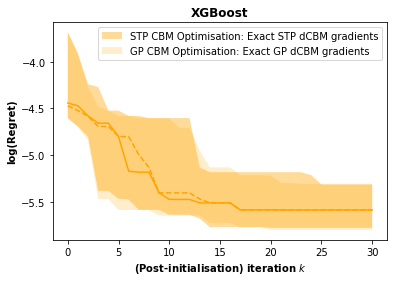

In [ ]:
### Visualise!

title = obj_func

plt.figure()

plt.plot(median_stp, color = 'Orange')
plt.plot(median_gp, color = 'Orange', ls='--')

xstar = np.arange(0, max_iter+1, step=1)
plt.fill_between(xstar, lower_stp, upper_stp, facecolor = 'Orange', alpha=0.4, label='STP CBM Optimisation: Exact STP dCBM gradients')
plt.fill_between(xstar, lower_gp, upper_gp, facecolor = 'Orange', alpha=0.20, label='GP CBM Optimisation: Exact GP dCBM gradients')

plt.title(title, weight = 'bold')
plt.xlabel('(Post-initialisation) iteration $\it{k}$', weight = 'bold') # x-axis label
plt.ylabel('log(Regret)', weight = 'bold') # y-axis label
plt.legend(loc=0) # add plot legend

plt.show() #visualise


In [ ]:
rmse_gp = [rmse_gp_1,
rmse_gp_2,
rmse_gp_3,
rmse_gp_4,
rmse_gp_5,
rmse_gp_6,
rmse_gp_7,
rmse_gp_8,
rmse_gp_9,
rmse_gp_10,
rmse_gp_11,
rmse_gp_12,
rmse_gp_13,
rmse_gp_14,
rmse_gp_15,
rmse_gp_16,
rmse_gp_17,
rmse_gp_18,
rmse_gp_19,
rmse_gp_20]

np.mean(rmse_gp)

0.05953334318484799

In [ ]:
rmse_stp = [rmse_stp_1,
rmse_stp_2,
rmse_stp_3,
rmse_stp_4,
rmse_stp_5,
rmse_stp_6,
rmse_stp_7,
rmse_stp_8,
rmse_stp_9,
rmse_stp_10,
rmse_stp_11,
rmse_stp_12,
rmse_stp_13,
rmse_stp_14,
rmse_stp_15,
rmse_stp_16,
rmse_stp_17,
rmse_stp_18,
rmse_stp_19,
rmse_stp_20]

np.mean(rmse_stp)

0.05981829574582838

In [ ]:
min_rmse_gp = min_max_array(rmse_gp)
min_rmse_gp, len(min_rmse_gp)

([0.05487254743054103,
  0.05487254743054103,
  0.05338833465863341,
  0.05338833465863341,
  0.05338833465863341,
  0.05338833465863341,
  0.05338833465863341,
  0.05338833465863341,
  0.05338833465863341,
  0.05338833465863341,
  0.05338833465863341,
  0.05338833465863341,
  0.05338833465863341,
  0.05338833465863341,
  0.05338833465863341,
  0.05159198298090472,
  0.05159198298090472,
  0.05159198298090472,
  0.05159198298090472,
  0.05159198298090472],
 20)

In [ ]:
min_rmse_stp = min_max_array(rmse_stp)
min_rmse_stp, len(min_rmse_stp)

([0.05403079862987836,
  0.05403079862987836,
  0.05338833759443926,
  0.05338833759443926,
  0.05338833759443926,
  0.05338833759443926,
  0.05338833759443926,
  0.05338833759443926,
  0.05338833759443926,
  0.05338833759443926,
  0.05338833759443926,
  0.05338833759443926,
  0.05338833759443926,
  0.05338833759443926,
  0.05338833759443926,
  0.05338833759443926,
  0.05338833759443926,
  0.053205082986664556,
  0.053205082986664556,
  0.053205082986664556],
 20)

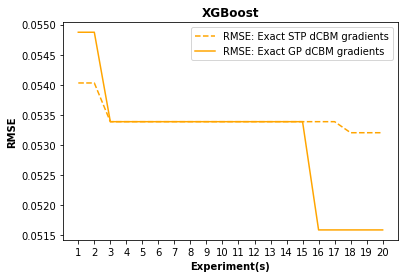

In [ ]:
### Visualise!

title = obj_func
plt.figure()

plt.plot(min_rmse_stp, color = 'Orange', ls = '--', label='RMSE: Exact STP dCBM gradients')
plt.plot(min_rmse_gp, color = 'Orange', label='RMSE: Exact GP dCBM gradients')

plt.title(title, weight = 'bold', family = 'Arial')
plt.xlabel('Experiment(s)', weight = 'bold') # x-axis label
plt.ylabel('RMSE', weight = 'bold', family = 'Arial') # y-axis label
plt.legend(loc=0) # add plot legend

### Make the x-ticks integers, not floats:
count = len(min_rmse_gp)
plt.xticks(np.arange(count), np.arange(1, count + 1))
plt.show() #visualise!
